# SAE on Normal NN MNIST

First SAE experiment.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 512
L1_PENALTY = 0.1

## Imports

In [3]:
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cpu


## Load Data

In [6]:
# train data
train_images = load_images("../data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [7]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

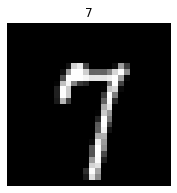

In [8]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

# Helper to Plot Weights

In [9]:
# Graphing code to visualize weights
def plot_weights(model, epoch):
    save_path_hidden_one = f'./weights/{EXPERIMENT_TYPE}/{RUN_ID}/hidden_one/hidden_one_weights_{epoch + 1}.png'
    save_path_classification = f'./weights/{EXPERIMENT_TYPE}/{RUN_ID}/classification/classification_weights_{epoch + 1}.png'
    save_path_hidden_two = f'./weights/{EXPERIMENT_TYPE}/{RUN_ID}/hidden_two/hidden_two_weights_{epoch + 1}.png'

    for path in [save_path_hidden_one, save_path_hidden_two, save_path_classification]:
        os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Extract weights from each layer
    hidden_one_w = model.hidden_one.weight.detach().cpu().numpy()  # Shape: (16, 784)
    hidden_two_w = model.hidden_two.weight.detach().cpu().numpy()  # Shape: (16, 16)
    classification_w = model.classification_layer.weight.detach().cpu().numpy()  # Shape: (10, 16)

    # Figure 1: Hidden One Weights (4x4 grid of 28x28 images)
    fig1, axes1 = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        row, col = divmod(i, 4)
        neuron_w = np.abs(hidden_one_w[i].reshape(28, 28))  # Reshape to 28x28
        axes1[row, col].imshow(neuron_w, cmap='gray')
        axes1[row, col].set_title(f"H1 Neuron {i+1}")
        axes1[row, col].axis('off')
    plt.suptitle(f"Hidden One Weights - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(save_path_hidden_one)
    plt.close()

    # Figure 2: Hidden Two Weights (4x4 grid of line plots)
    # TODO: change this to scatter plot (these should be disrete data points)
    fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
    min_w = hidden_two_w.min()
    max_w = hidden_two_w.max()
    for i in range(16):
        row, col = divmod(i, 4)
        axes2[row, col].plot(hidden_two_w[i])
        axes2[row, col].set_title(f"H2 Neuron {i+1}")
        axes2[row, col].set_xlabel("From H1 Neuron")
        axes2[row, col].set_ylabel("Weight")
        axes2[row, col].set_ylim(min_w, max_w)
    plt.suptitle(f"Hidden Two Weights - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(save_path_hidden_two)
    plt.close()

    # Figure 3: Classification Weights (2x5 grid of line plots)
    fig3, axes3 = plt.subplots(2, 5, figsize=(15, 6))
    min_w = classification_w.min()
    max_w = classification_w.max()
    for j in range(10):
        row, col = divmod(j, 5)
        axes3[row, col].plot(classification_w[j])
        axes3[row, col].set_title(f"Class {j}")
        axes3[row, col].set_xlabel("From H2 Neuron")
        axes3[row, col].set_ylabel("Weight")
        axes3[row, col].set_ylim(min_w, max_w)
    plt.suptitle(f"Classification Weights - Epoch {epoch+1}")
    plt.tight_layout()
    plt.savefig(save_path_classification)
    plt.close()

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [11]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [13]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]


### SAE

In [14]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

In [15]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())

In [16]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_two.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


In [17]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())

In [18]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_one.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


### Verify Reproducibility

In [19]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [20]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [21]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [22]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

In [23]:
best_model = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
SAE_hidden_one_losses = []
SAE_hidden_two_losses = []
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    sae_hidden_two.train()
    sae_hidden_one.train()
    
    train_loss = 0.0
    total_sae_loss_hidden_two = 0.0
    total_sae_loss_hidden_one = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)

        # Classification loss and backprop
        optimizer.zero_grad()
        total_loss = classification_loss_fn(classification_out, labels)
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

        # to prevent backprop on both graphs:
        hidden_act_one_detached = hidden_act_one.detach()
        hidden_act_two_detached = hidden_act_two.detach()
        
        # SAE loss and backprop - hidden layer two
        optimizer_sae_hidden_two.zero_grad()
        reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
        sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                  reconstructed_two,
                                                  encoded_two,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_two.backward()
        optimizer_sae_hidden_two.step()
        total_sae_loss_hidden_two += sae_loss_hidden_two.item()

        # SAE loss and backprop - hidden layer one
        optimizer_sae_hidden_one.zero_grad()
        reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
        sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                  reconstructed_one,
                                                  encoded_one,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_one.backward()
        optimizer_sae_hidden_one.step()
        total_sae_loss_hidden_one += sae_loss_hidden_one.item()
        

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
    avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
    print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = copy.deepcopy(model)
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = copy.deepcopy(model)

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
    SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)

    # plot_weights(model, epoch)

Epoch 1/20
  Train Loss: 1.0131
  SAE Train Loss (hidden one): 9.6322
  SAE Train Loss (hidden two): 1.4387
  Val Loss: 0.5521 | Val Acc: 83.76%
  Saved model with Val Acc: 83.76%


Epoch 2/20
  Train Loss: 0.4601
  SAE Train Loss (hidden one): 1.6914
  SAE Train Loss (hidden two): 0.3809
  Val Loss: 0.4512 | Val Acc: 86.42%
  Saved model with Val Acc: 86.42%


Epoch 3/20
  Train Loss: 0.4093
  SAE Train Loss (hidden one): 1.6152
  SAE Train Loss (hidden two): 0.2860
  Val Loss: 0.4022 | Val Acc: 87.76%
  Saved model with Val Acc: 87.76%


Epoch 4/20
  Train Loss: 0.3899
  SAE Train Loss (hidden one): 1.5874
  SAE Train Loss (hidden two): 0.2355
  Val Loss: 0.4044 | Val Acc: 87.80%
  Saved model with Val Acc: 87.80%


Epoch 5/20
  Train Loss: 0.3708
  SAE Train Loss (hidden one): 1.5150
  SAE Train Loss (hidden two): 0.2086
  Val Loss: 0.3718 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


Epoch 6/20
  Train Loss: 0.3590
  SAE Train Loss (hidden one): 1.4870
  SAE Train Loss (hidden two): 0.1896
  Val Loss: 0.3640 | Val Acc: 89.51%
  Saved model with Val Acc: 89.51%


Epoch 7/20
  Train Loss: 0.3511
  SAE Train Loss (hidden one): 1.4381
  SAE Train Loss (hidden two): 0.1768
  Val Loss: 0.3932 | Val Acc: 88.37%


Epoch 8/20
  Train Loss: 0.3440
  SAE Train Loss (hidden one): 1.3936
  SAE Train Loss (hidden two): 0.1662
  Val Loss: 0.3642 | Val Acc: 89.00%


Epoch 9/20
  Train Loss: 0.3392
  SAE Train Loss (hidden one): 1.4058
  SAE Train Loss (hidden two): 0.1593
  Val Loss: 0.3668 | Val Acc: 89.01%


Epoch 10/20
  Train Loss: 0.3337
  SAE Train Loss (hidden one): 1.3805
  SAE Train Loss (hidden two): 0.1508
  Val Loss: 0.3616 | Val Acc: 89.52%
  Saved model with Val Acc: 89.52%


Epoch 11/20
  Train Loss: 0.3278
  SAE Train Loss (hidden one): 1.3627
  SAE Train Loss (hidden two): 0.1467
  Val Loss: 0.3636 | Val Acc: 89.26%


Epoch 12/20
  Train Loss: 0.3276
  SAE Train Loss (hidden one): 1.3352
  SAE Train Loss (hidden two): 0.1392
  Val Loss: 0.3588 | Val Acc: 89.54%
  Saved model with Val Acc: 89.54%


Epoch 13/20
  Train Loss: 0.3246
  SAE Train Loss (hidden one): 1.3489
  SAE Train Loss (hidden two): 0.1334
  Val Loss: 0.3596 | Val Acc: 89.44%


Epoch 14/20
  Train Loss: 0.3221
  SAE Train Loss (hidden one): 1.3363
  SAE Train Loss (hidden two): 0.1254
  Val Loss: 0.3644 | Val Acc: 89.28%


Epoch 15/20
  Train Loss: 0.3212
  SAE Train Loss (hidden one): 1.2981
  SAE Train Loss (hidden two): 0.1192
  Val Loss: 0.3651 | Val Acc: 89.16%


Epoch 16/20
  Train Loss: 0.3165
  SAE Train Loss (hidden one): 1.3264
  SAE Train Loss (hidden two): 0.1162
  Val Loss: 0.3507 | Val Acc: 89.55%
  Saved model with Val Acc: 89.55%


Epoch 17/20
  Train Loss: 0.3181
  SAE Train Loss (hidden one): 1.3829
  SAE Train Loss (hidden two): 0.1105
  Val Loss: 0.3458 | Val Acc: 90.06%
  Saved model with Val Acc: 90.06%


Epoch 18/20
  Train Loss: 0.3160
  SAE Train Loss (hidden one): 1.3341
  SAE Train Loss (hidden two): 0.1027
  Val Loss: 0.3437 | Val Acc: 89.84%


Epoch 19/20
  Train Loss: 0.3143
  SAE Train Loss (hidden one): 1.3798
  SAE Train Loss (hidden two): 0.1012
  Val Loss: 0.3601 | Val Acc: 89.45%


Epoch 20/20
  Train Loss: 0.3108
  SAE Train Loss (hidden one): 1.3130
  SAE Train Loss (hidden two): 0.0962
  Val Loss: 0.3599 | Val Acc: 89.85%


# Training Exploration

In [24]:
def plot_losses(loss_one, loss_two, label_one, label_two):
    epochs = np.arange(1, len(loss_one) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss_one, 'b-', label=f'{label_one} Loss')
    plt.plot(epochs, loss_two, 'r-', label=f'{label_two} Loss')
    plt.title(f'{label_one} and {label_two} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

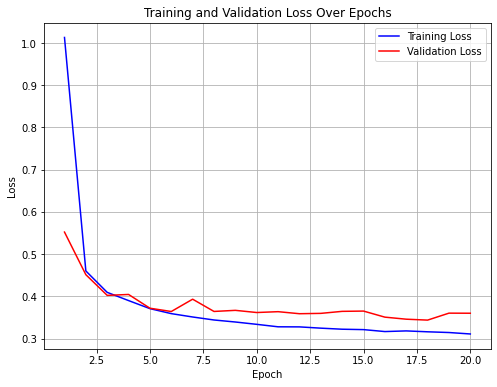

In [25]:
plot_losses(training_losses, validation_losses, label_one="Training", label_two="Validation")

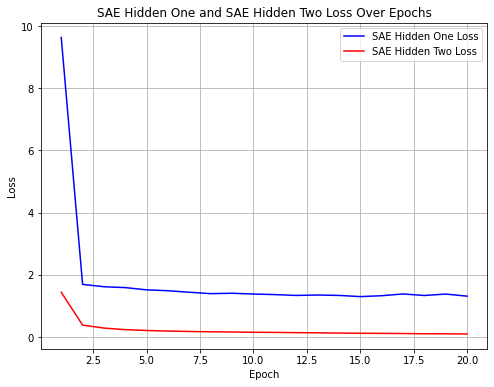

In [26]:
plot_losses(SAE_hidden_one_losses, SAE_hidden_two_losses, 
            label_one="SAE Hidden One", label_two="SAE Hidden Two")

## Eval

Evaluating our classification model accuracy, in addition to the reconstruction and sparisty metrics of each SAE.

In [27]:
best_model.eval()  # again currently a no-op
sae_hidden_one.eval()
sae_hidden_two.eval()

test_correct = 0
test_total = 0

feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
recon_errors_one = []
recon_errors_two = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(images)
        reconstructed_one, encoded_one = sae_hidden_one(hidden_one_act)
        reconstructed_two, encoded_two = sae_hidden_two(hidden_two_act)

        # SAE reconstruction
        recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
        recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())

        start_idx = i * test_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# reconstruction accuracy of SAE at each layer
avg_recon_error_one = np.mean(recon_errors_one)
avg_recon_error_two = np.mean(recon_errors_two)
print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")

# Compute sparsity (average non-zero features per image)
sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Evaluation: 100%|████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 319.65it/s]

Final Test Accuracy: 90.42%
Average Reconstruction Error (Hidden One): 0.0200
Average Reconstruction Error (Hidden Two): 0.0385
Average Non-Zero Features per Image (Hidden One): 21.89
Average Non-Zero Features per Image (Hidden Two): 14.46


# SAE Feature Exploration

In [28]:
feature_activations_hidden_two = torch.zeros(HIDDEN_SIZE, len(train_images))
feature_activations_hidden_one = torch.zeros(HIDDEN_SIZE, len(train_images))

with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        _, hidden_one_act, hidden_two_act = best_model(images)

        # hidden layer two SAE
        _, encoded_two = sae_hidden_two(hidden_two_act)

        # hidden layer one SAE
        _, encoded_one = sae_hidden_one(hidden_one_act)

        start_idx = i * train_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_hidden_one[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_hidden_two[:, start_idx:end_idx] = encoded_two.T.cpu()

## Particular Example

In [29]:
def visual_img_and_sparse_vecs(image, label, encoded_one, encoded_two, save_plt=False):
    # Visualize image and sparse vectors
    fig = plt.figure(figsize=(15, 10))
    
    # Plot the input image
    plt.subplot(2, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Input Image (Label: {label})")
    plt.axis('off')
    
    # Plot sparse vector for sae_hidden_one
    plt.subplot(2, 2, 3)
    plt.bar(range(len(encoded_one)), encoded_one)
    plt.title("Sparse Vector (Hidden One)")
    plt.xlabel("Feature Index")
    plt.ylabel("Activation")
    plt.grid(True, alpha=0.3)
    
    # Plot sparse vector for sae_hidden_two
    plt.subplot(2, 2, 4)
    plt.bar(range(len(encoded_two)), encoded_two)
    plt.title("Sparse Vector (Hidden Two)")
    plt.xlabel("Feature Index")
    plt.ylabel("Activation")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()

    if save_plt:
        path = f"./sparse_vectors/{EXPERIMENT_TYPE}/{HIDDEN_SIZE}-{L1_PENALTY}/{label}.png"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
        plt.close()
    else:
        plt.show()

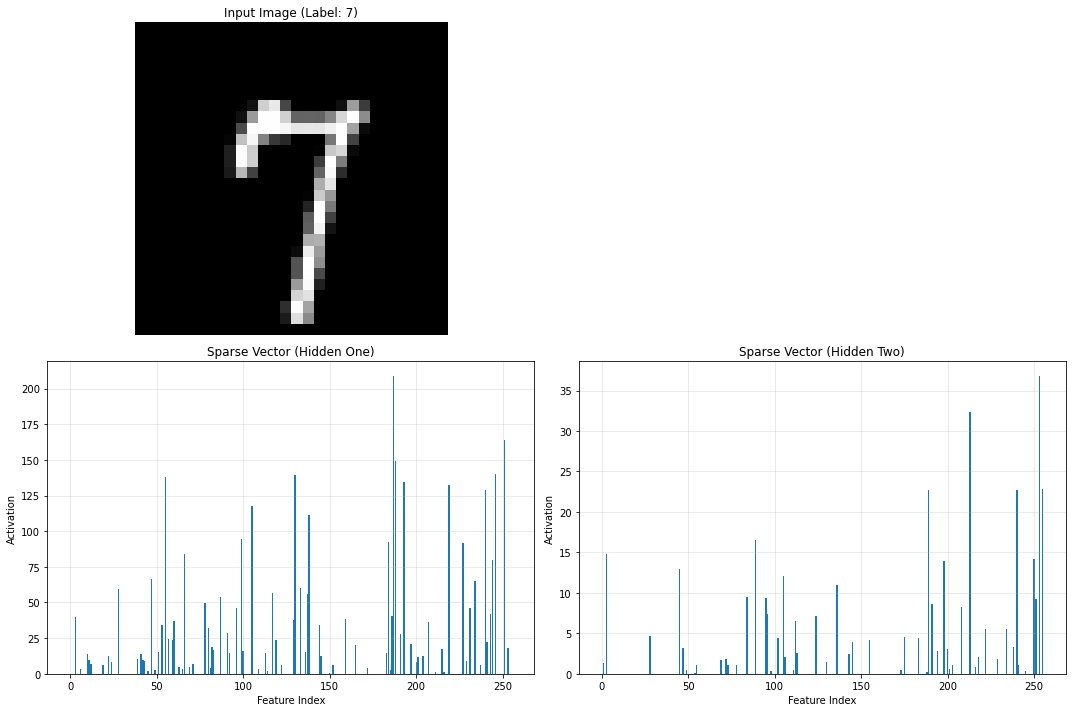

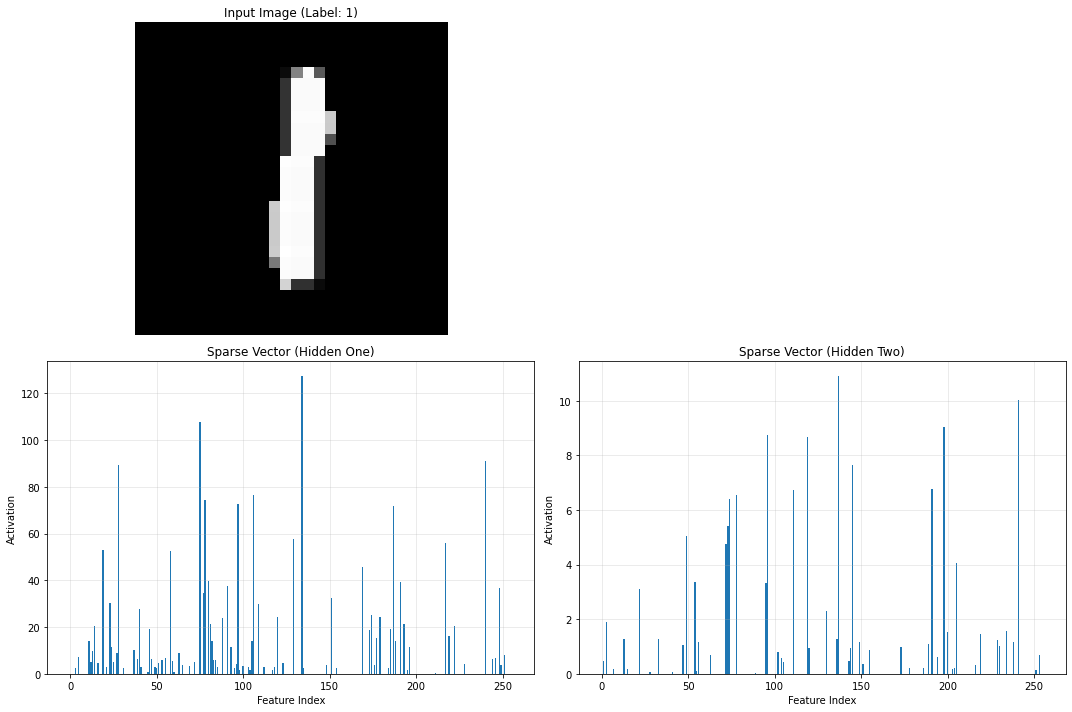

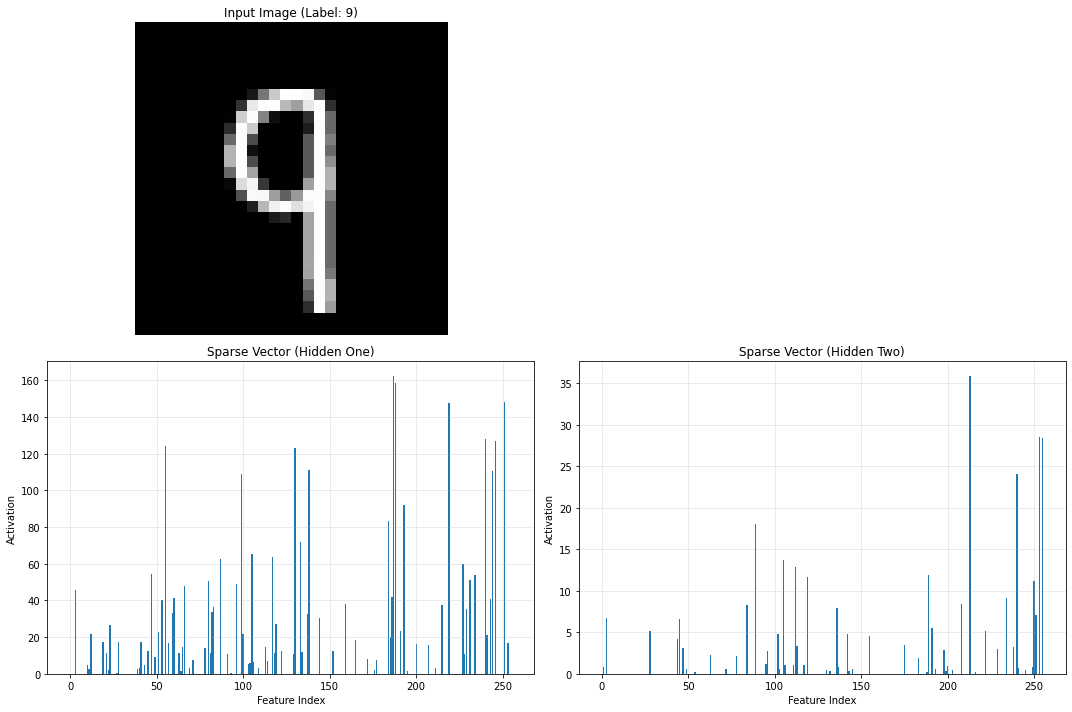

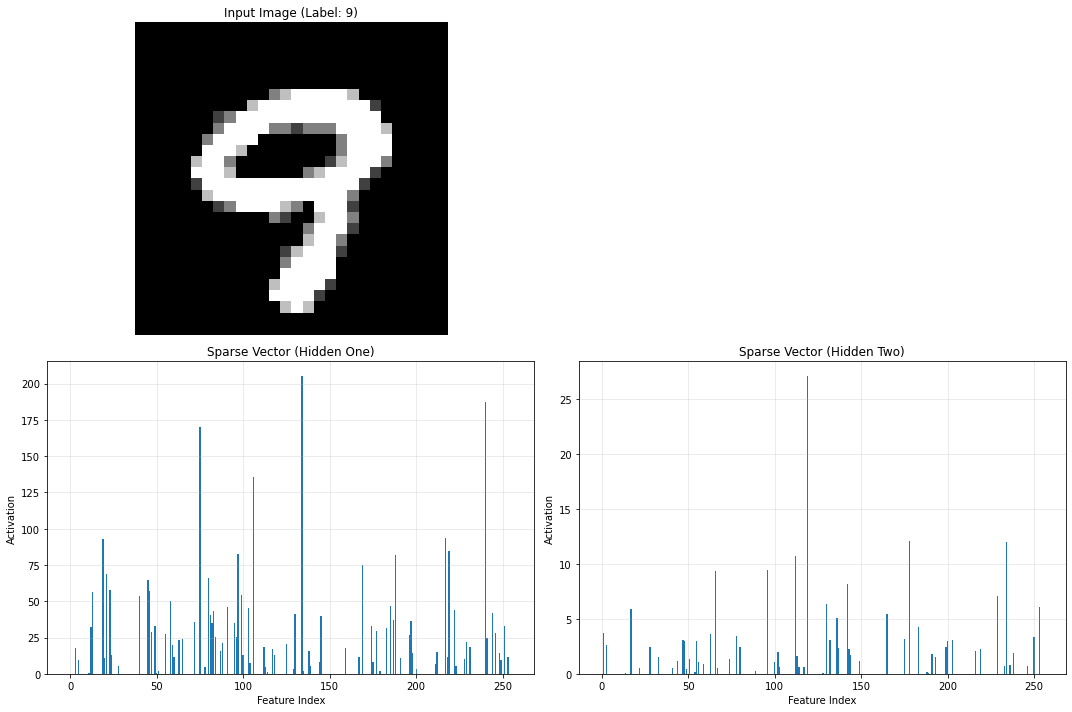

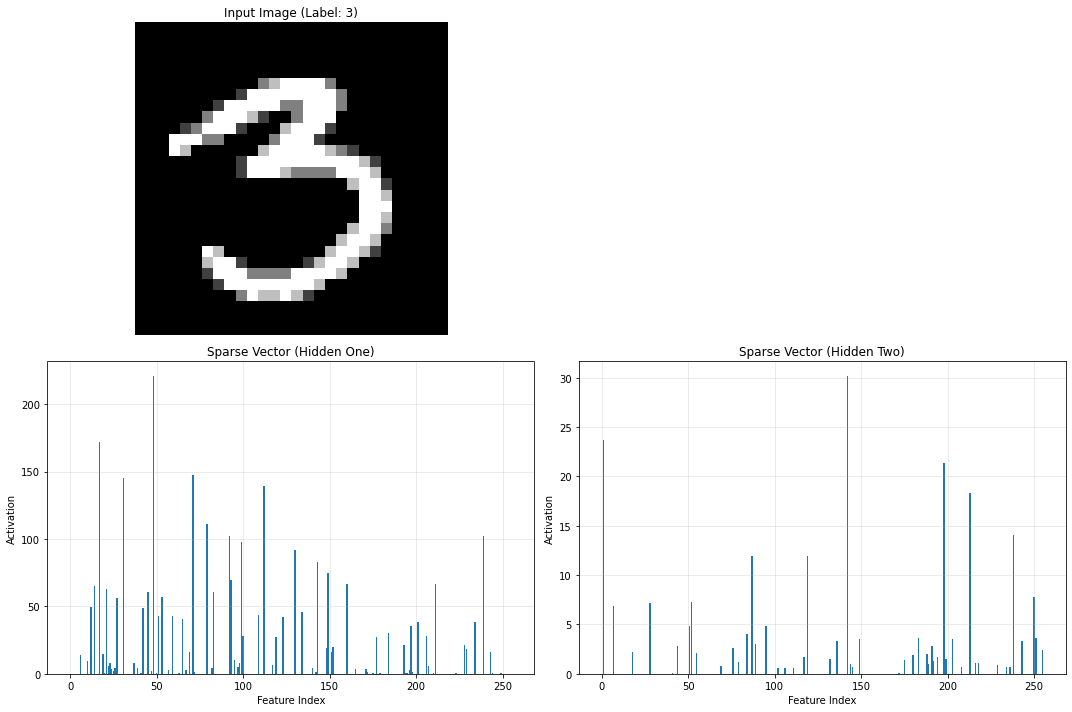

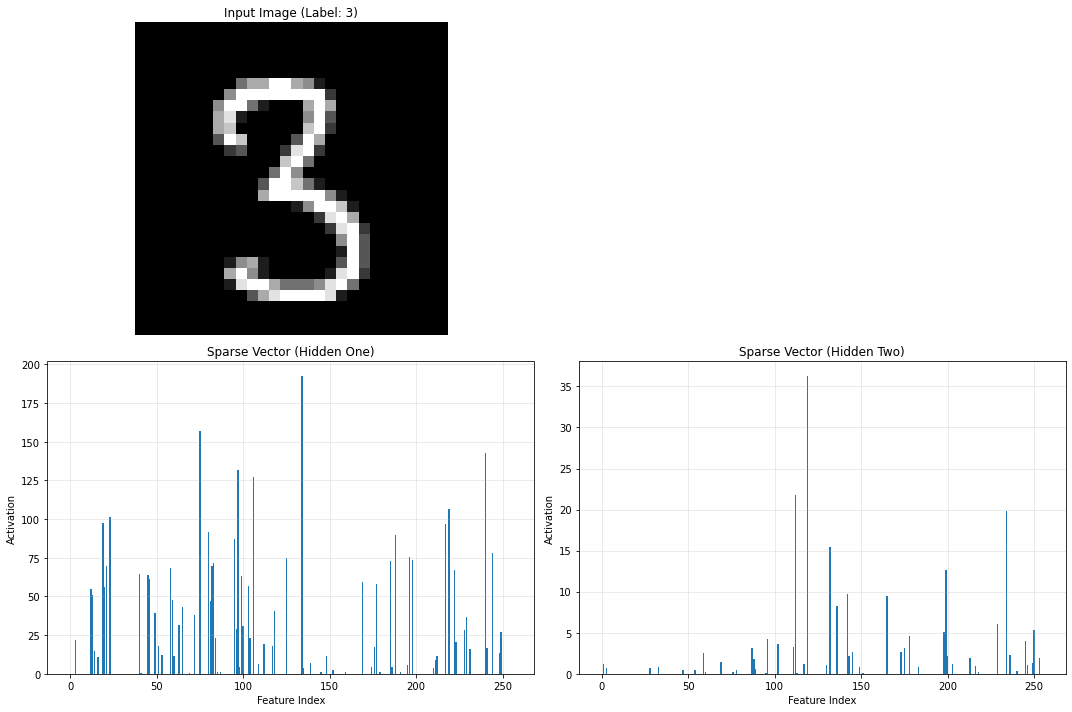

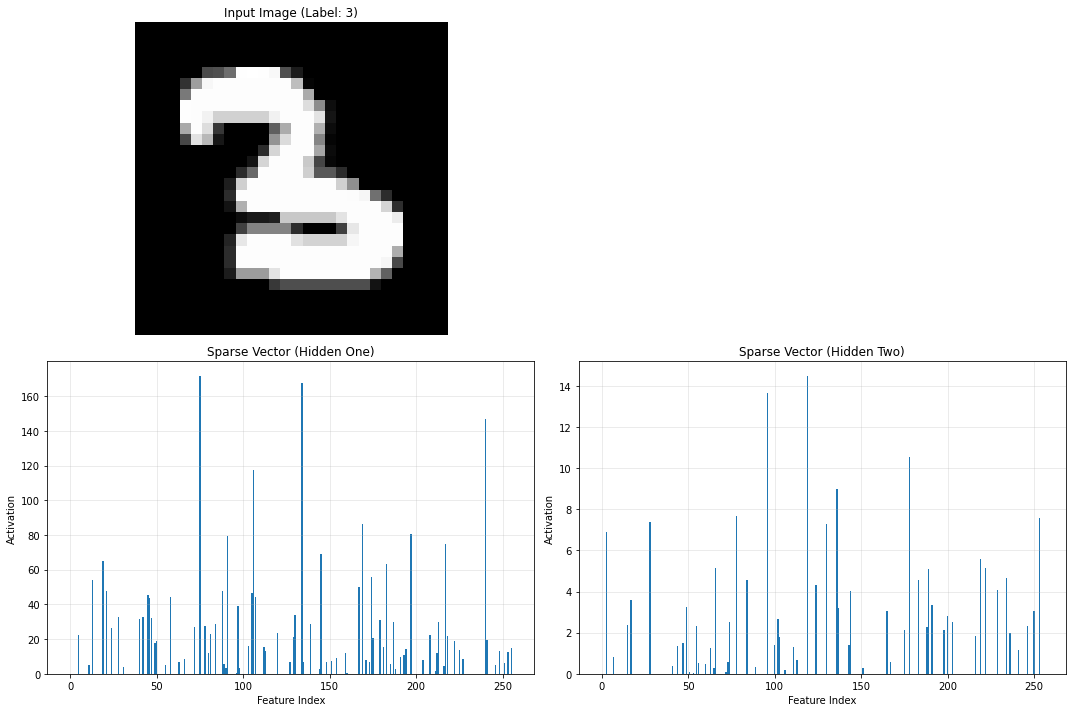

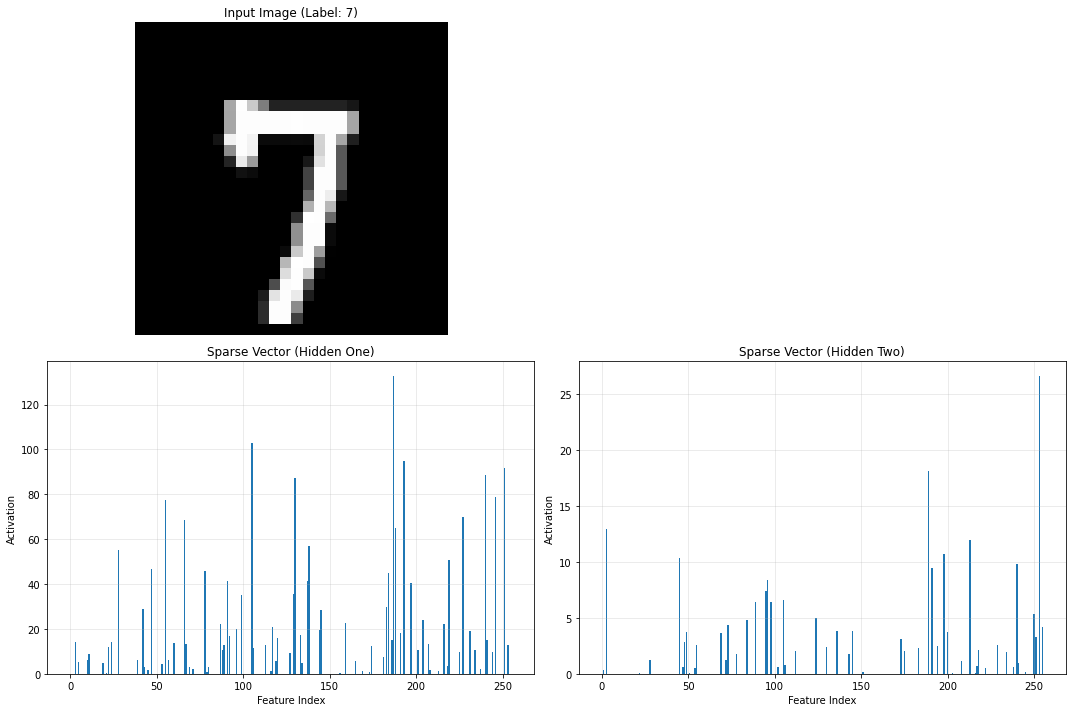

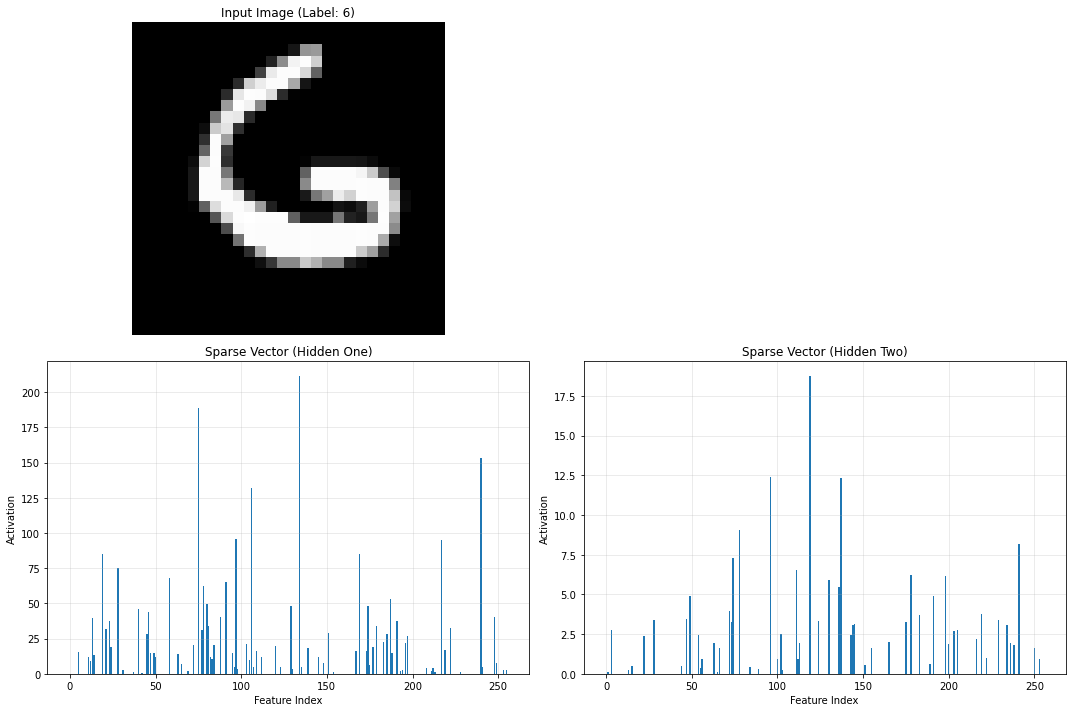

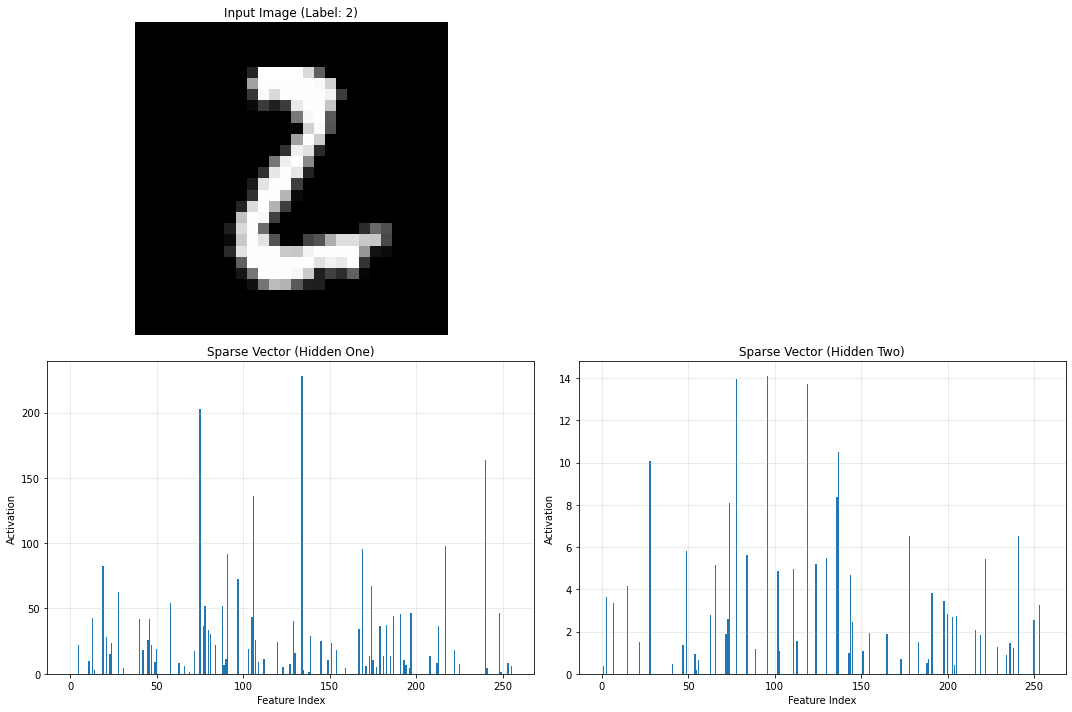

In [36]:
# image_idx = 0
for image_idx in range(0, 10):
    image, label = train_dataset[image_idx]
    
    encoded_one = feature_activations_hidden_one[:, image_idx].numpy()
    encoded_two = feature_activations_hidden_two[:, image_idx].numpy()
    
    visual_img_and_sparse_vecs(image, label, encoded_one, encoded_two)


Hidden One Feature-Class Associations:
Feature 1: Highest average activation for digit 0


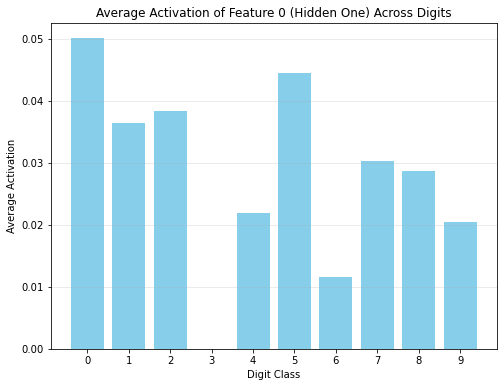

Feature 2: Highest average activation for digit 0
Feature 3: Highest average activation for digit 0
Feature 4: Highest average activation for digit 2
Feature 5: Highest average activation for digit 1
Feature 6: Highest average activation for digit 4
Feature 7: Highest average activation for digit 3
Feature 8: Highest average activation for digit 4
Feature 9: Highest average activation for digit 0
Feature 10: Highest average activation for digit 0
Feature 11: Highest average activation for digit 0


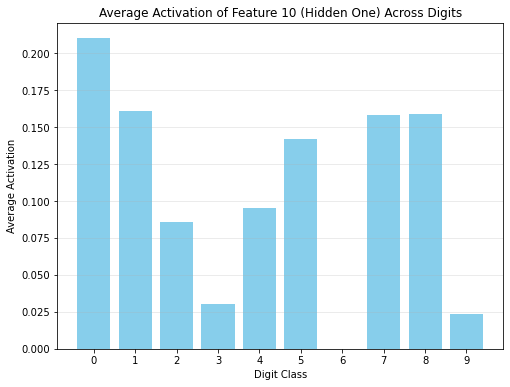

Feature 12: Highest average activation for digit 5
Feature 13: Highest average activation for digit 1
Feature 14: Highest average activation for digit 1
Feature 15: Highest average activation for digit 1
Feature 16: Highest average activation for digit 4
Feature 17: Highest average activation for digit 1
Feature 18: Highest average activation for digit 7
Feature 19: Highest average activation for digit 6
Feature 20: Highest average activation for digit 9
Feature 21: Highest average activation for digit 1
Feature 22: Highest average activation for digit 1
Feature 23: Highest average activation for digit 9
Feature 24: Highest average activation for digit 1
Feature 25: Highest average activation for digit 4
Feature 26: Highest average activation for digit 8
Feature 27: Highest average activation for digit 5
Feature 28: Highest average activation for digit 0


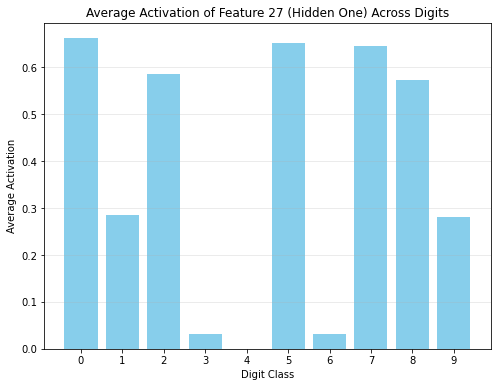

Feature 29: Highest average activation for digit 5
Feature 30: Highest average activation for digit 3
Feature 31: Highest average activation for digit 0
Feature 32: Highest average activation for digit 7
Feature 33: Highest average activation for digit 0


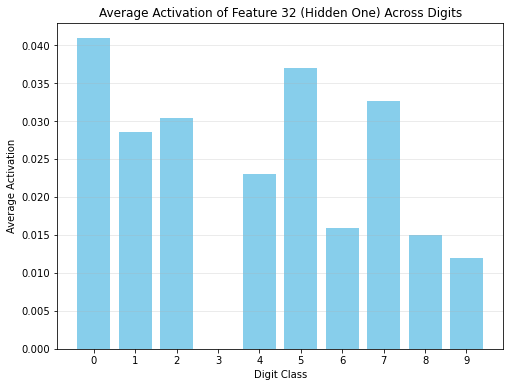

Feature 34: Highest average activation for digit 0
Feature 35: Highest average activation for digit 0
Feature 36: Highest average activation for digit 0
Feature 37: Highest average activation for digit 0
Feature 38: Highest average activation for digit 1
Feature 39: Highest average activation for digit 0
Feature 40: Highest average activation for digit 5
Feature 41: Highest average activation for digit 8
Feature 42: Highest average activation for digit 2
Feature 43: Highest average activation for digit 4
Feature 44: Highest average activation for digit 5
Feature 45: Highest average activation for digit 4
Feature 46: Highest average activation for digit 1
Feature 47: Highest average activation for digit 1
Feature 48: Highest average activation for digit 5
Feature 49: Highest average activation for digit 7
Feature 50: Highest average activation for digit 1
Feature 51: Highest average activation for digit 4
Feature 52: Highest average activation for digit 1
Feature 53: Highest average act

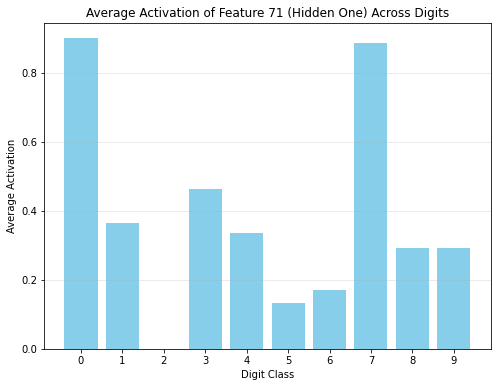

Feature 73: Highest average activation for digit 1
Feature 74: Highest average activation for digit 0
Feature 75: Highest average activation for digit 8
Feature 76: Highest average activation for digit 9
Feature 77: Highest average activation for digit 0
Feature 78: Highest average activation for digit 8
Feature 79: Highest average activation for digit 5
Feature 80: Highest average activation for digit 0


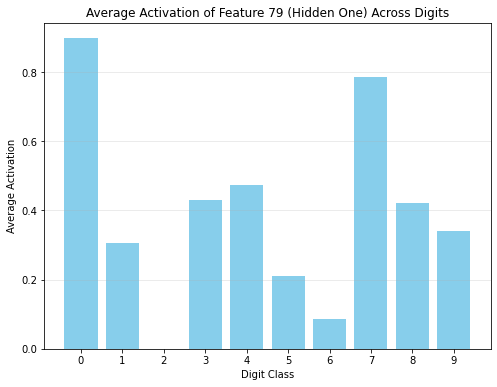

Feature 81: Highest average activation for digit 2
Feature 82: Highest average activation for digit 3
Feature 83: Highest average activation for digit 1
Feature 84: Highest average activation for digit 1
Feature 85: Highest average activation for digit 1
Feature 86: Highest average activation for digit 1
Feature 87: Highest average activation for digit 0
Feature 88: Highest average activation for digit 2
Feature 89: Highest average activation for digit 9
Feature 90: Highest average activation for digit 9
Feature 91: Highest average activation for digit 4
Feature 92: Highest average activation for digit 9
Feature 93: Highest average activation for digit 7
Feature 94: Highest average activation for digit 0


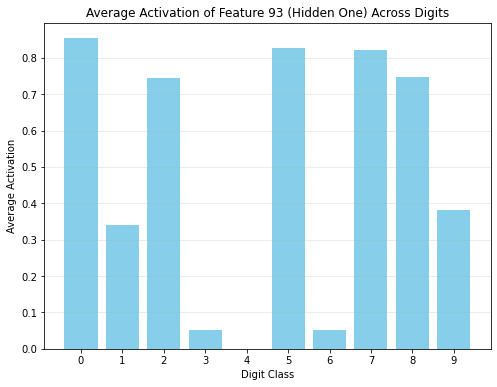

Feature 95: Highest average activation for digit 4
Feature 96: Highest average activation for digit 1
Feature 97: Highest average activation for digit 2
Feature 98: Highest average activation for digit 1
Feature 99: Highest average activation for digit 1
Feature 100: Highest average activation for digit 1
Feature 101: Highest average activation for digit 1
Feature 102: Highest average activation for digit 0
Feature 103: Highest average activation for digit 0
Feature 104: Highest average activation for digit 1
Feature 105: Highest average activation for digit 1
Feature 106: Highest average activation for digit 4
Feature 107: Highest average activation for digit 9
Feature 108: Highest average activation for digit 4
Feature 109: Highest average activation for digit 0
Feature 110: Highest average activation for digit 7
Feature 111: Highest average activation for digit 0
Feature 112: Highest average activation for digit 4
Feature 113: Highest average activation for digit 7
Feature 114: High

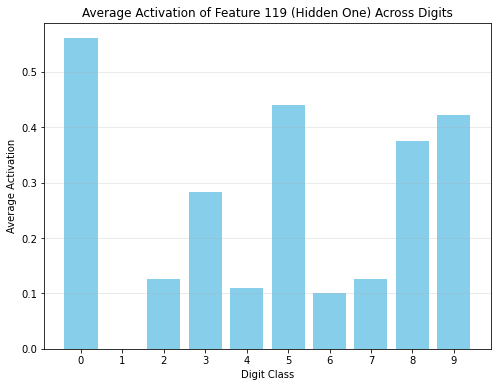

Feature 121: Highest average activation for digit 5
Feature 122: Highest average activation for digit 5
Feature 123: Highest average activation for digit 3
Feature 124: Highest average activation for digit 0


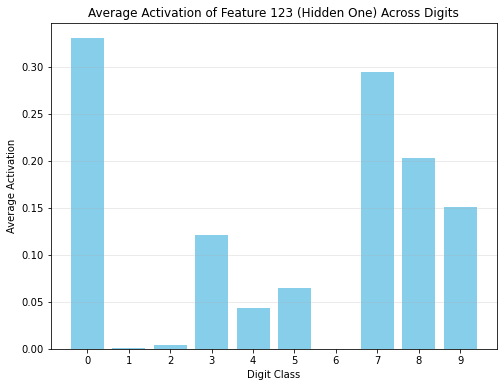

Feature 125: Highest average activation for digit 0
Feature 126: Highest average activation for digit 1
Feature 127: Highest average activation for digit 0
Feature 128: Highest average activation for digit 9
Feature 129: Highest average activation for digit 0
Feature 130: Highest average activation for digit 5
Feature 131: Highest average activation for digit 5
Feature 132: Highest average activation for digit 0
Feature 133: Highest average activation for digit 0
Feature 134: Highest average activation for digit 2
Feature 135: Highest average activation for digit 8
Feature 136: Highest average activation for digit 9
Feature 137: Highest average activation for digit 3
Feature 138: Highest average activation for digit 2
Feature 139: Highest average activation for digit 2
Feature 140: Highest average activation for digit 6
Feature 141: Highest average activation for digit 1
Feature 142: Highest average activation for digit 0
Feature 143: Highest average activation for digit 4
Feature 144:

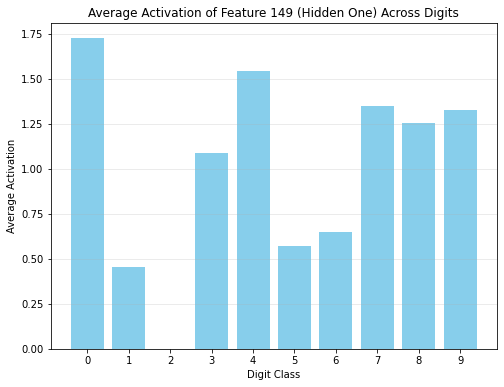

Feature 151: Highest average activation for digit 5
Feature 152: Highest average activation for digit 5
Feature 153: Highest average activation for digit 5
Feature 154: Highest average activation for digit 0
Feature 155: Highest average activation for digit 5
Feature 156: Highest average activation for digit 4
Feature 157: Highest average activation for digit 9
Feature 158: Highest average activation for digit 0
Feature 159: Highest average activation for digit 0
Feature 160: Highest average activation for digit 2
Feature 161: Highest average activation for digit 7
Feature 162: Highest average activation for digit 0
Feature 163: Highest average activation for digit 1
Feature 164: Highest average activation for digit 4
Feature 165: Highest average activation for digit 0
Feature 166: Highest average activation for digit 0


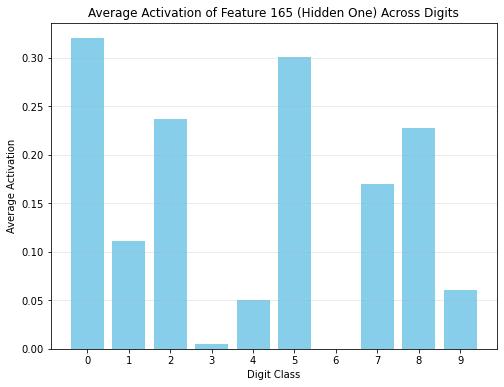

Feature 167: Highest average activation for digit 0
Feature 168: Highest average activation for digit 4
Feature 169: Highest average activation for digit 0
Feature 170: Highest average activation for digit 9
Feature 171: Highest average activation for digit 0
Feature 172: Highest average activation for digit 4
Feature 173: Highest average activation for digit 3
Feature 174: Highest average activation for digit 5
Feature 175: Highest average activation for digit 9
Feature 176: Highest average activation for digit 4
Feature 177: Highest average activation for digit 0


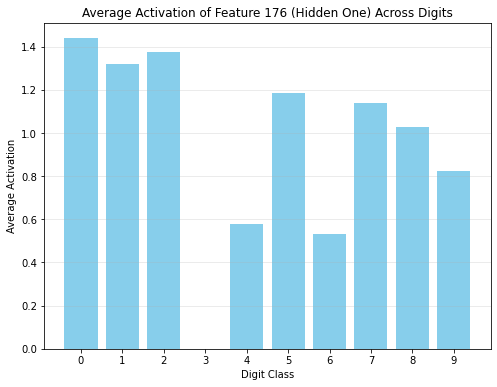

Feature 178: Highest average activation for digit 1
Feature 179: Highest average activation for digit 3
Feature 180: Highest average activation for digit 4
Feature 181: Highest average activation for digit 4
Feature 182: Highest average activation for digit 4
Feature 183: Highest average activation for digit 0
Feature 184: Highest average activation for digit 4
Feature 185: Highest average activation for digit 5
Feature 186: Highest average activation for digit 1
Feature 187: Highest average activation for digit 2
Feature 188: Highest average activation for digit 5
Feature 189: Highest average activation for digit 2
Feature 190: Highest average activation for digit 0
Feature 191: Highest average activation for digit 0
Feature 192: Highest average activation for digit 8
Feature 193: Highest average activation for digit 0
Feature 194: Highest average activation for digit 5
Feature 195: Highest average activation for digit 9
Feature 196: Highest average activation for digit 0


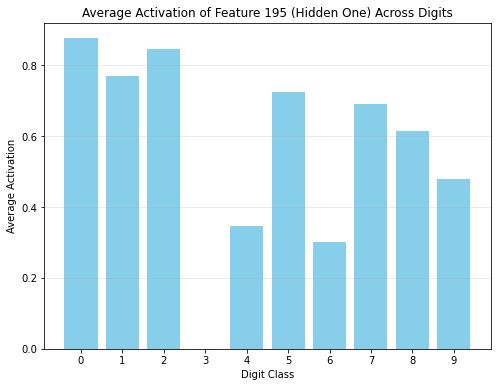

Feature 197: Highest average activation for digit 1
Feature 198: Highest average activation for digit 4
Feature 199: Highest average activation for digit 1
Feature 200: Highest average activation for digit 1
Feature 201: Highest average activation for digit 5
Feature 202: Highest average activation for digit 7
Feature 203: Highest average activation for digit 0
Feature 204: Highest average activation for digit 0
Feature 205: Highest average activation for digit 5
Feature 206: Highest average activation for digit 0
Feature 207: Highest average activation for digit 7
Feature 208: Highest average activation for digit 3
Feature 209: Highest average activation for digit 4
Feature 210: Highest average activation for digit 4
Feature 211: Highest average activation for digit 3
Feature 212: Highest average activation for digit 1
Feature 213: Highest average activation for digit 8
Feature 214: Highest average activation for digit 8
Feature 215: Highest average activation for digit 0
Feature 216:

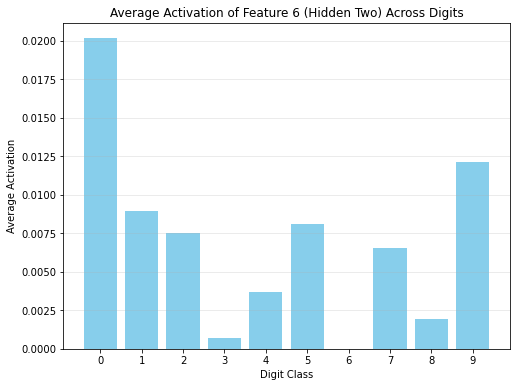

Feature 8: Highest average activation for digit 0


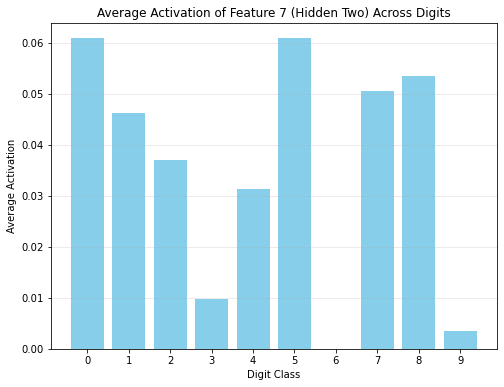

Feature 9: Highest average activation for digit 0
Feature 10: Highest average activation for digit 2
Feature 11: Highest average activation for digit 0
Feature 12: Highest average activation for digit 9
Feature 13: Highest average activation for digit 9
Feature 14: Highest average activation for digit 3
Feature 15: Highest average activation for digit 1
Feature 16: Highest average activation for digit 8
Feature 17: Highest average activation for digit 0
Feature 18: Highest average activation for digit 1
Feature 19: Highest average activation for digit 5
Feature 20: Highest average activation for digit 1
Feature 21: Highest average activation for digit 9
Feature 22: Highest average activation for digit 7
Feature 23: Highest average activation for digit 4
Feature 24: Highest average activation for digit 8
Feature 25: Highest average activation for digit 1
Feature 26: Highest average activation for digit 6
Feature 27: Highest average activation for digit 0
Feature 28: Highest average acti

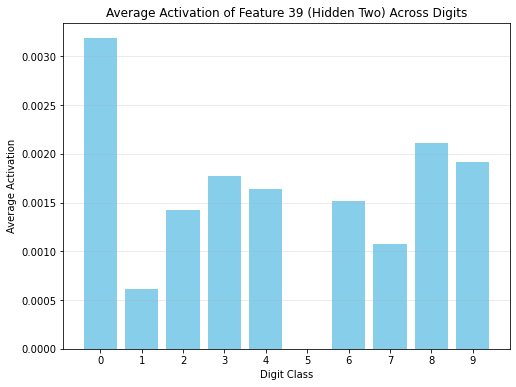

Feature 41: Highest average activation for digit 0
Feature 42: Highest average activation for digit 8
Feature 43: Highest average activation for digit 0


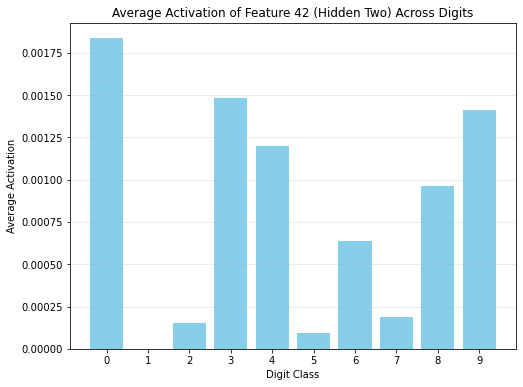

Feature 44: Highest average activation for digit 0
Feature 45: Highest average activation for digit 3
Feature 46: Highest average activation for digit 2
Feature 47: Highest average activation for digit 8
Feature 48: Highest average activation for digit 2
Feature 49: Highest average activation for digit 6
Feature 50: Highest average activation for digit 5
Feature 51: Highest average activation for digit 7
Feature 52: Highest average activation for digit 1
Feature 53: Highest average activation for digit 4
Feature 54: Highest average activation for digit 5
Feature 55: Highest average activation for digit 3
Feature 56: Highest average activation for digit 5
Feature 57: Highest average activation for digit 8
Feature 58: Highest average activation for digit 8
Feature 59: Highest average activation for digit 9
Feature 60: Highest average activation for digit 1
Feature 61: Highest average activation for digit 5
Feature 62: Highest average activation for digit 2
Feature 63: Highest average act

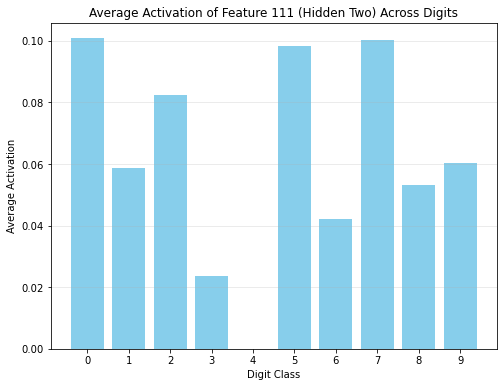

Feature 113: Highest average activation for digit 1
Feature 114: Highest average activation for digit 5
Feature 115: Highest average activation for digit 8
Feature 116: Highest average activation for digit 0
Feature 117: Highest average activation for digit 5
Feature 118: Highest average activation for digit 1
Feature 119: Highest average activation for digit 0
Feature 120: Highest average activation for digit 1
Feature 121: Highest average activation for digit 4
Feature 122: Highest average activation for digit 6
Feature 123: Highest average activation for digit 7
Feature 124: Highest average activation for digit 7
Feature 125: Highest average activation for digit 0


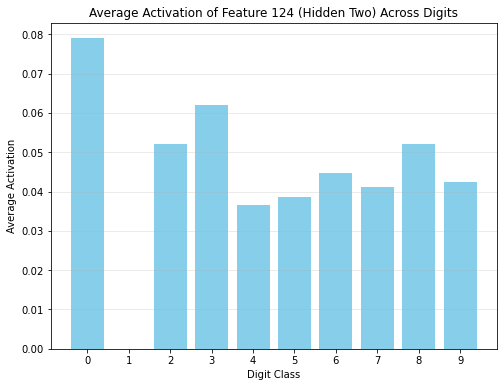

Feature 126: Highest average activation for digit 0
Feature 127: Highest average activation for digit 0
Feature 128: Highest average activation for digit 2
Feature 129: Highest average activation for digit 1
Feature 130: Highest average activation for digit 6
Feature 131: Highest average activation for digit 8
Feature 132: Highest average activation for digit 0
Feature 133: Highest average activation for digit 1
Feature 134: Highest average activation for digit 1
Feature 135: Highest average activation for digit 5
Feature 136: Highest average activation for digit 6
Feature 137: Highest average activation for digit 3
Feature 138: Highest average activation for digit 3
Feature 139: Highest average activation for digit 1
Feature 140: Highest average activation for digit 2
Feature 141: Highest average activation for digit 2
Feature 142: Highest average activation for digit 0
Feature 143: Highest average activation for digit 1
Feature 144: Highest average activation for digit 9
Feature 145:

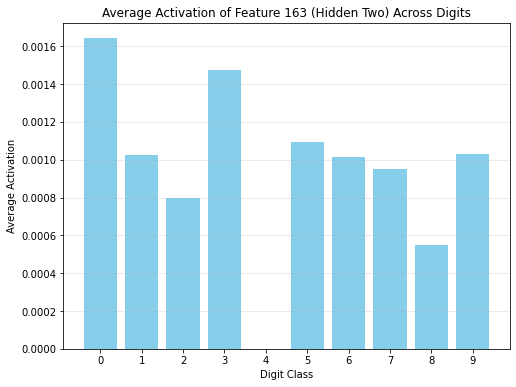

Feature 165: Highest average activation for digit 0
Feature 166: Highest average activation for digit 1
Feature 167: Highest average activation for digit 0
Feature 168: Highest average activation for digit 4
Feature 169: Highest average activation for digit 3
Feature 170: Highest average activation for digit 8
Feature 171: Highest average activation for digit 0


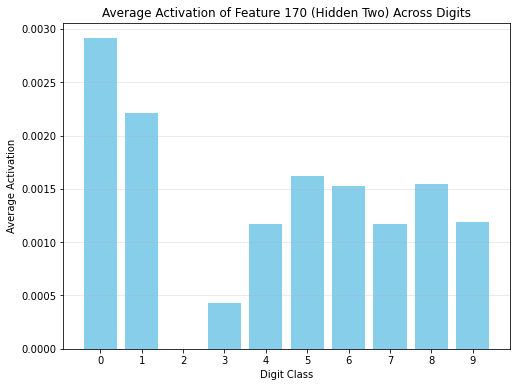

Feature 172: Highest average activation for digit 0
Feature 173: Highest average activation for digit 0


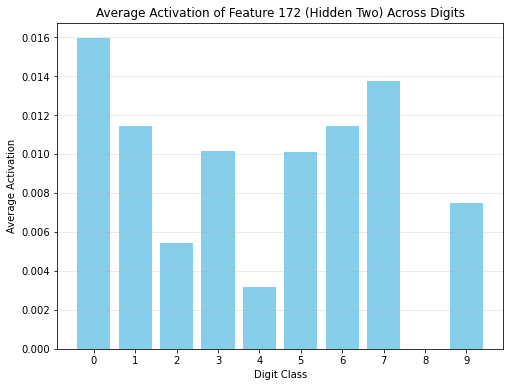

Feature 174: Highest average activation for digit 9
Feature 175: Highest average activation for digit 2
Feature 176: Highest average activation for digit 1
Feature 177: Highest average activation for digit 2
Feature 178: Highest average activation for digit 8
Feature 179: Highest average activation for digit 8
Feature 180: Highest average activation for digit 0
Feature 181: Highest average activation for digit 5
Feature 182: Highest average activation for digit 1
Feature 183: Highest average activation for digit 1
Feature 184: Highest average activation for digit 1
Feature 185: Highest average activation for digit 4
Feature 186: Highest average activation for digit 4
Feature 187: Highest average activation for digit 5
Feature 188: Highest average activation for digit 1
Feature 189: Highest average activation for digit 5
Feature 190: Highest average activation for digit 5
Feature 191: Highest average activation for digit 8
Feature 192: Highest average activation for digit 5
Feature 193:

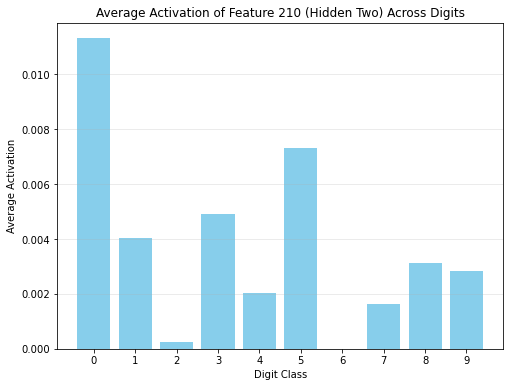

Feature 212: Highest average activation for digit 8
Feature 213: Highest average activation for digit 5
Feature 214: Highest average activation for digit 2
Feature 215: Highest average activation for digit 3
Feature 216: Highest average activation for digit 0
Feature 217: Highest average activation for digit 2
Feature 218: Highest average activation for digit 4
Feature 219: Highest average activation for digit 0


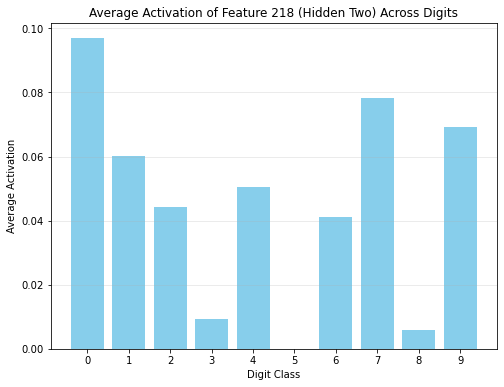

Feature 220: Highest average activation for digit 5
Feature 221: Highest average activation for digit 5
Feature 222: Highest average activation for digit 5
Feature 223: Highest average activation for digit 4
Feature 224: Highest average activation for digit 0
Feature 225: Highest average activation for digit 8
Feature 226: Highest average activation for digit 0
Feature 227: Highest average activation for digit 5
Feature 228: Highest average activation for digit 1
Feature 229: Highest average activation for digit 0
Feature 230: Highest average activation for digit 1
Feature 231: Highest average activation for digit 5
Feature 232: Highest average activation for digit 0
Feature 233: Highest average activation for digit 1
Feature 234: Highest average activation for digit 1
Feature 235: Highest average activation for digit 1
Feature 236: Highest average activation for digit 4
Feature 237: Highest average activation for digit 7
Feature 238: Highest average activation for digit 0
Feature 239:

In [32]:
labels = np.array([label for label in train_labels])
for layer_name, feature_activations in [("Hidden One", feature_activations_hidden_one),
                                        ("Hidden Two", feature_activations_hidden_two)]:
    print(f"\n{layer_name} Feature-Class Associations:")
    for feature_idx in range(HIDDEN_SIZE):
        activations = feature_activations[feature_idx].numpy()
        class_averages = [np.mean(activations[labels == c]) for c in range(10)]

        top_class = np.argmax(class_averages)

        print(f"Feature {feature_idx + 1}: Highest average activation for digit {top_class}")
        if top_class == 0 and max(class_averages) >= 0.001:
            plt.figure(figsize=(8, 6))
            class_averages_graph = class_averages - min(class_averages)
            plt.bar(range(10), class_averages_graph, tick_label=[str(i) for i in range(10)], color='skyblue')
            plt.title(f"Average Activation of Feature {feature_idx} ({layer_name}) Across Digits")
            plt.xlabel("Digit Class")
            plt.ylabel("Average Activation")
            plt.grid(True, axis='y', alpha=0.3)
            plt.show()

## Top Activating Images By Feature

In [33]:
# Find top activating images for each feature
def show_top_act_images_by_feature(feature_activations, images, labels, top_k=3):
    for feature_idx in range(HIDDEN_SIZE):
        activations = feature_activations[feature_idx]
        top_indices = torch.topk(activations, top_k).indices
        print(f"Feature {feature_idx} top {top_k} activations:")
        for idx in top_indices:
            image, label = images[idx], labels[idx]
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f"Label: {label}")
            plt.show()

Feature 0 top 3 activations:


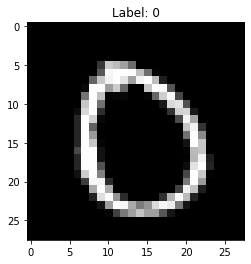

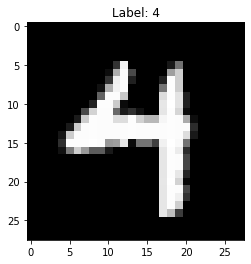

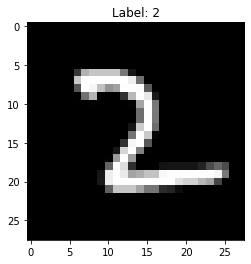

Feature 1 top 3 activations:


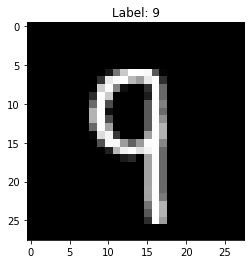

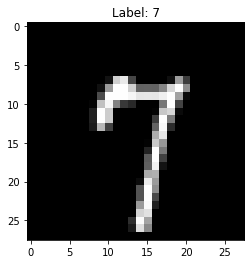

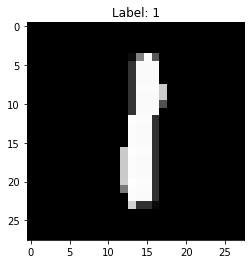

Feature 2 top 3 activations:


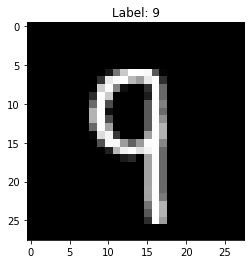

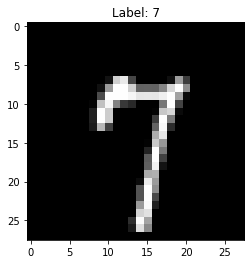

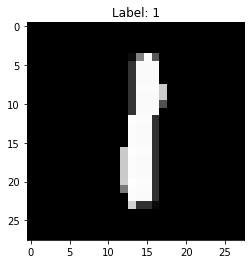

Feature 3 top 3 activations:


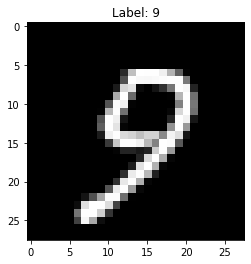

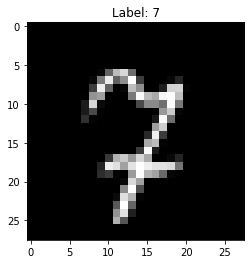

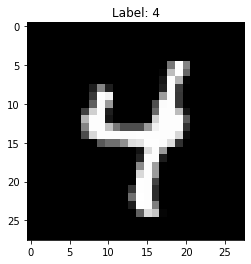

Feature 4 top 3 activations:


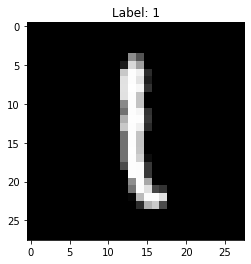

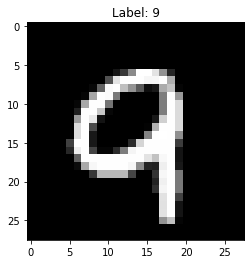

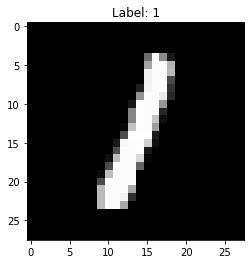

Feature 5 top 3 activations:


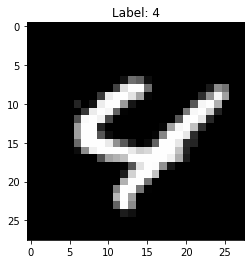

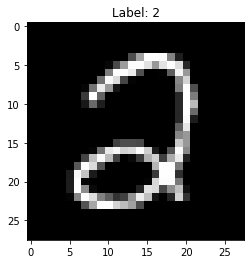

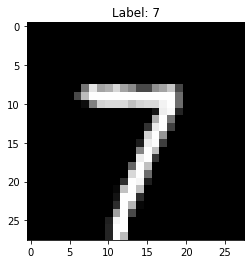

Feature 6 top 3 activations:


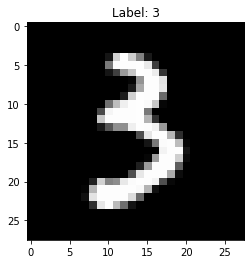

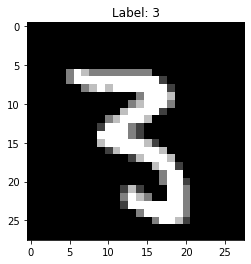

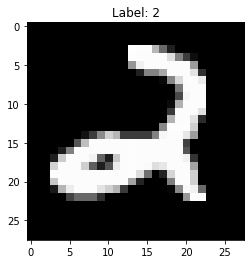

Feature 7 top 3 activations:


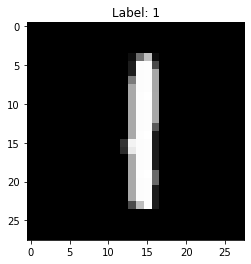

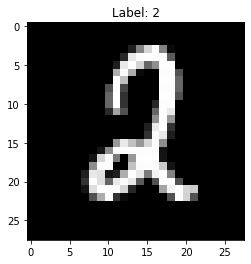

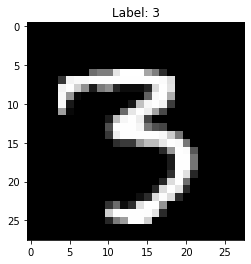

Feature 8 top 3 activations:


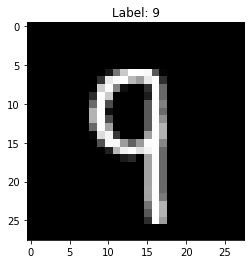

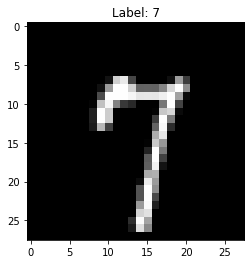

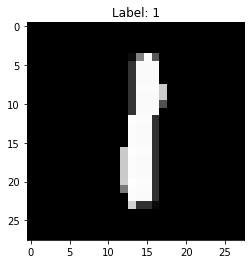

Feature 9 top 3 activations:


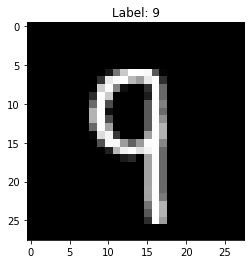

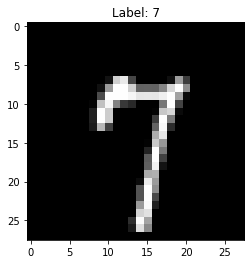

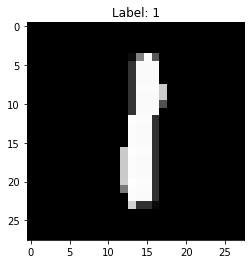

Feature 10 top 3 activations:


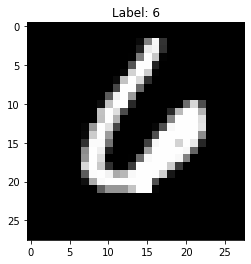

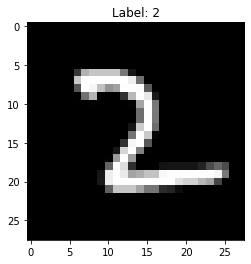

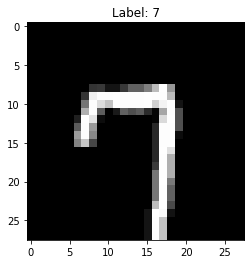

Feature 11 top 3 activations:


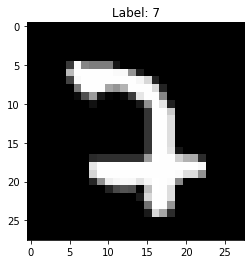

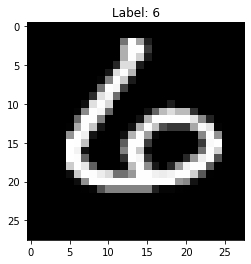

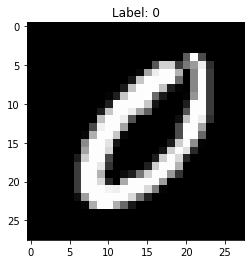

Feature 12 top 3 activations:


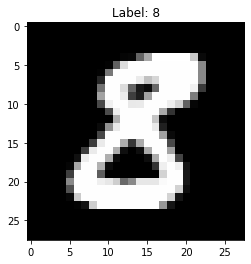

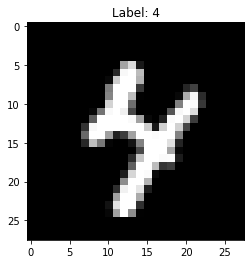

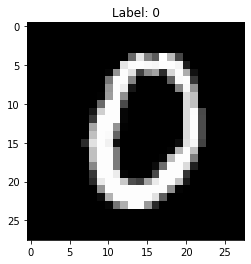

Feature 13 top 3 activations:


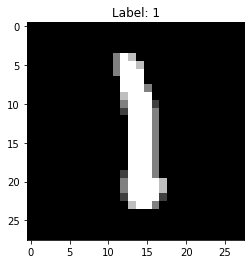

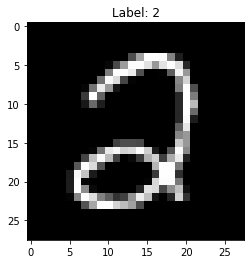

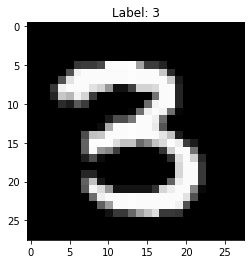

Feature 14 top 3 activations:


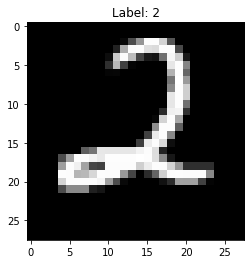

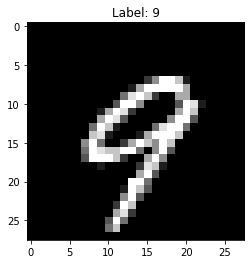

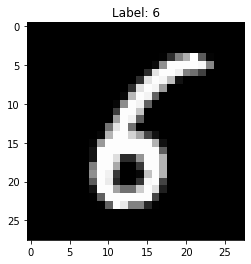

Feature 15 top 3 activations:


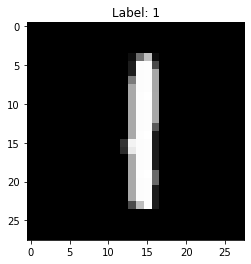

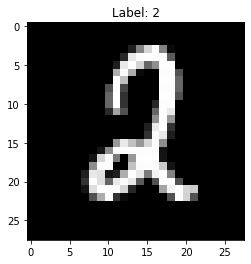

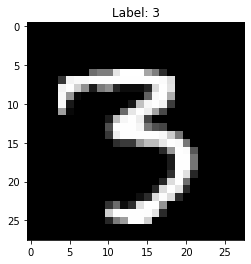

Feature 16 top 3 activations:


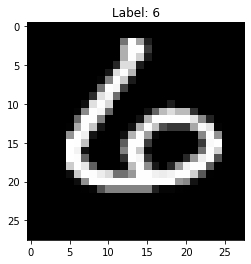

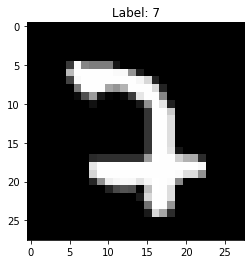

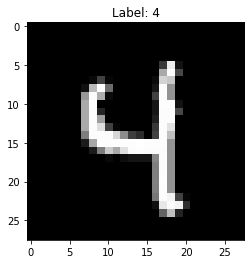

Feature 17 top 3 activations:


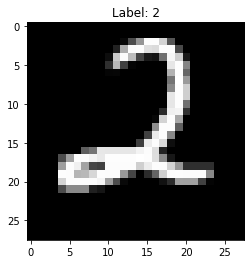

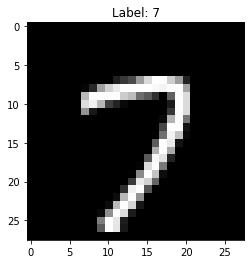

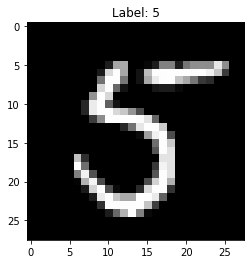

Feature 18 top 3 activations:


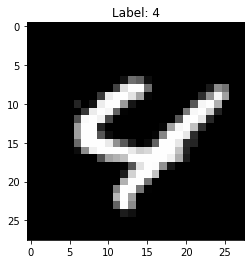

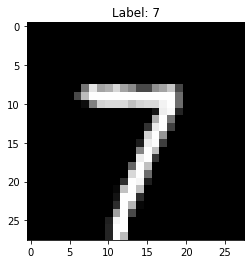

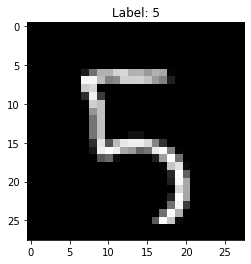

Feature 19 top 3 activations:


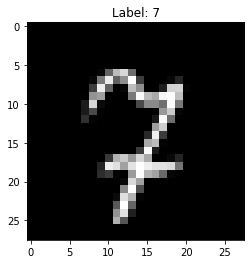

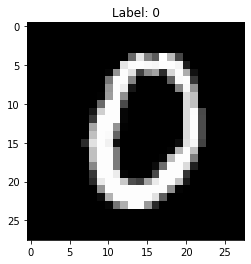

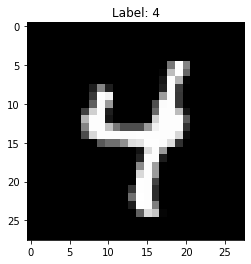

Feature 20 top 3 activations:


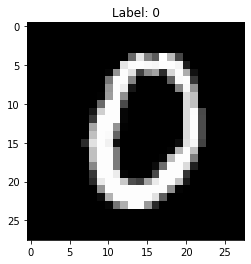

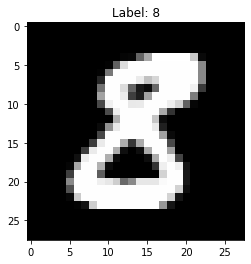

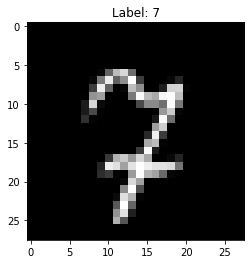

Feature 21 top 3 activations:


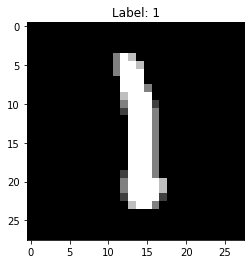

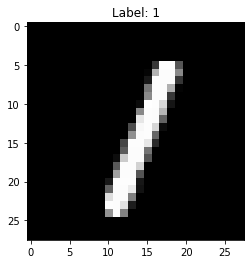

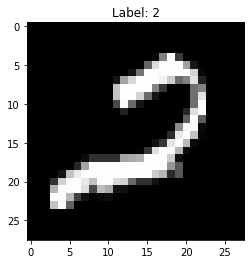

Feature 22 top 3 activations:


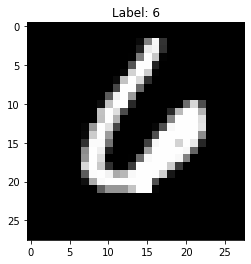

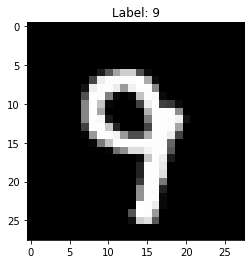

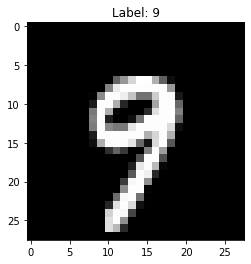

Feature 23 top 3 activations:


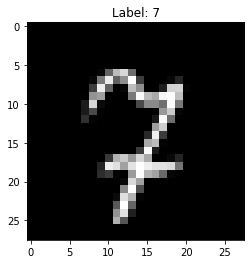

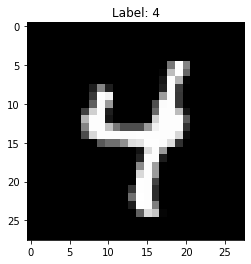

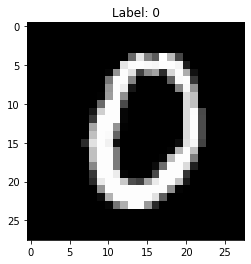

Feature 24 top 3 activations:


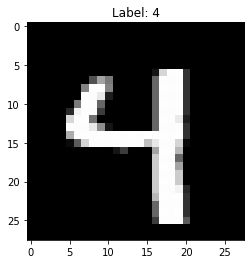

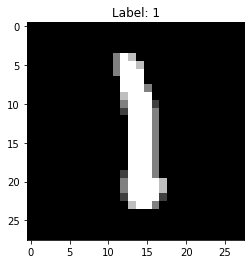

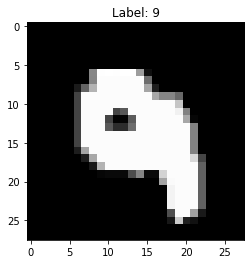

Feature 25 top 3 activations:


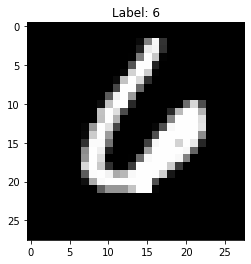

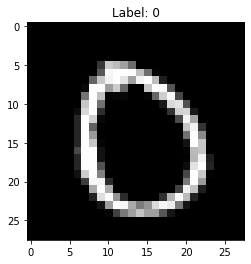

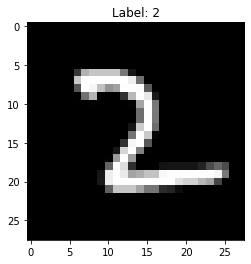

Feature 26 top 3 activations:


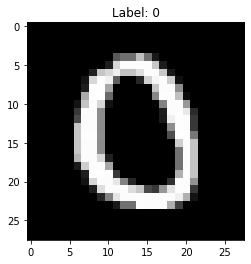

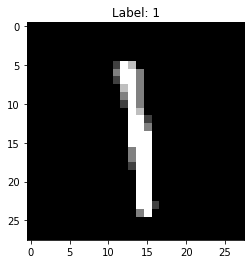

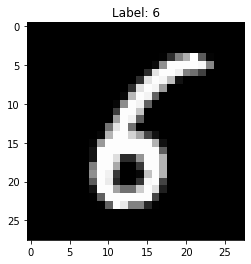

Feature 27 top 3 activations:


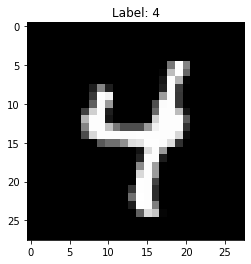

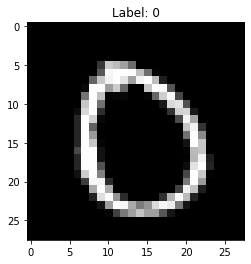

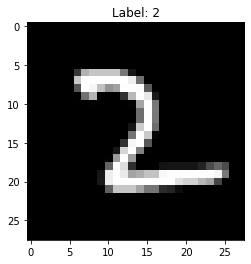

Feature 28 top 3 activations:


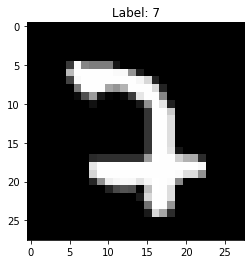

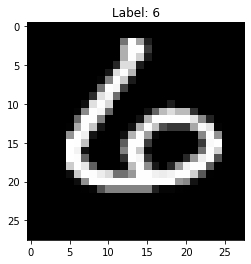

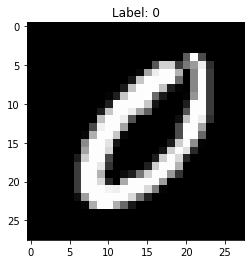

Feature 29 top 3 activations:


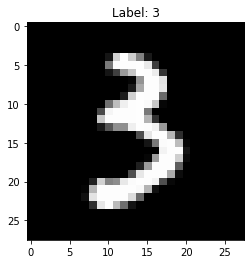

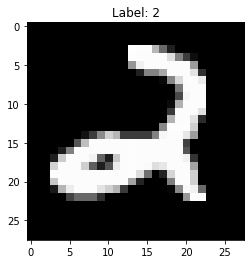

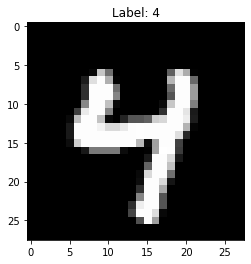

Feature 30 top 3 activations:


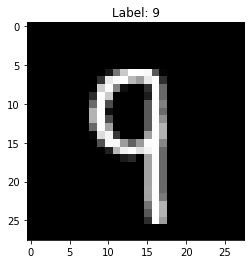

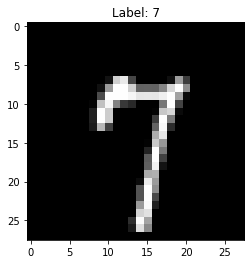

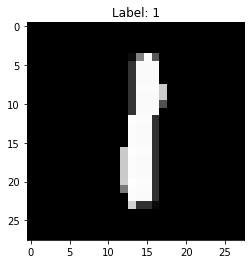

Feature 31 top 3 activations:


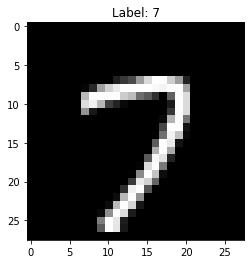

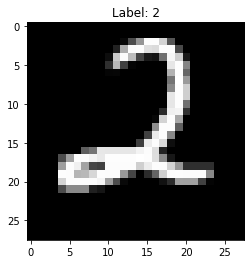

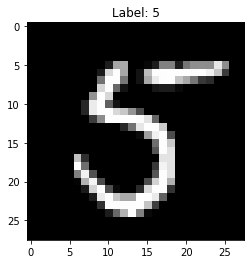

Feature 32 top 3 activations:


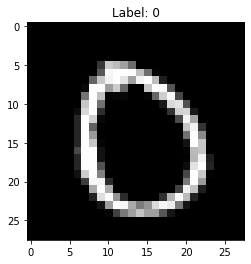

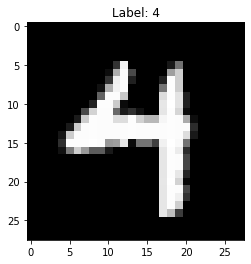

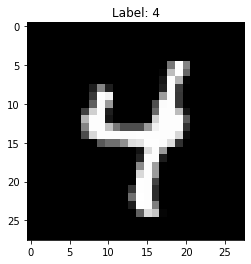

Feature 33 top 3 activations:


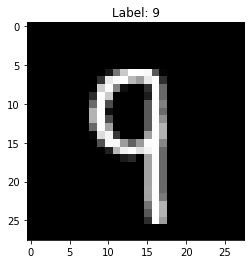

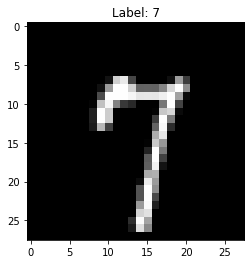

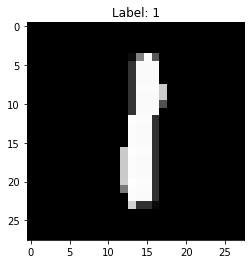

Feature 34 top 3 activations:


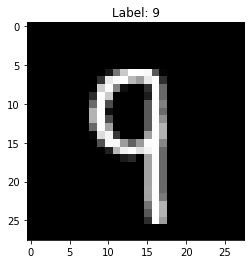

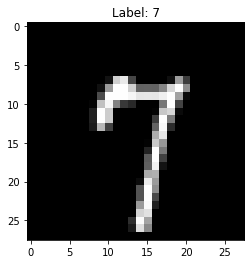

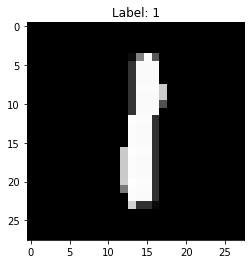

Feature 35 top 3 activations:


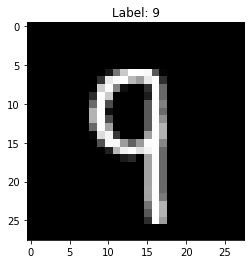

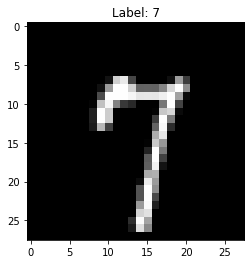

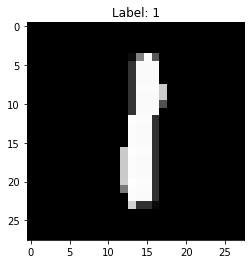

Feature 36 top 3 activations:


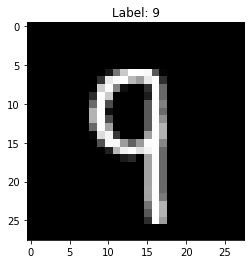

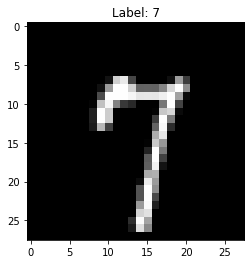

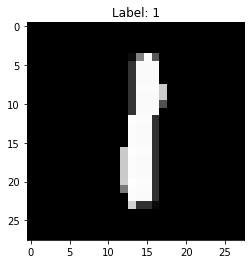

Feature 37 top 3 activations:


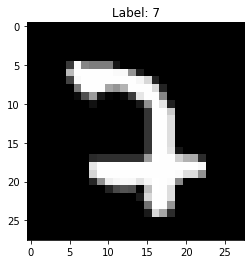

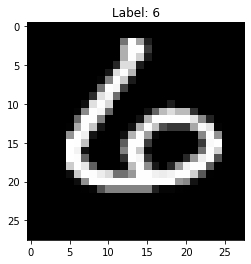

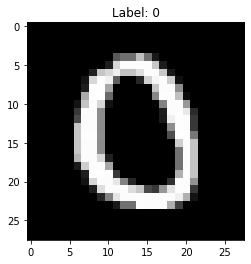

Feature 38 top 3 activations:


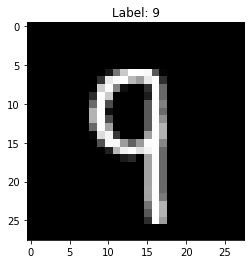

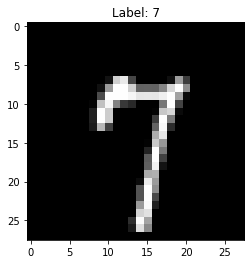

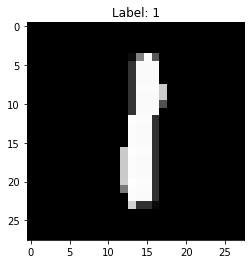

Feature 39 top 3 activations:


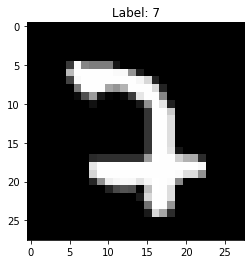

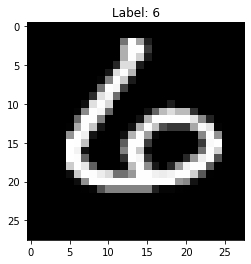

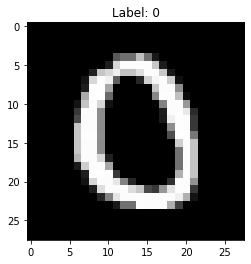

Feature 40 top 3 activations:


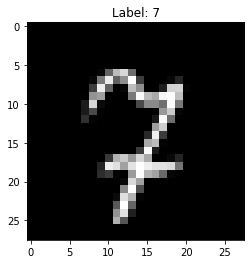

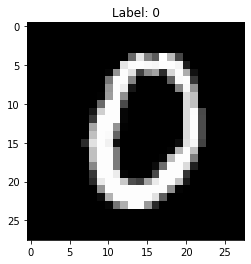

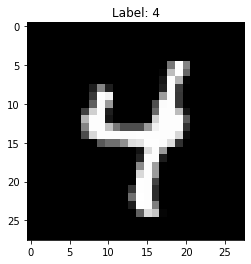

Feature 41 top 3 activations:


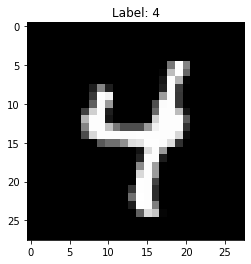

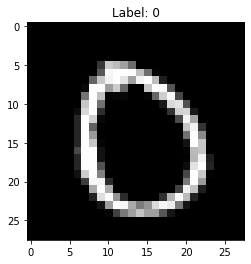

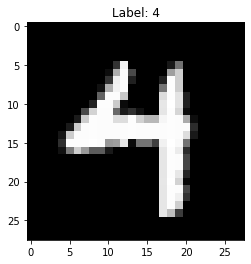

Feature 42 top 3 activations:


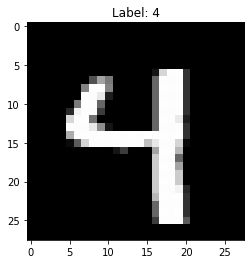

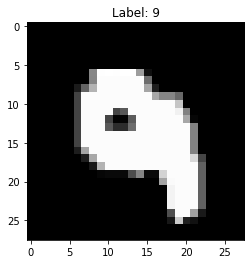

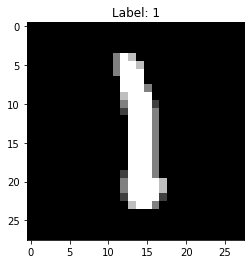

Feature 43 top 3 activations:


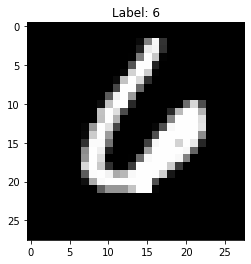

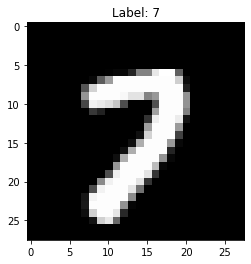

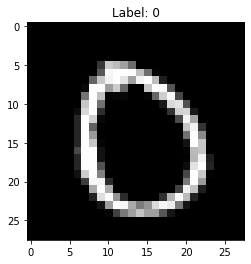

Feature 44 top 3 activations:


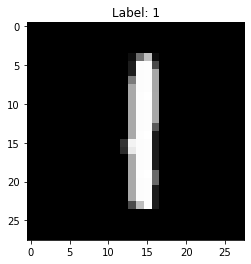

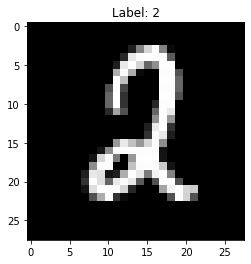

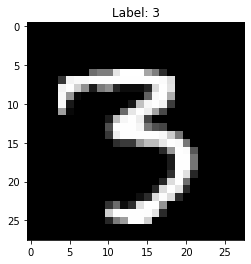

Feature 45 top 3 activations:


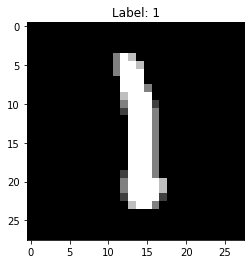

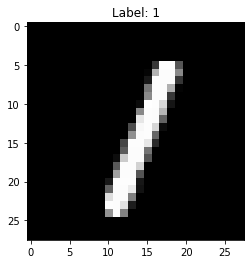

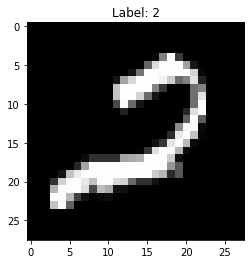

Feature 46 top 3 activations:


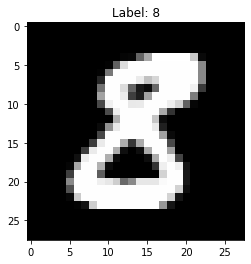

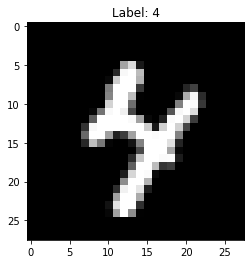

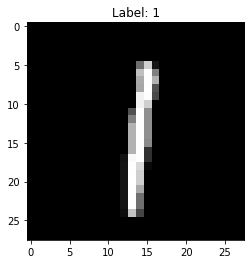

Feature 47 top 3 activations:


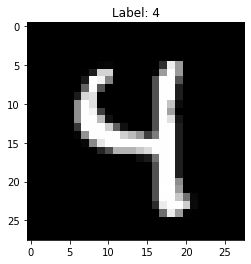

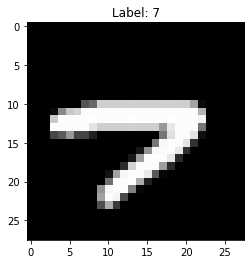

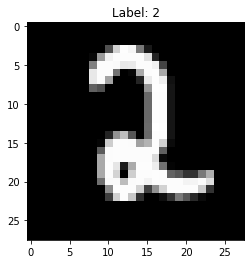

Feature 48 top 3 activations:


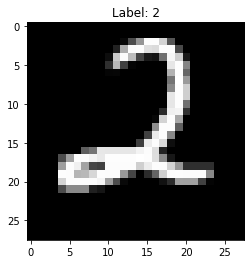

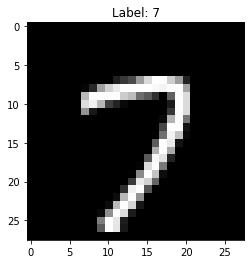

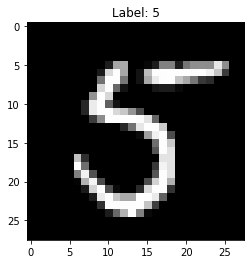

Feature 49 top 3 activations:


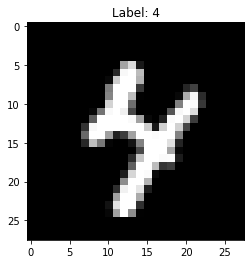

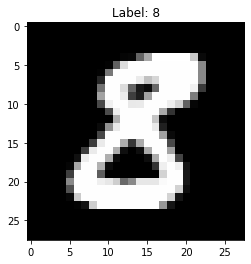

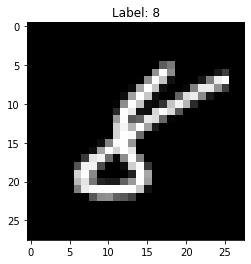

Feature 50 top 3 activations:


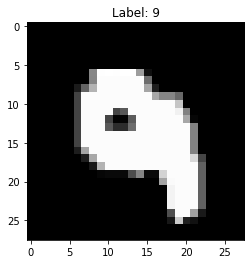

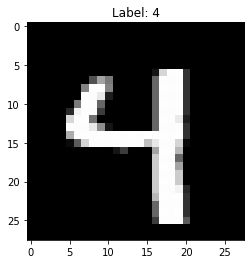

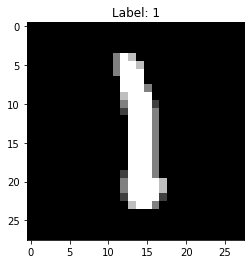

Feature 51 top 3 activations:


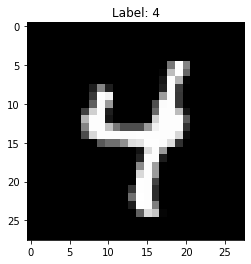

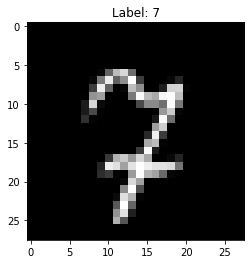

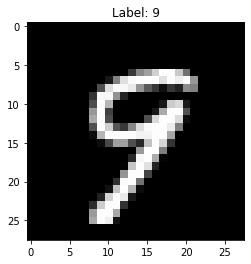

Feature 52 top 3 activations:


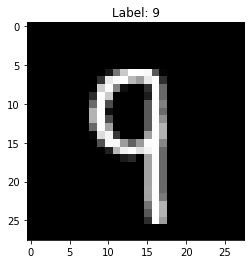

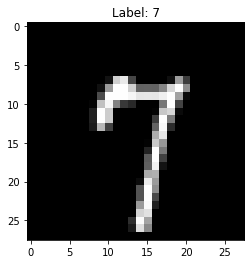

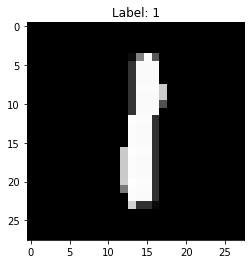

Feature 53 top 3 activations:


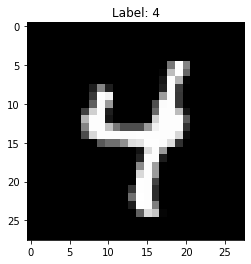

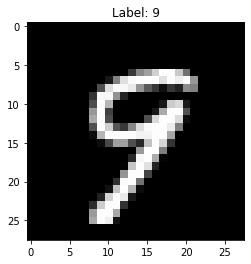

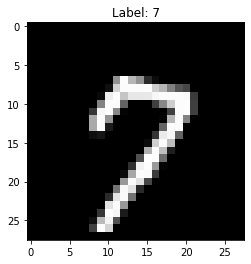

Feature 54 top 3 activations:


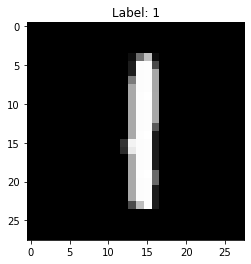

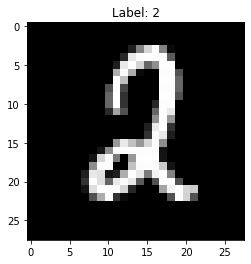

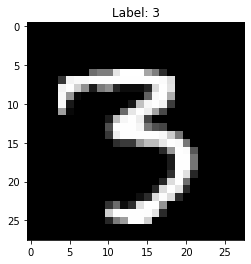

Feature 55 top 3 activations:


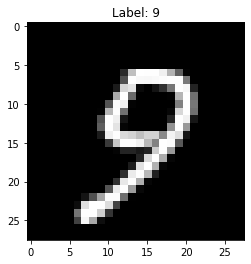

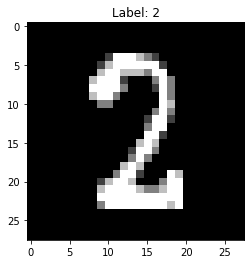

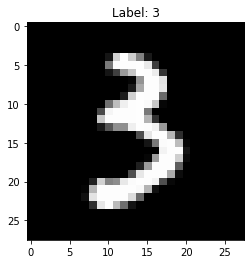

Feature 56 top 3 activations:


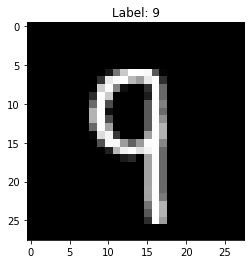

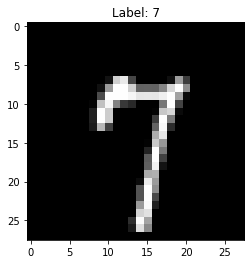

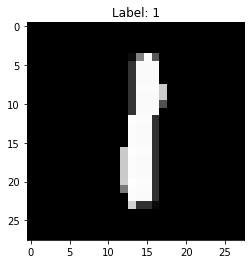

Feature 57 top 3 activations:


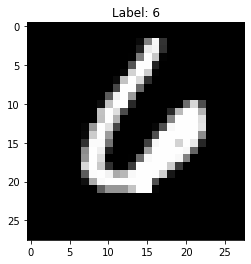

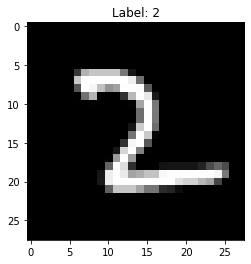

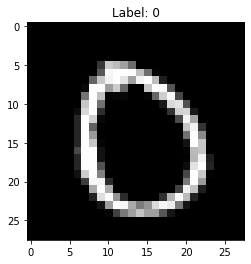

Feature 58 top 3 activations:


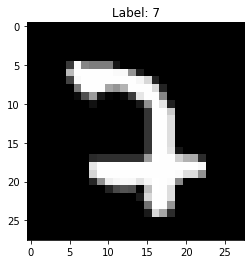

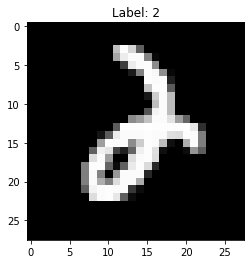

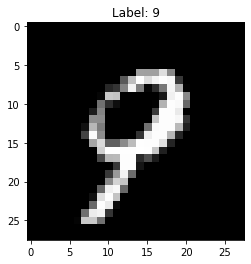

Feature 59 top 3 activations:


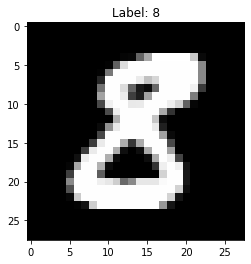

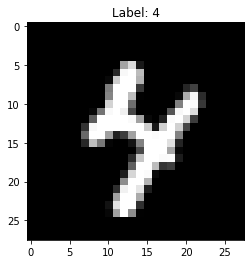

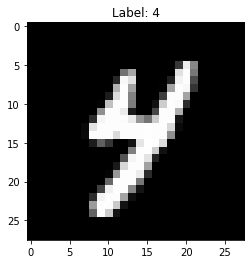

Feature 60 top 3 activations:


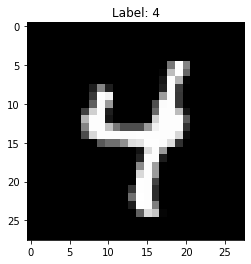

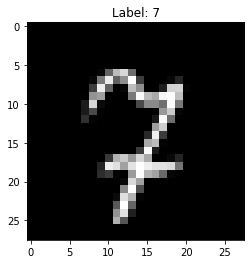

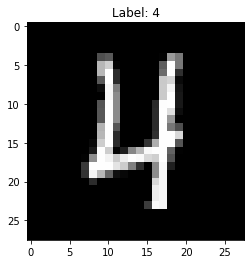

Feature 61 top 3 activations:


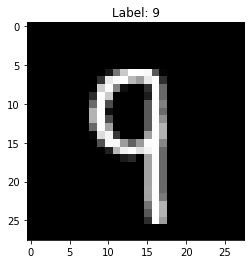

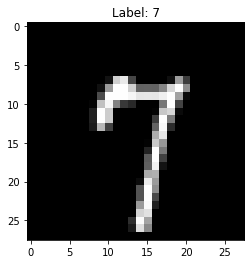

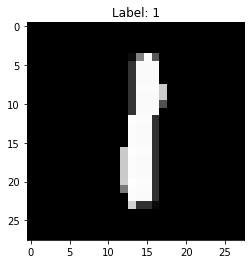

Feature 62 top 3 activations:


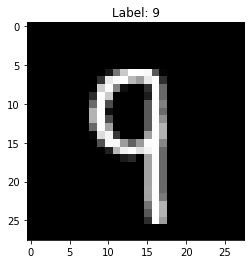

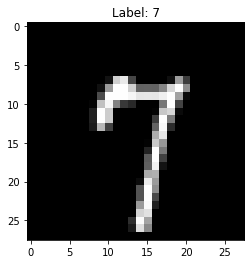

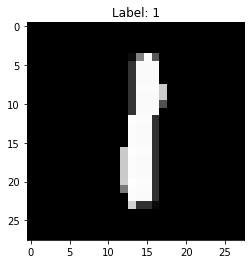

Feature 63 top 3 activations:


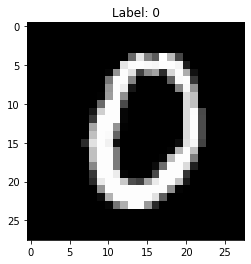

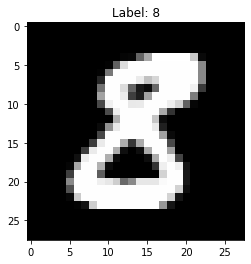

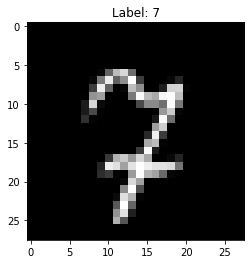

Feature 64 top 3 activations:


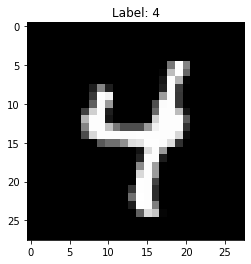

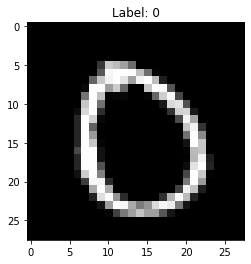

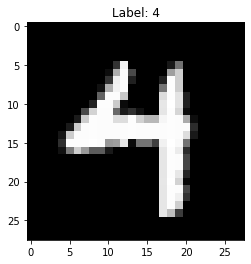

Feature 65 top 3 activations:


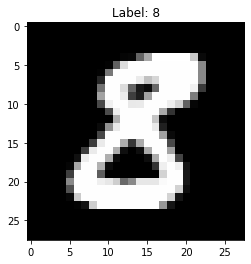

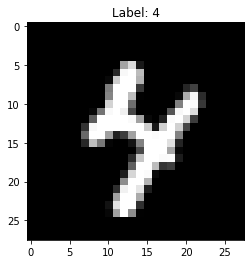

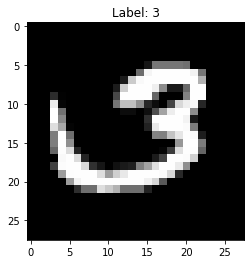

Feature 66 top 3 activations:


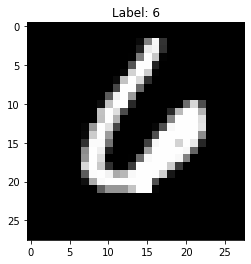

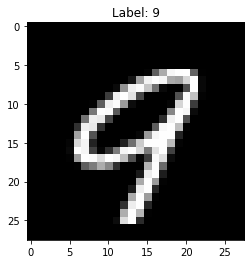

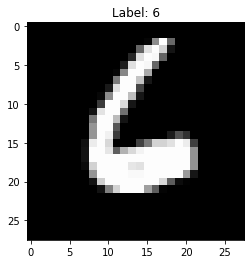

Feature 67 top 3 activations:


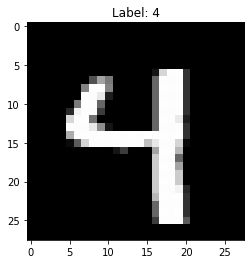

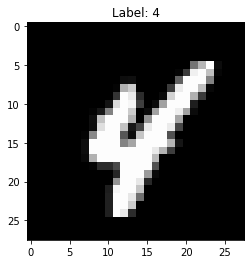

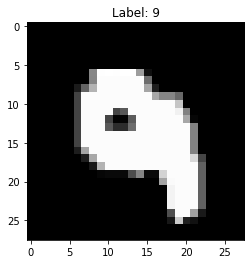

Feature 68 top 3 activations:


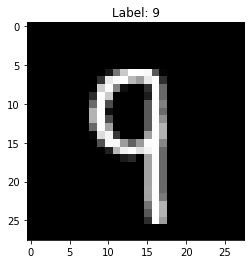

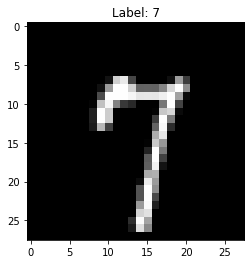

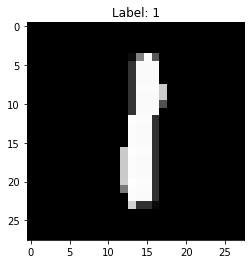

Feature 69 top 3 activations:


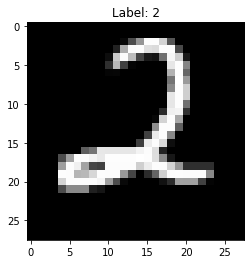

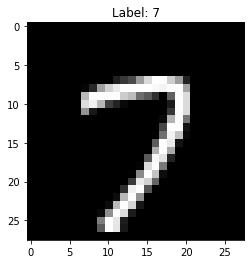

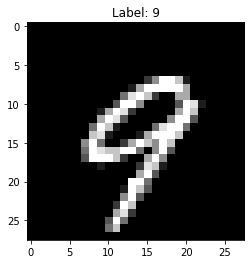

Feature 70 top 3 activations:


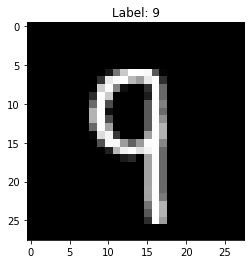

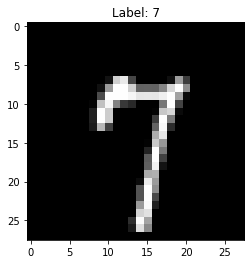

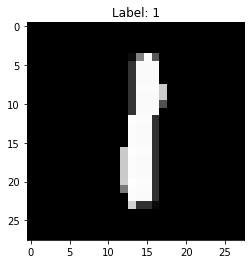

Feature 71 top 3 activations:


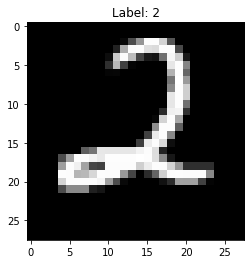

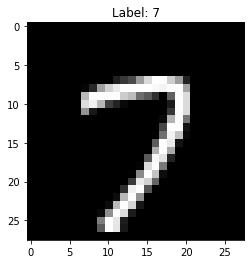

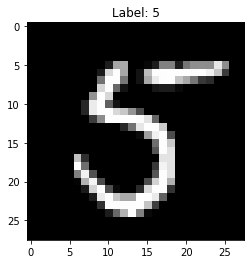

Feature 72 top 3 activations:


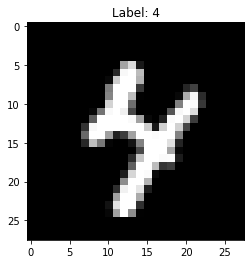

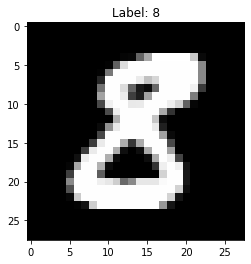

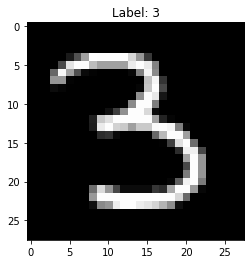

Feature 73 top 3 activations:


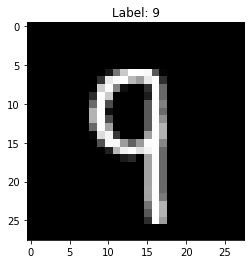

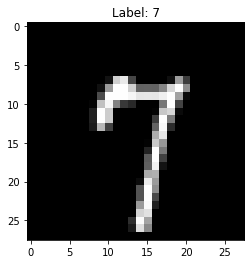

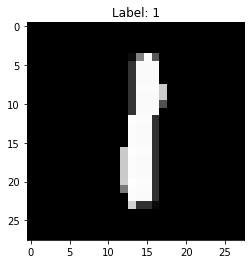

Feature 74 top 3 activations:


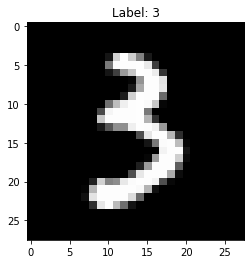

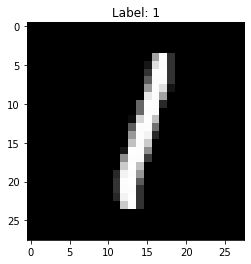

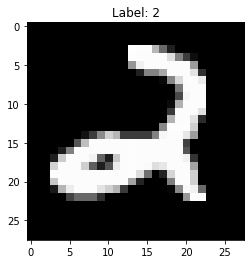

Feature 75 top 3 activations:


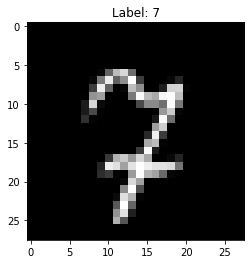

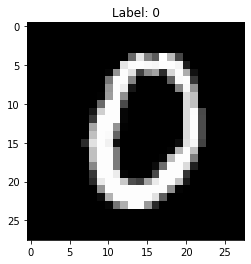

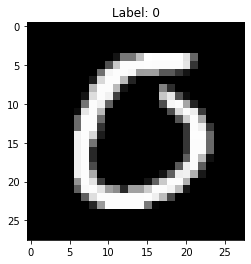

Feature 76 top 3 activations:


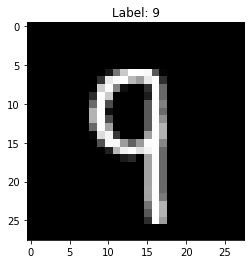

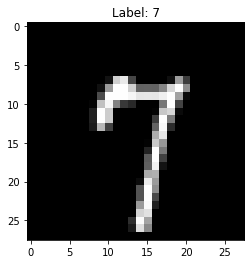

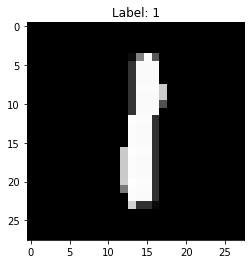

Feature 77 top 3 activations:


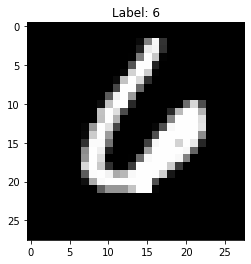

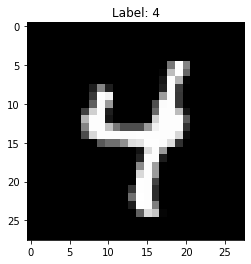

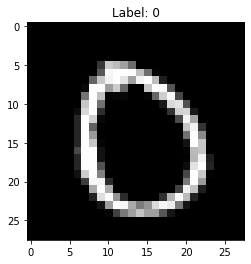

Feature 78 top 3 activations:


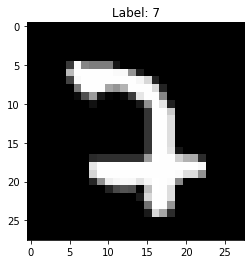

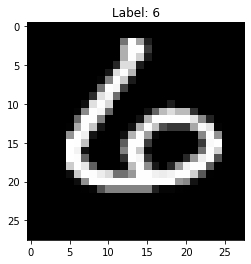

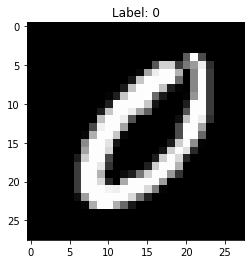

Feature 79 top 3 activations:


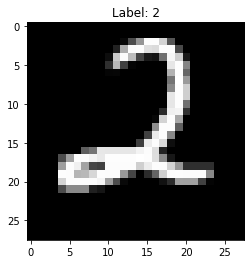

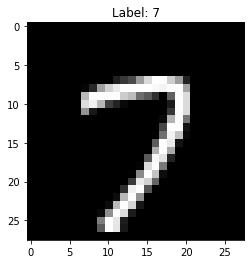

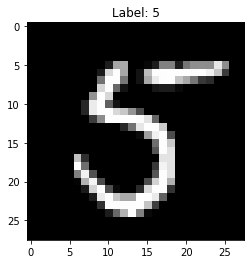

Feature 80 top 3 activations:


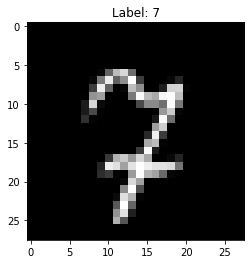

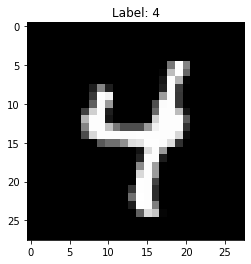

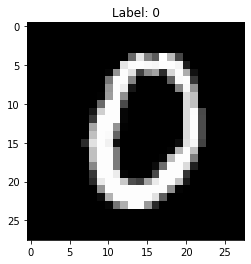

Feature 81 top 3 activations:


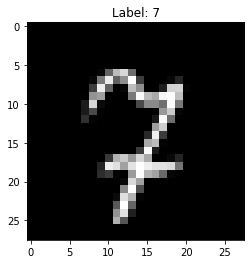

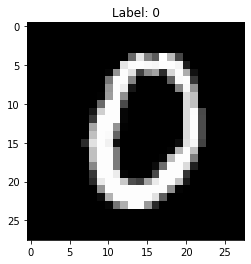

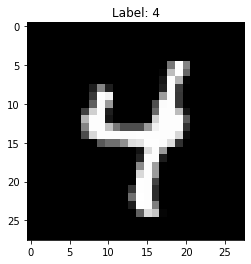

Feature 82 top 3 activations:


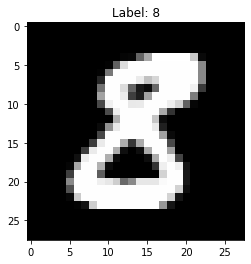

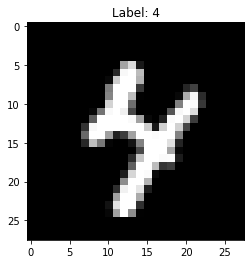

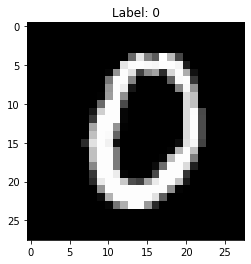

Feature 83 top 3 activations:


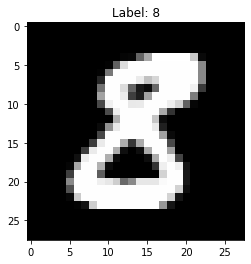

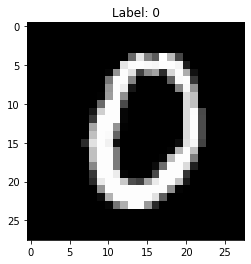

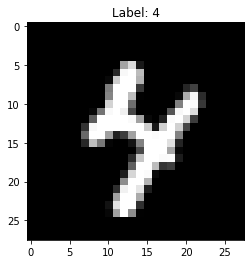

Feature 84 top 3 activations:


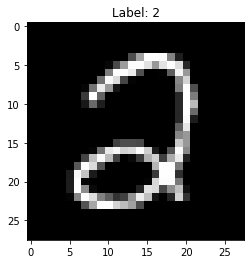

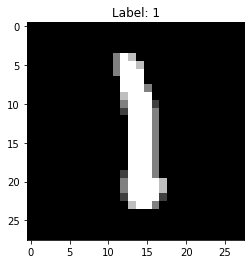

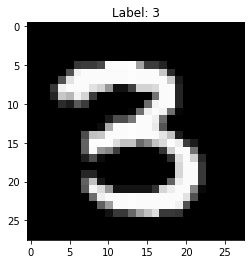

Feature 85 top 3 activations:


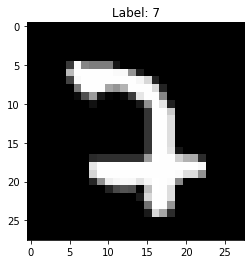

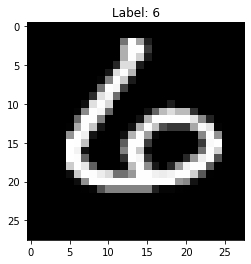

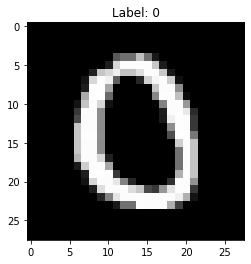

Feature 86 top 3 activations:


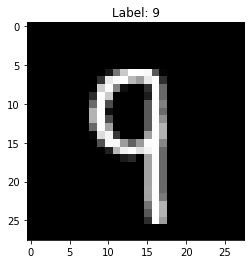

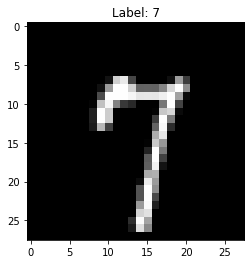

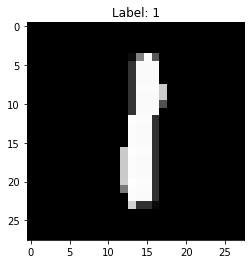

Feature 87 top 3 activations:


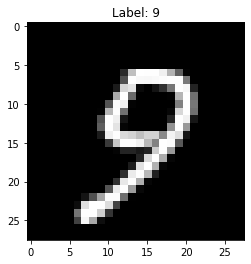

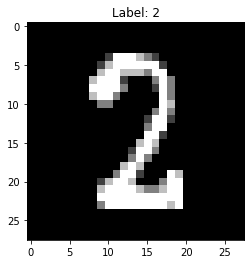

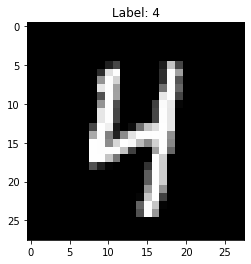

Feature 88 top 3 activations:


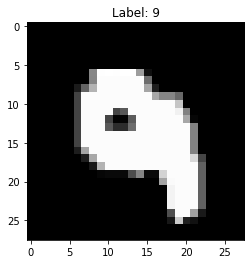

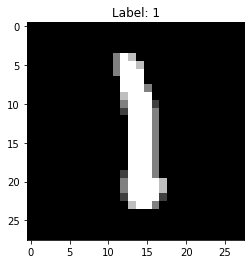

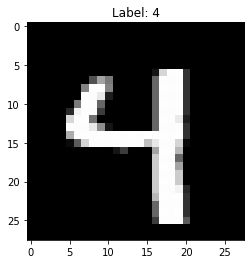

Feature 89 top 3 activations:


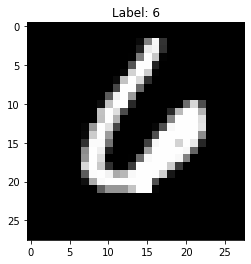

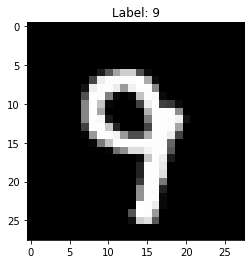

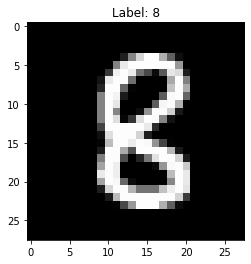

Feature 90 top 3 activations:


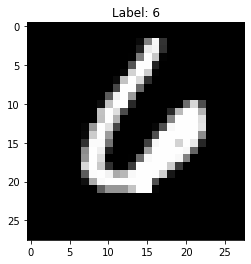

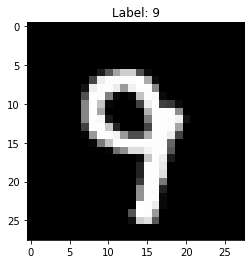

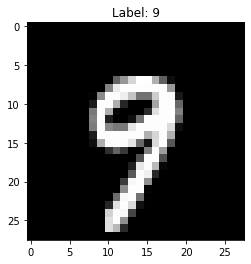

Feature 91 top 3 activations:


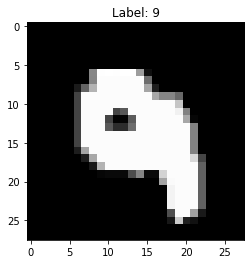

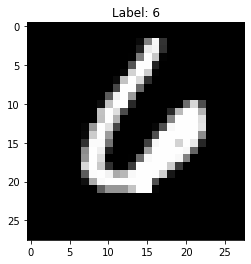

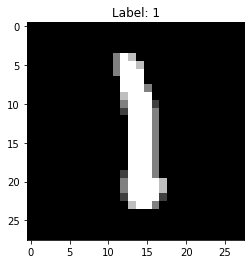

Feature 92 top 3 activations:


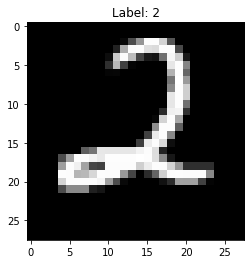

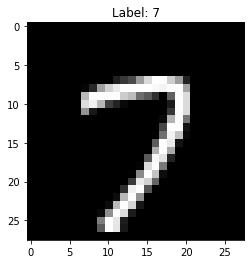

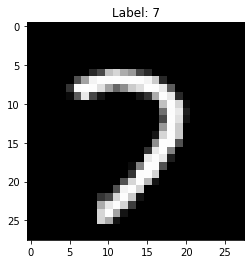

Feature 93 top 3 activations:


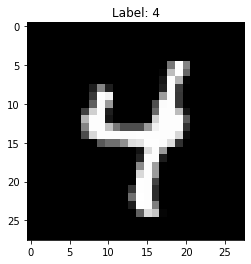

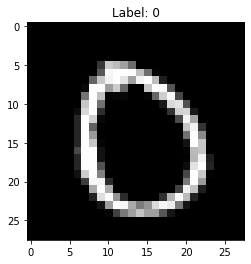

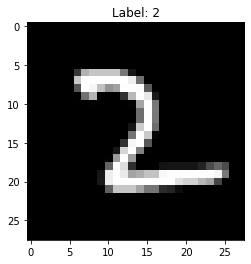

Feature 94 top 3 activations:


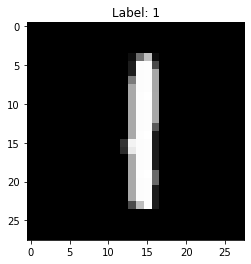

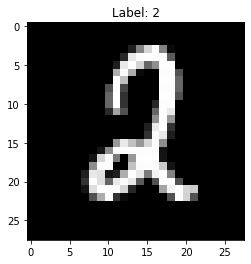

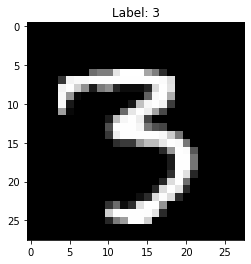

Feature 95 top 3 activations:


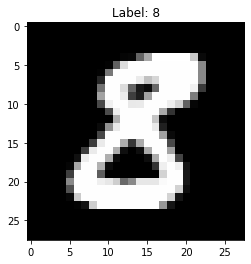

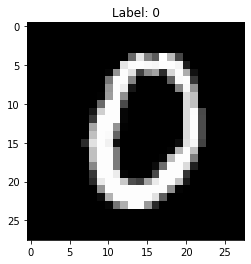

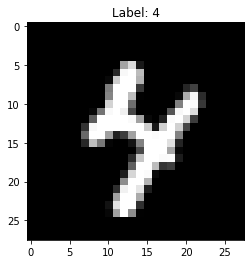

Feature 96 top 3 activations:


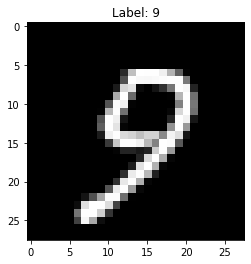

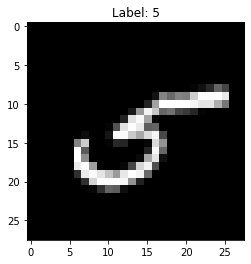

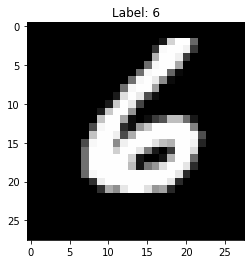

Feature 97 top 3 activations:


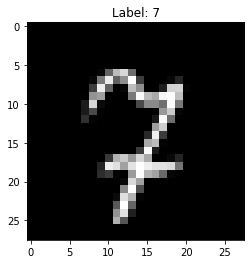

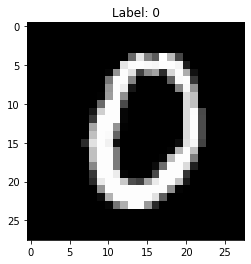

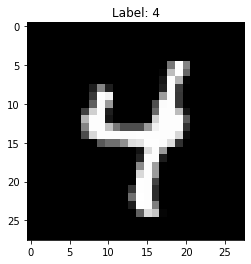

Feature 98 top 3 activations:


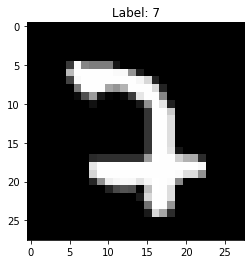

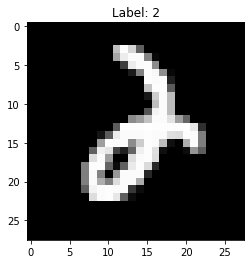

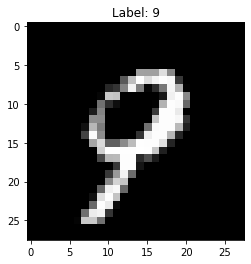

Feature 99 top 3 activations:


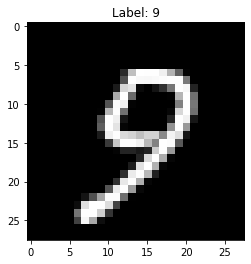

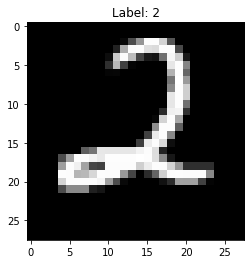

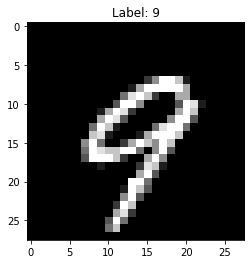

Feature 100 top 3 activations:


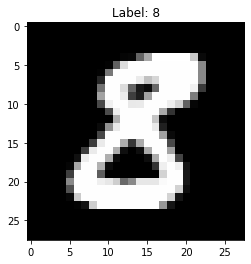

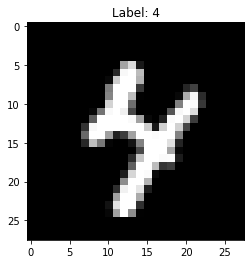

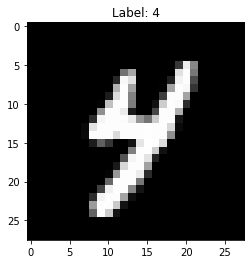

Feature 101 top 3 activations:


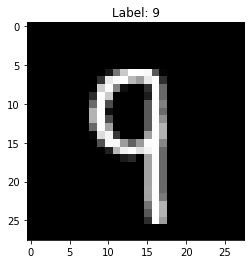

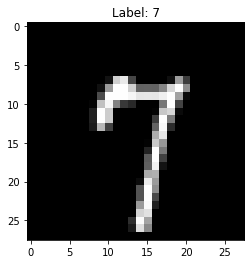

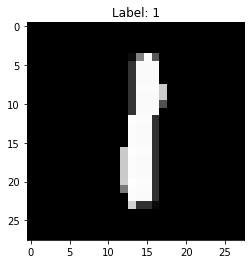

Feature 102 top 3 activations:


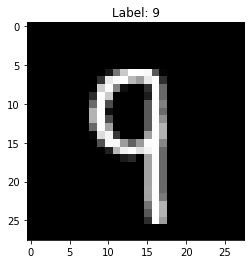

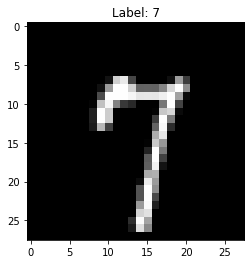

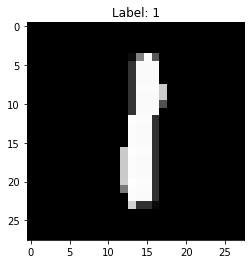

Feature 103 top 3 activations:


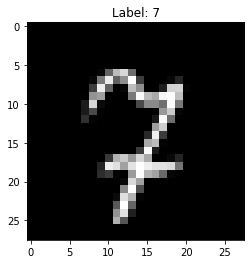

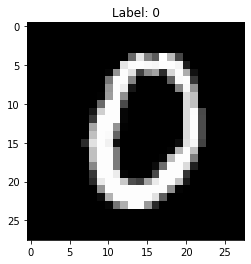

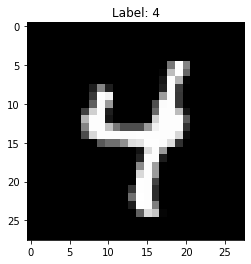

Feature 104 top 3 activations:


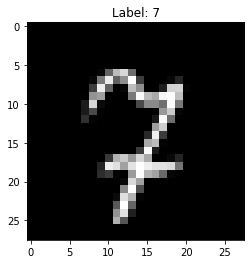

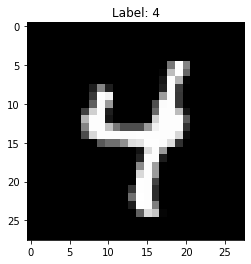

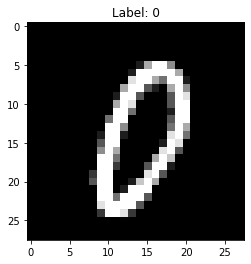

Feature 105 top 3 activations:


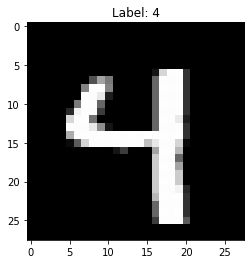

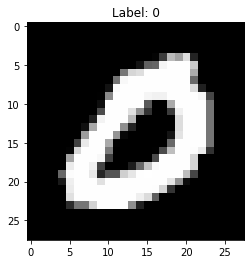

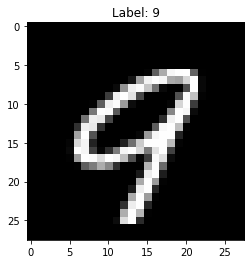

Feature 106 top 3 activations:


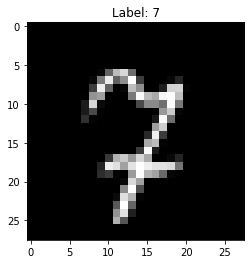

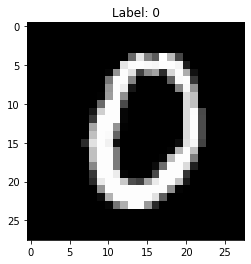

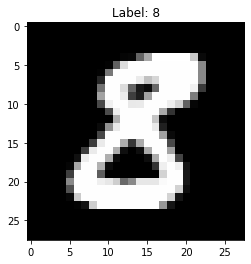

Feature 107 top 3 activations:


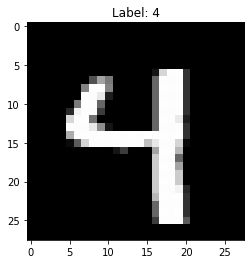

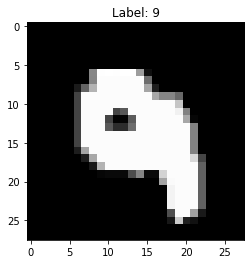

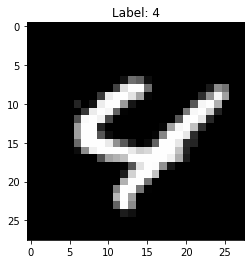

Feature 108 top 3 activations:


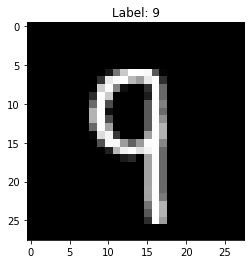

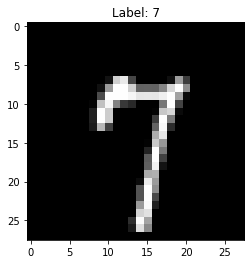

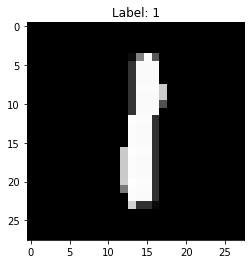

Feature 109 top 3 activations:


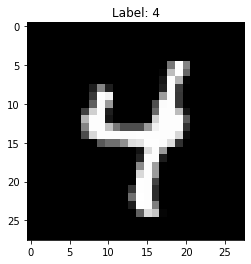

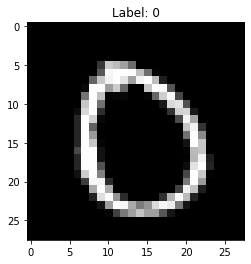

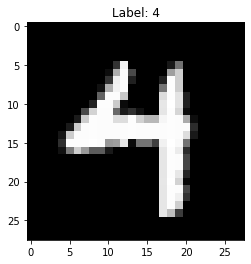

Feature 110 top 3 activations:


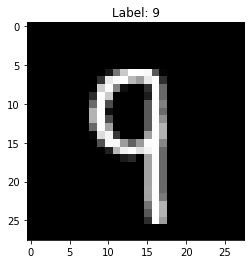

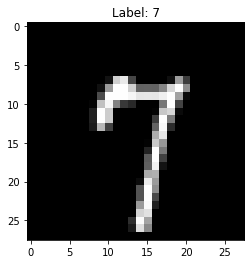

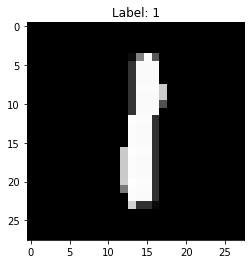

Feature 111 top 3 activations:


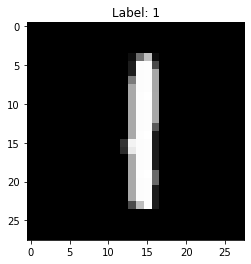

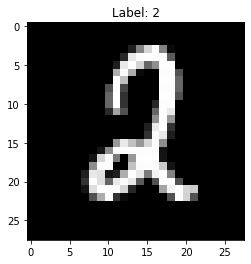

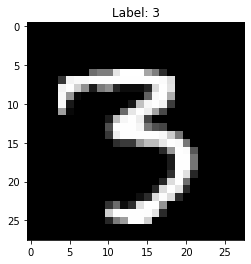

Feature 112 top 3 activations:


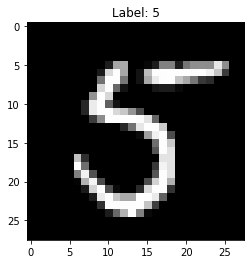

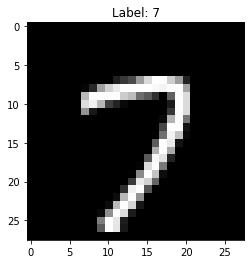

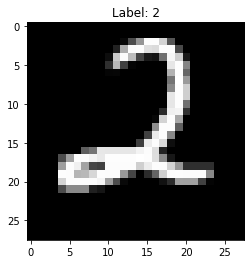

Feature 113 top 3 activations:


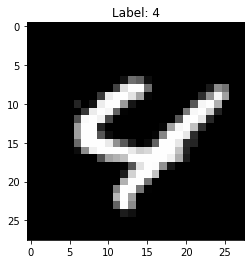

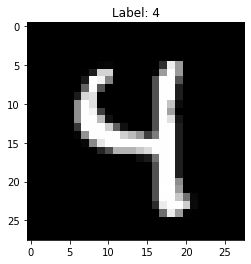

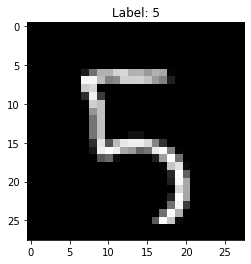

Feature 114 top 3 activations:


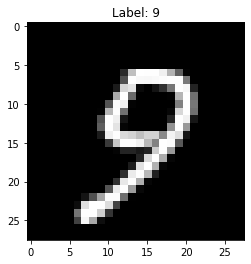

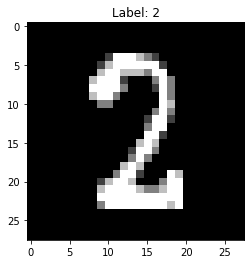

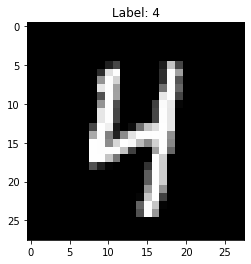

Feature 115 top 3 activations:


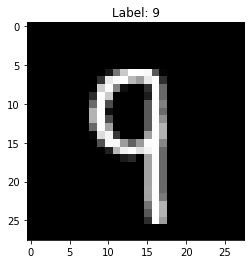

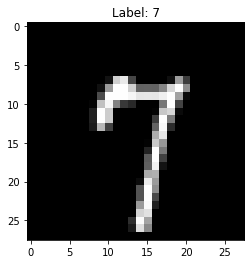

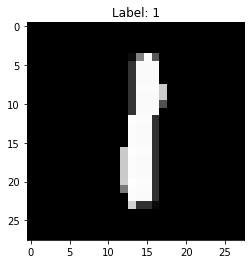

Feature 116 top 3 activations:


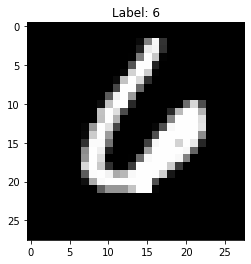

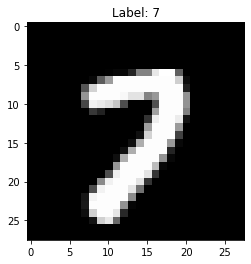

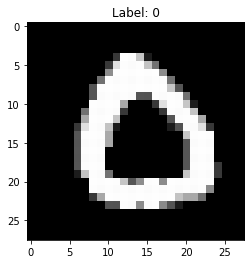

Feature 117 top 3 activations:


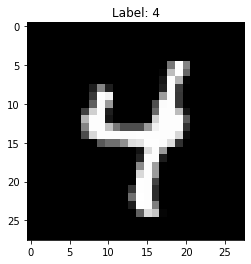

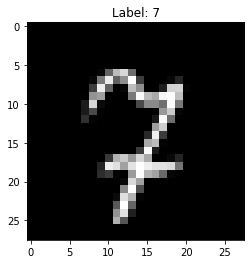

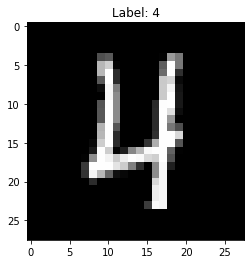

Feature 118 top 3 activations:


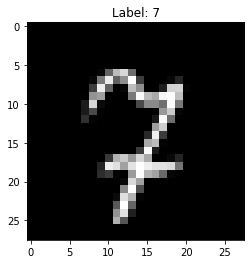

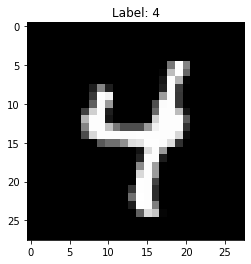

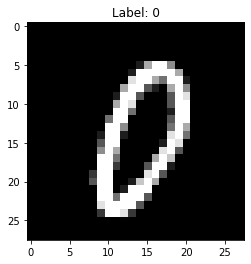

Feature 119 top 3 activations:


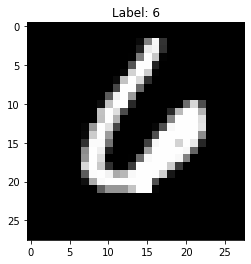

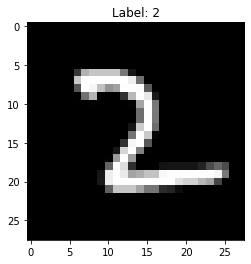

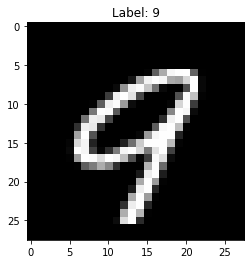

Feature 120 top 3 activations:


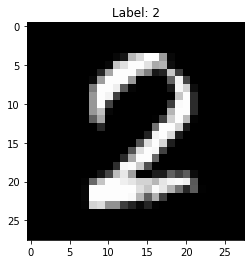

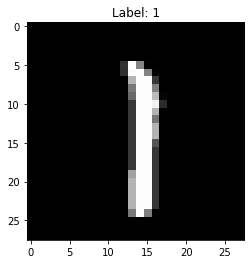

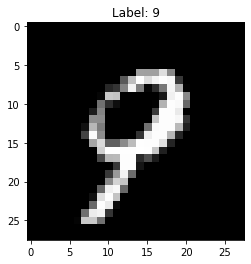

Feature 121 top 3 activations:


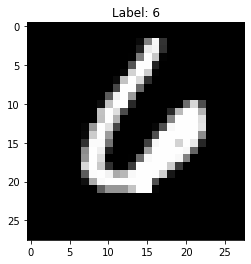

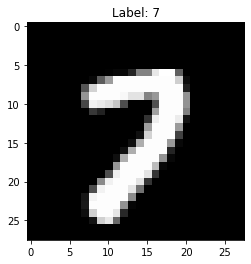

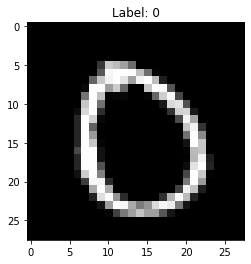

Feature 122 top 3 activations:


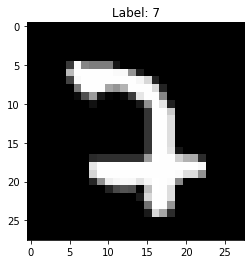

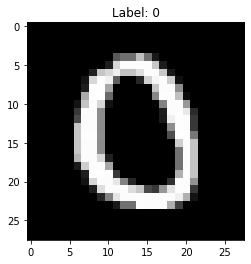

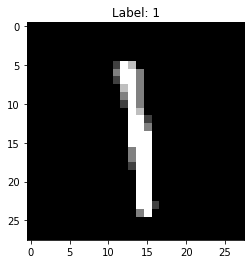

Feature 123 top 3 activations:


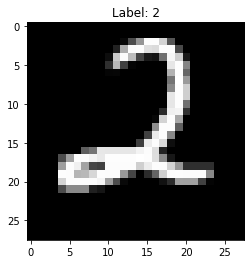

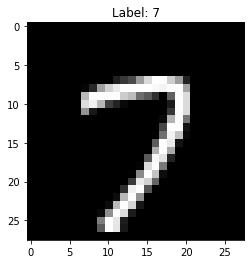

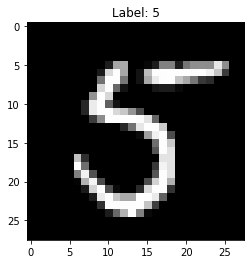

Feature 124 top 3 activations:


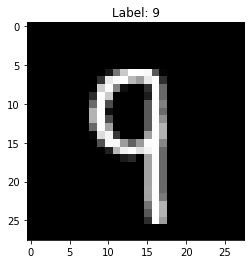

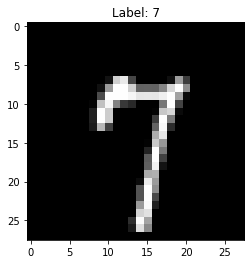

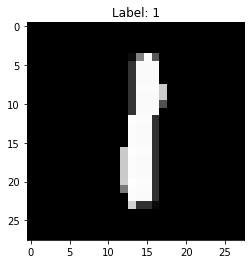

Feature 125 top 3 activations:


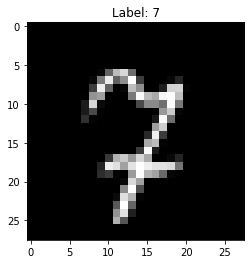

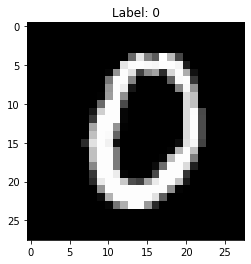

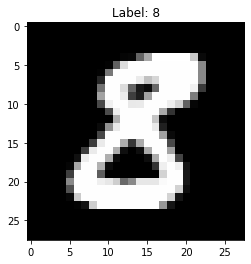

Feature 126 top 3 activations:


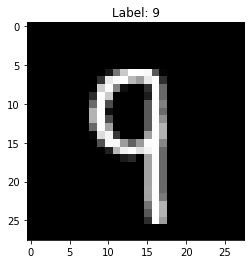

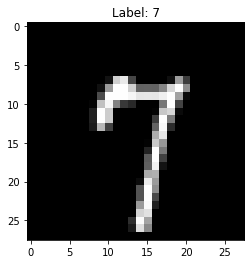

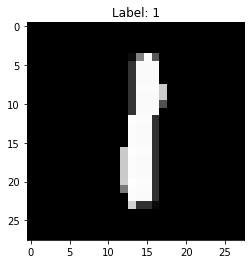

Feature 127 top 3 activations:


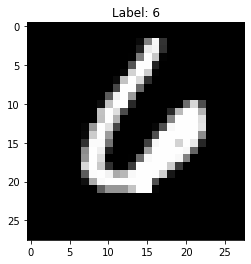

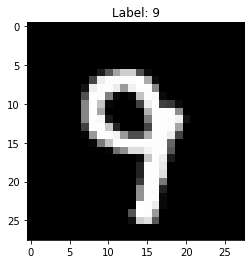

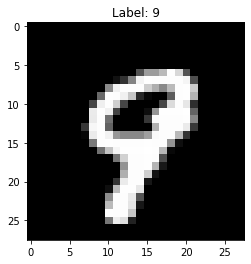

Feature 128 top 3 activations:


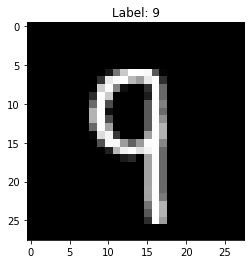

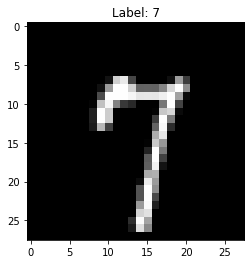

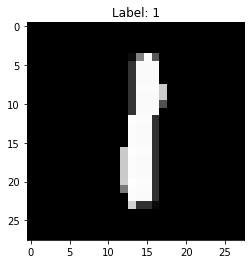

Feature 129 top 3 activations:


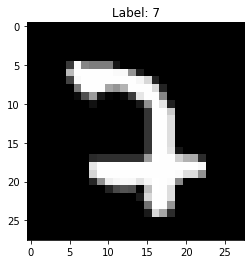

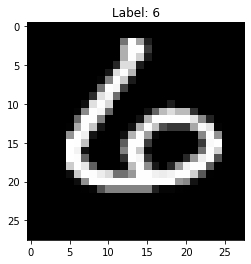

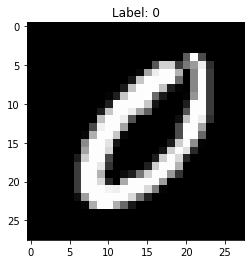

Feature 130 top 3 activations:


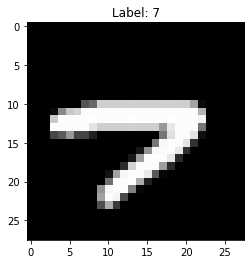

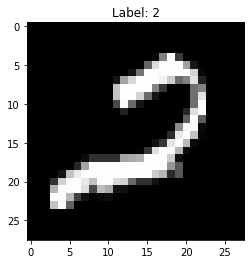

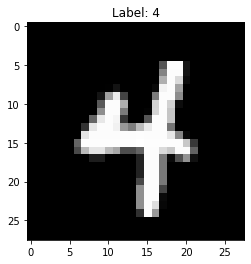

Feature 131 top 3 activations:


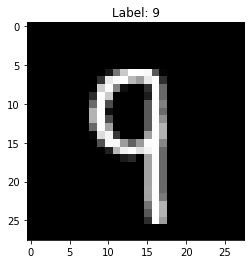

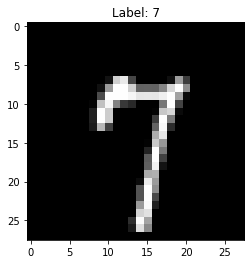

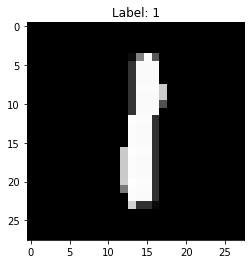

Feature 132 top 3 activations:


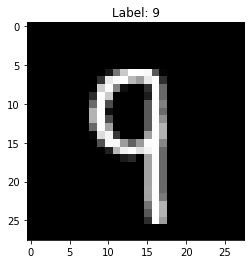

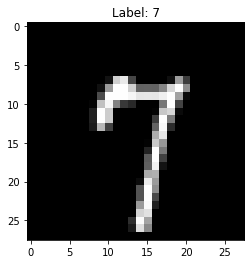

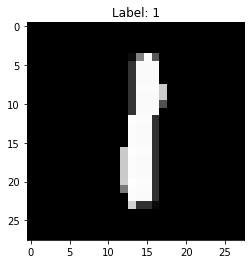

Feature 133 top 3 activations:


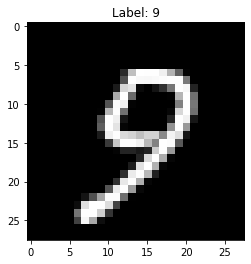

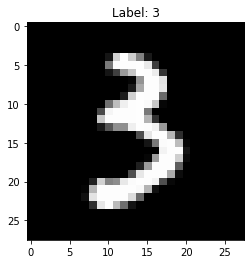

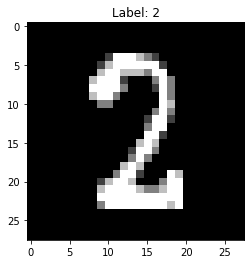

Feature 134 top 3 activations:


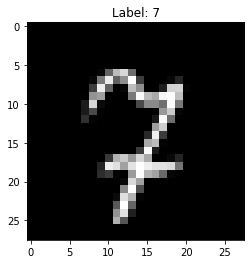

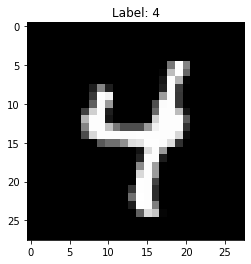

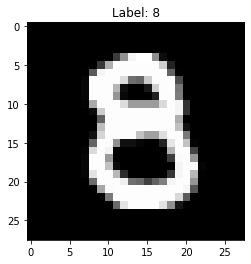

Feature 135 top 3 activations:


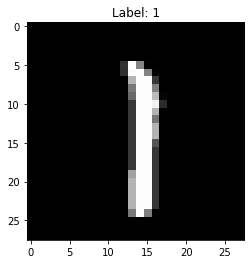

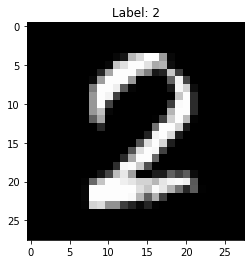

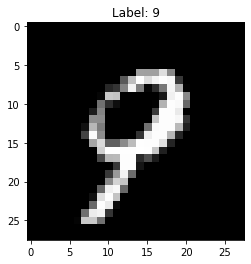

Feature 136 top 3 activations:


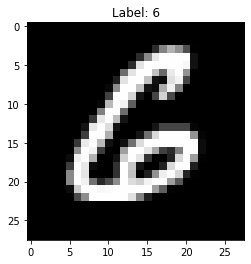

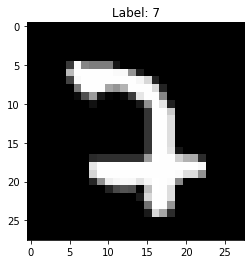

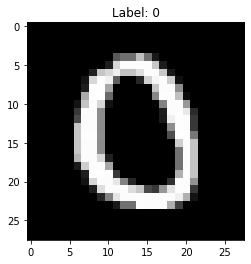

Feature 137 top 3 activations:


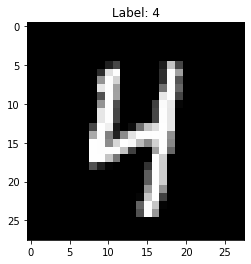

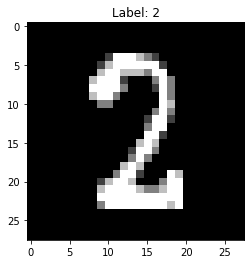

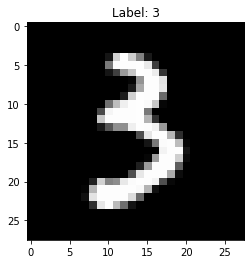

Feature 138 top 3 activations:


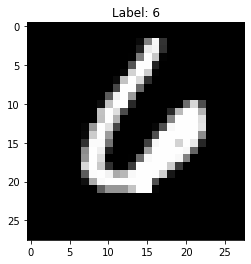

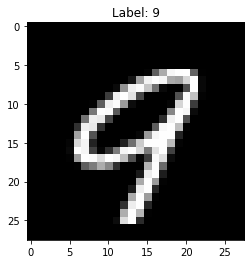

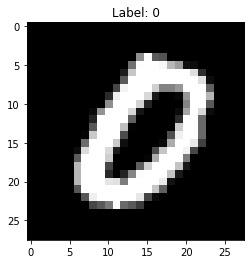

Feature 139 top 3 activations:


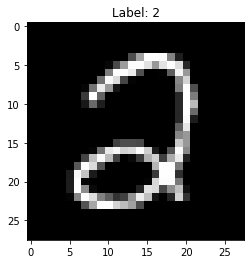

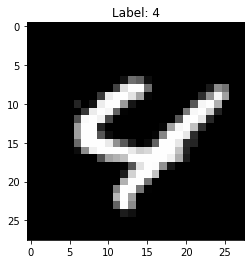

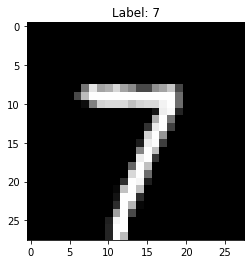

Feature 140 top 3 activations:


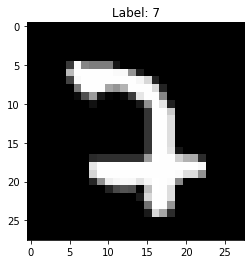

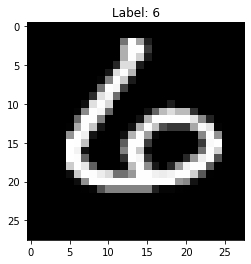

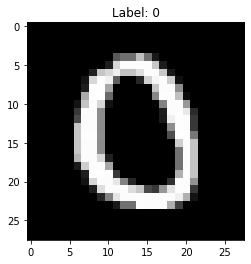

Feature 141 top 3 activations:


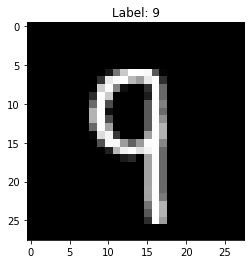

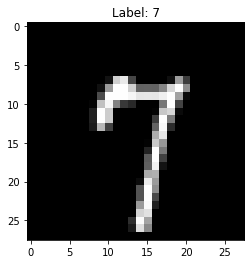

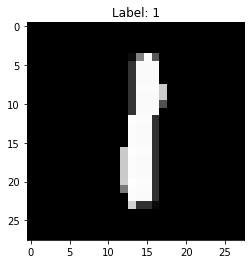

Feature 142 top 3 activations:


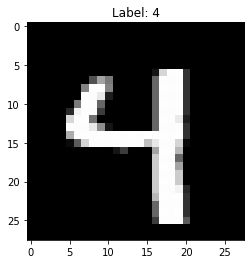

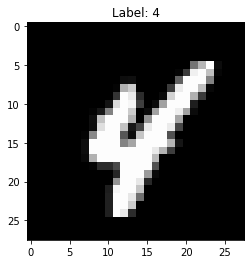

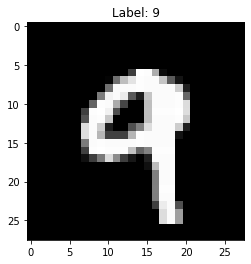

Feature 143 top 3 activations:


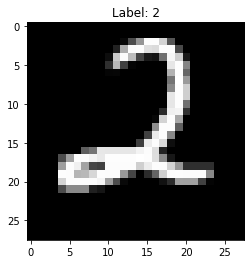

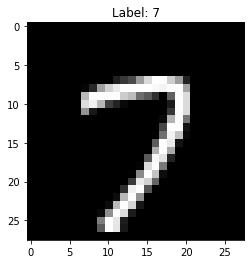

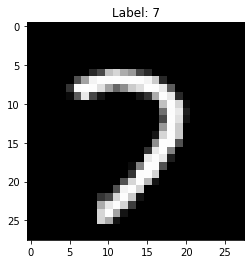

Feature 144 top 3 activations:


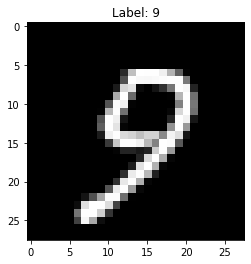

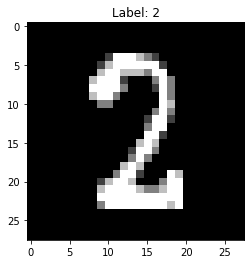

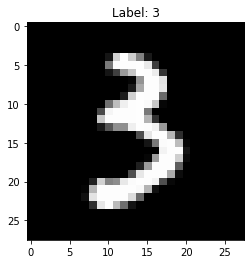

Feature 145 top 3 activations:


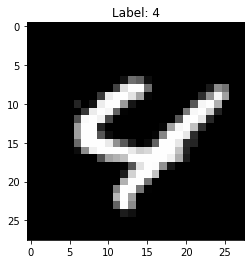

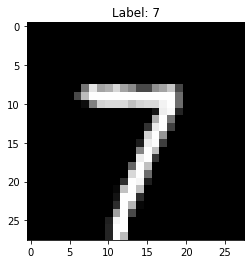

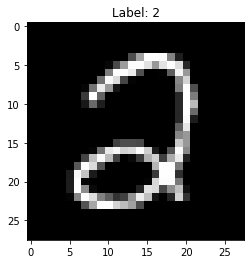

Feature 146 top 3 activations:


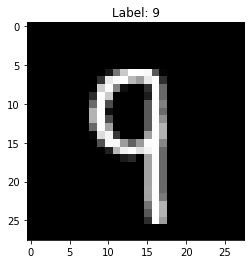

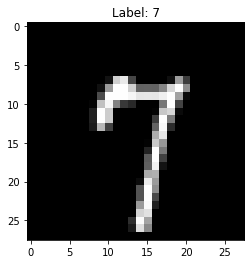

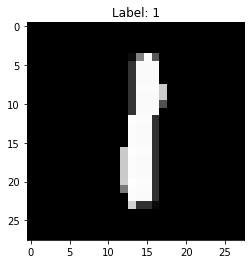

Feature 147 top 3 activations:


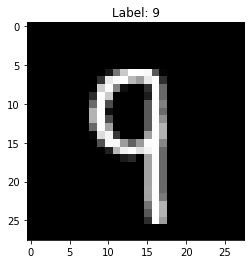

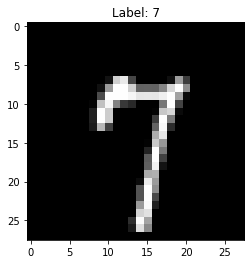

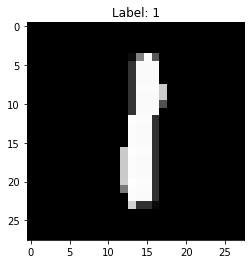

Feature 148 top 3 activations:


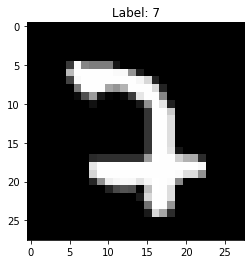

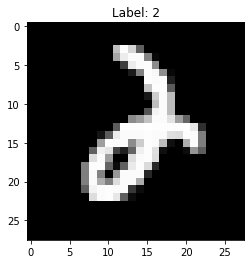

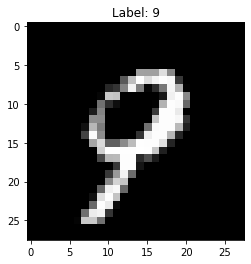

Feature 149 top 3 activations:


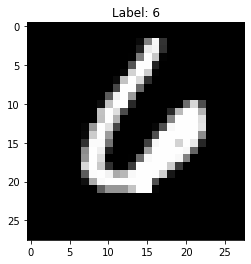

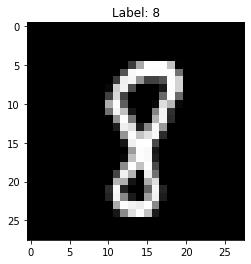

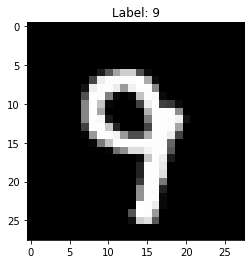

Feature 150 top 3 activations:


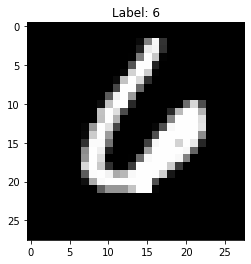

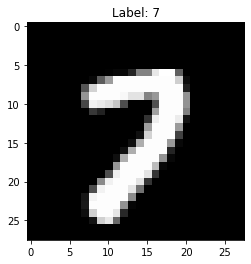

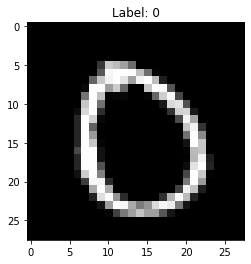

Feature 151 top 3 activations:


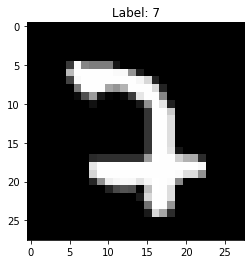

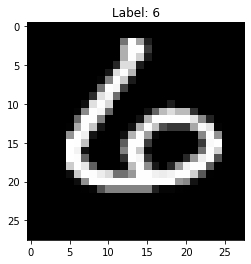

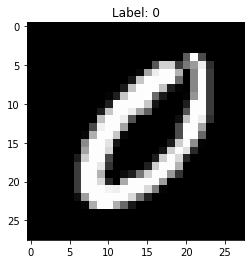

Feature 152 top 3 activations:


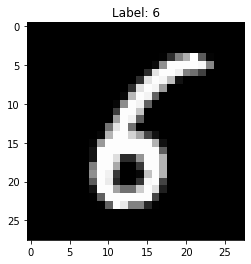

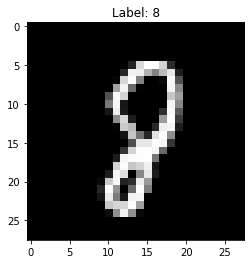

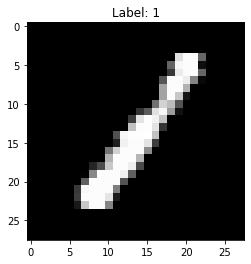

Feature 153 top 3 activations:


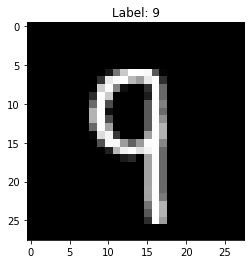

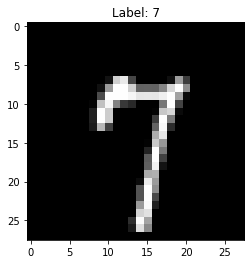

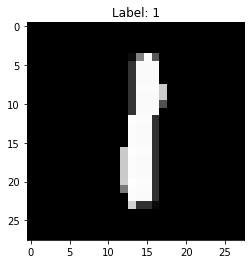

Feature 154 top 3 activations:


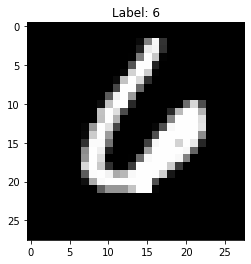

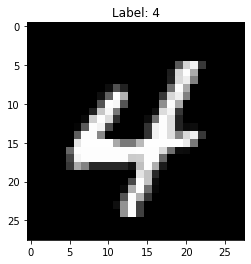

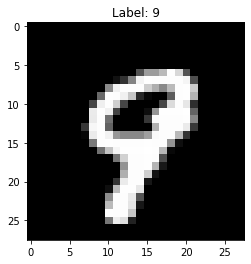

Feature 155 top 3 activations:


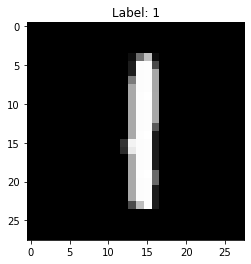

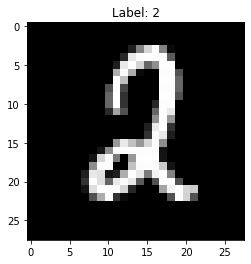

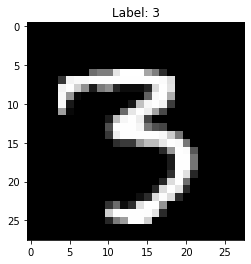

Feature 156 top 3 activations:


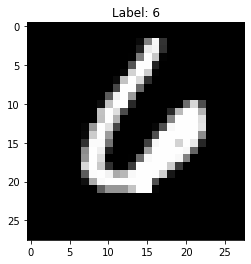

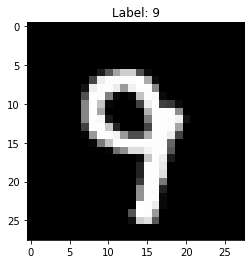

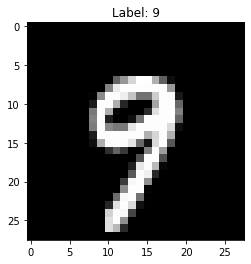

Feature 157 top 3 activations:


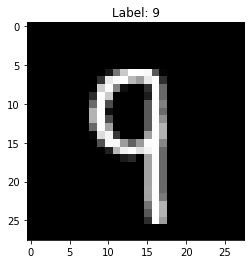

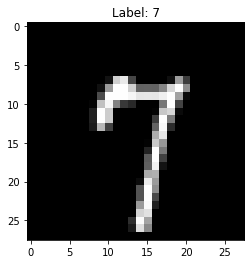

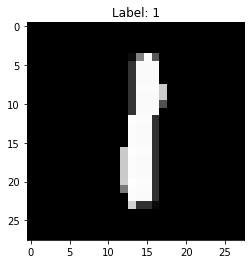

Feature 158 top 3 activations:


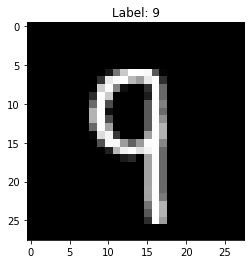

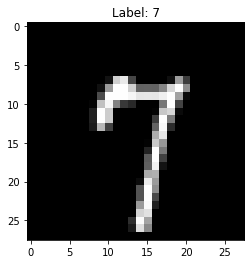

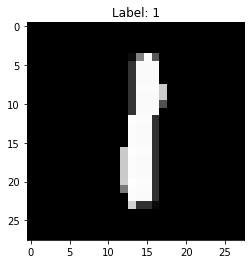

Feature 159 top 3 activations:


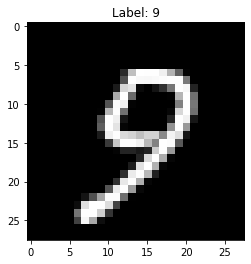

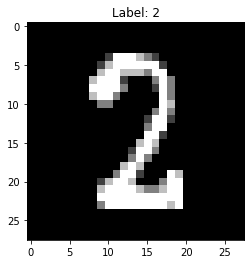

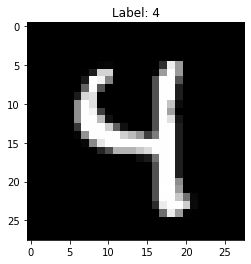

Feature 160 top 3 activations:


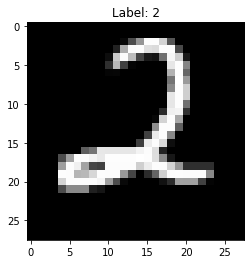

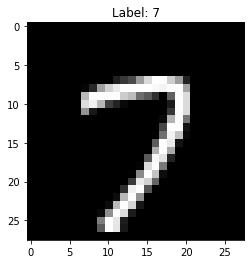

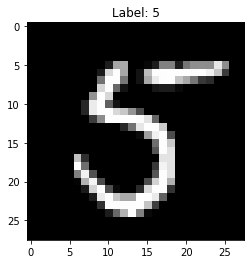

Feature 161 top 3 activations:


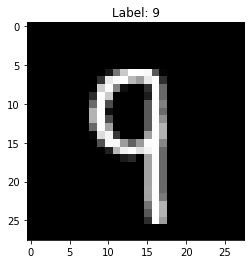

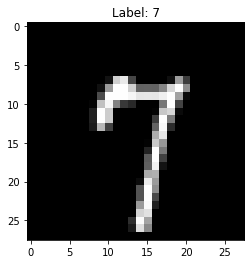

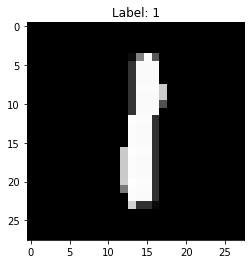

Feature 162 top 3 activations:


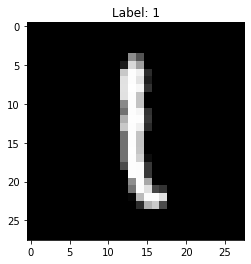

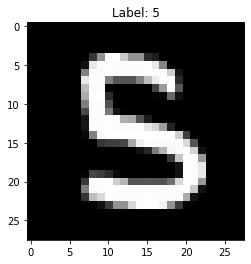

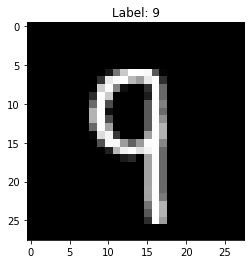

Feature 163 top 3 activations:


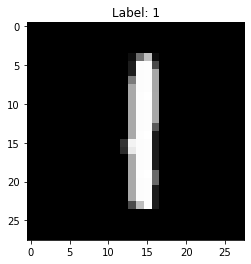

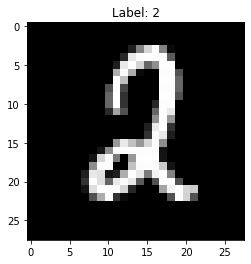

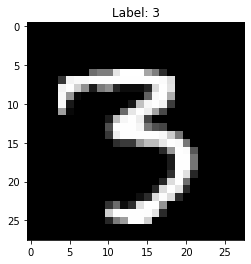

Feature 164 top 3 activations:


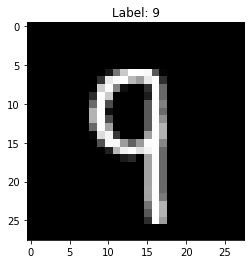

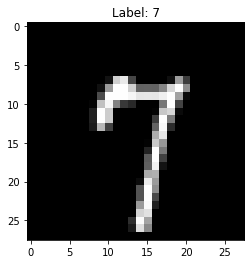

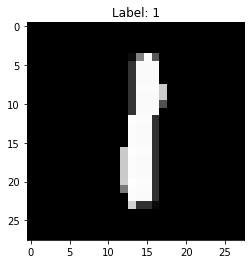

Feature 165 top 3 activations:


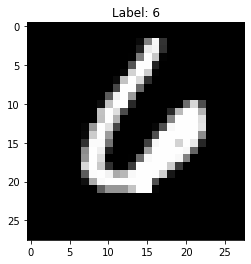

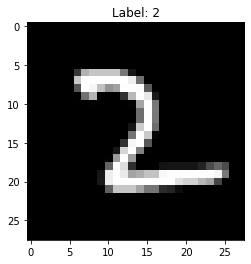

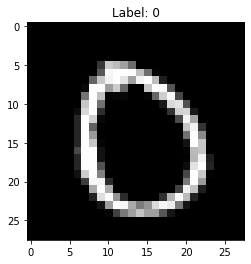

Feature 166 top 3 activations:


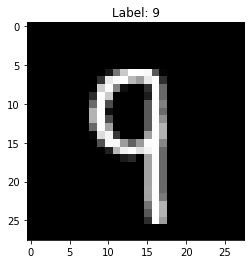

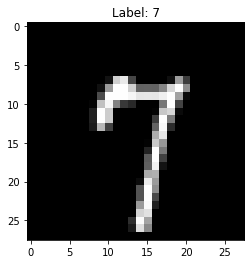

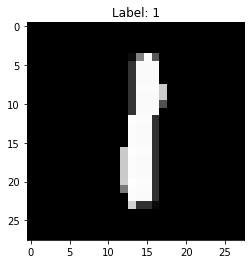

Feature 167 top 3 activations:


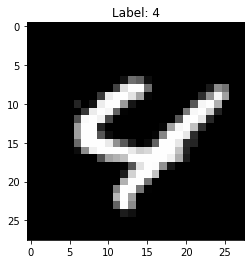

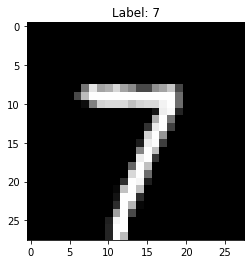

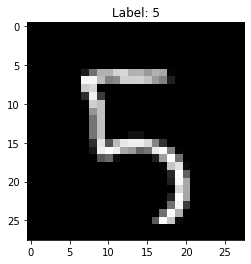

Feature 168 top 3 activations:


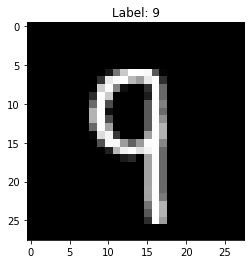

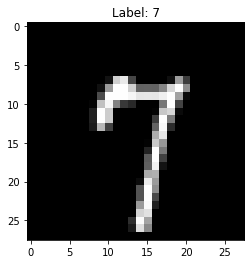

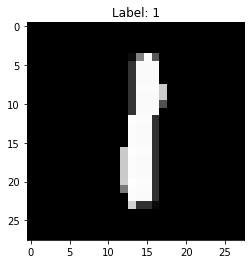

Feature 169 top 3 activations:


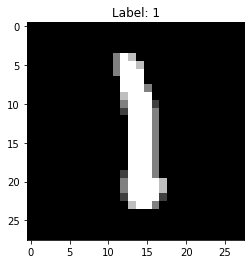

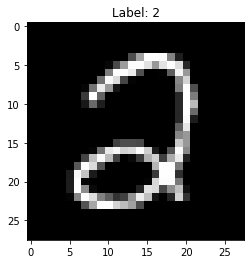

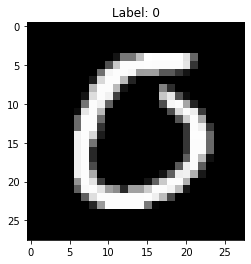

Feature 170 top 3 activations:


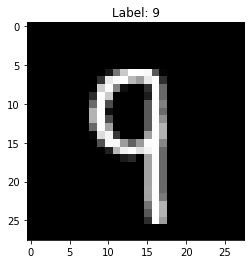

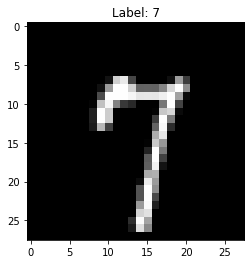

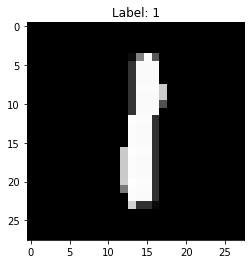

Feature 171 top 3 activations:


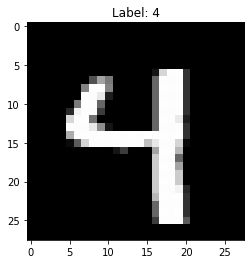

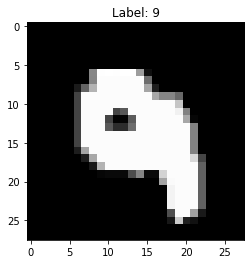

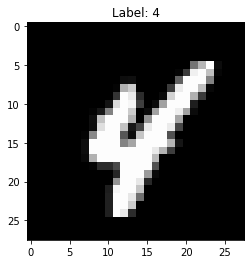

Feature 172 top 3 activations:


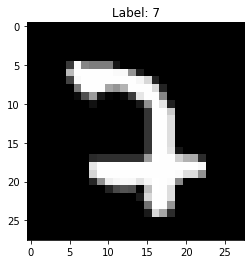

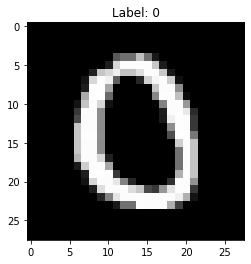

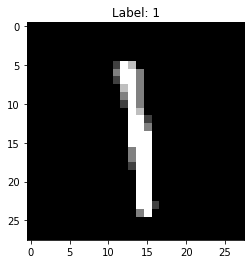

Feature 173 top 3 activations:


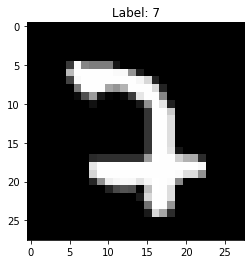

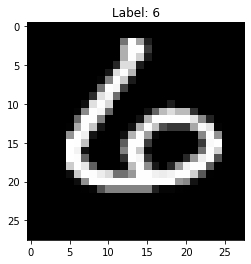

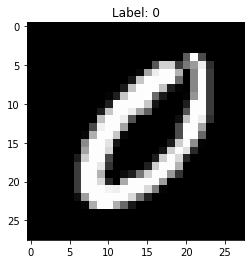

Feature 174 top 3 activations:


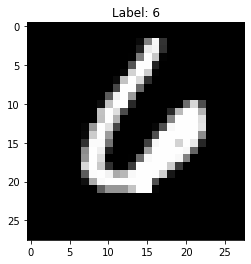

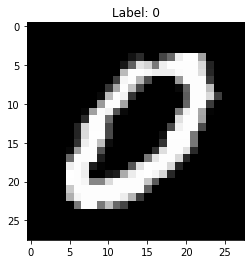

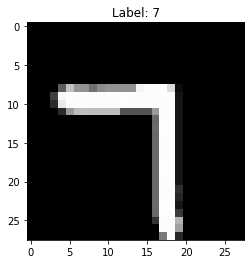

Feature 175 top 3 activations:


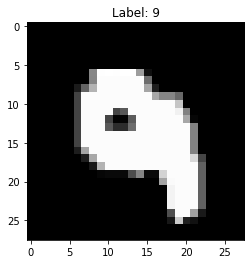

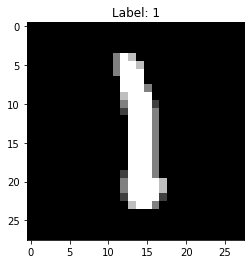

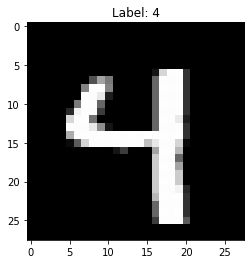

Feature 176 top 3 activations:


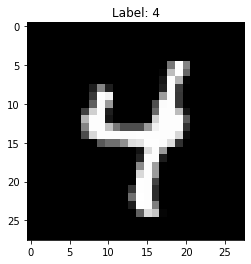

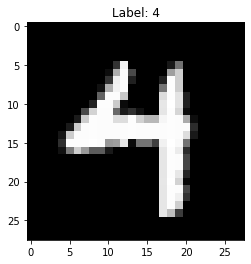

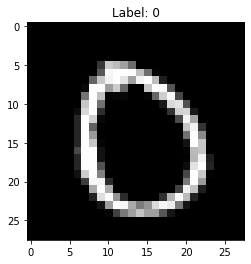

Feature 177 top 3 activations:


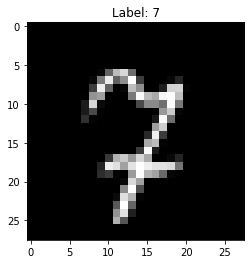

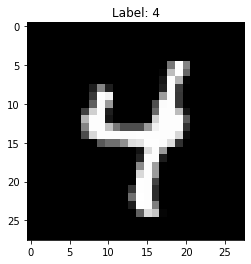

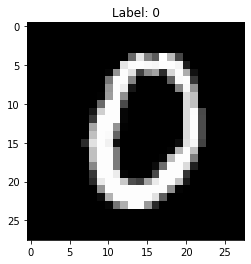

Feature 178 top 3 activations:


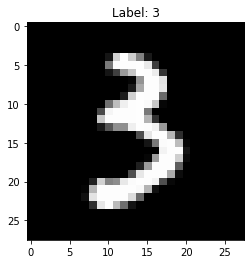

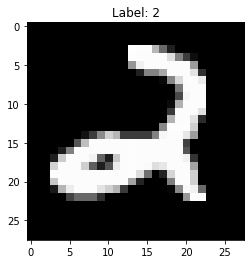

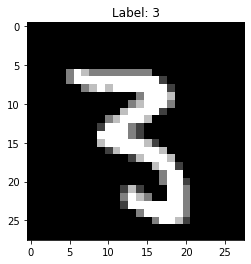

Feature 179 top 3 activations:


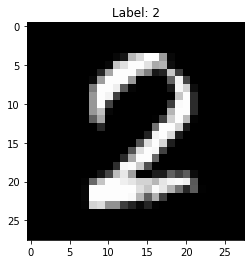

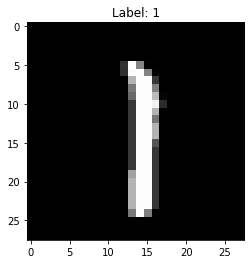

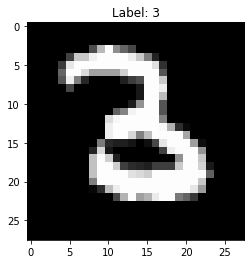

Feature 180 top 3 activations:


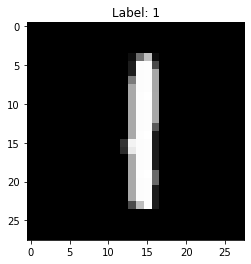

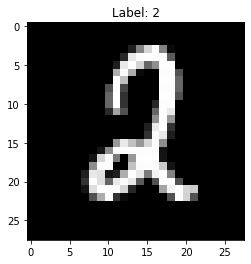

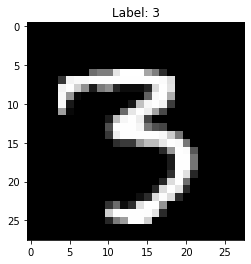

Feature 181 top 3 activations:


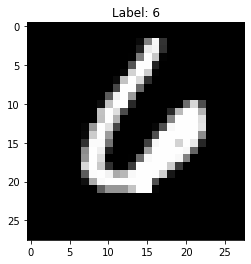

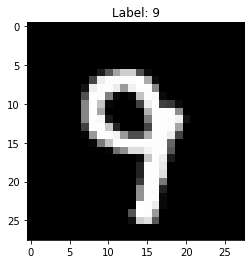

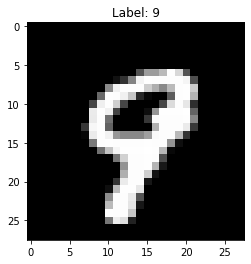

Feature 182 top 3 activations:


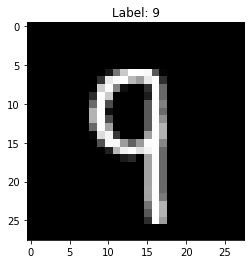

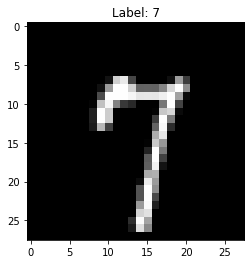

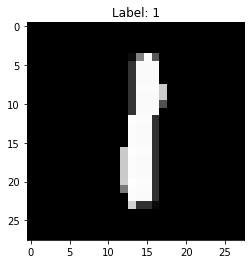

Feature 183 top 3 activations:


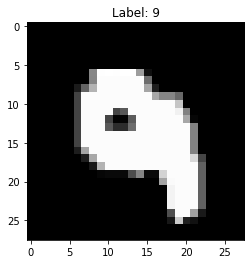

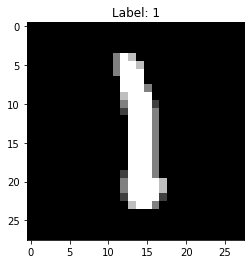

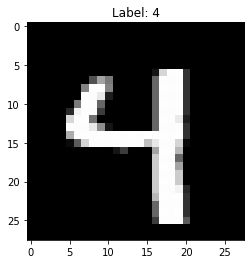

Feature 184 top 3 activations:


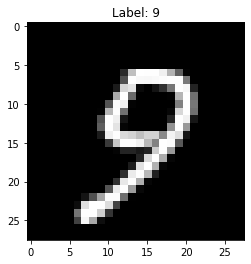

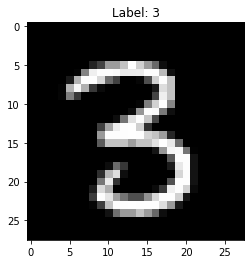

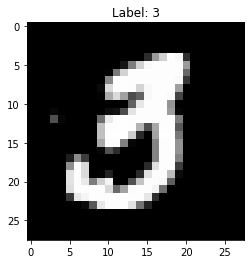

Feature 185 top 3 activations:


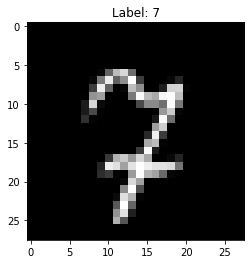

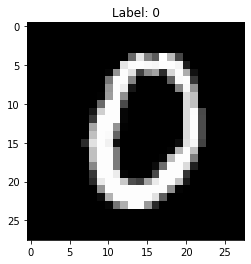

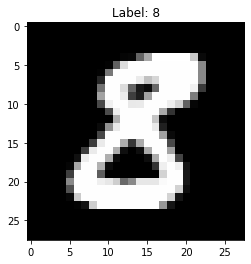

Feature 186 top 3 activations:


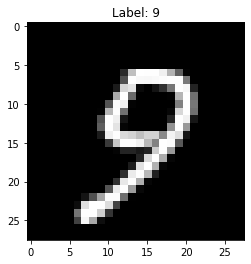

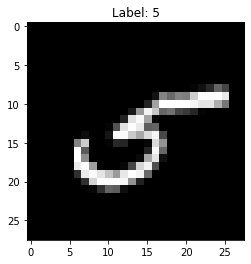

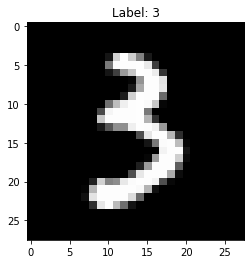

Feature 187 top 3 activations:


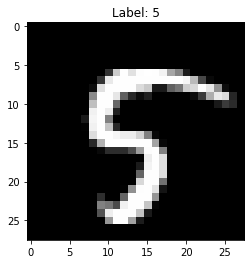

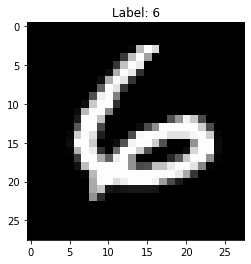

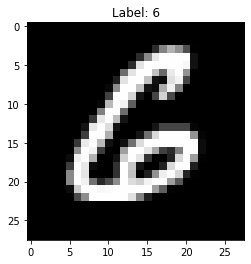

Feature 188 top 3 activations:


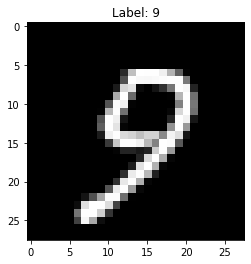

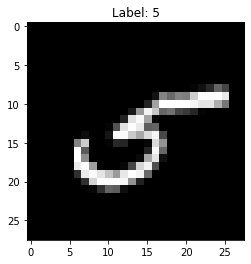

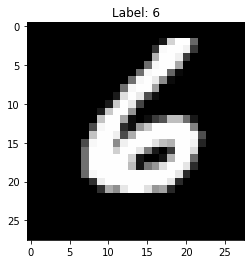

Feature 189 top 3 activations:


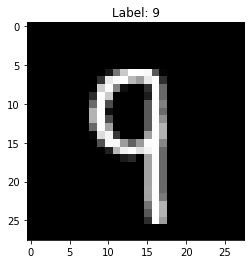

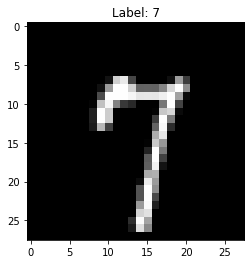

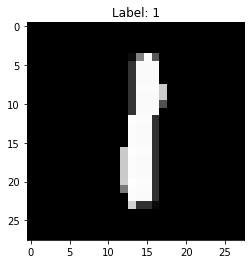

Feature 190 top 3 activations:


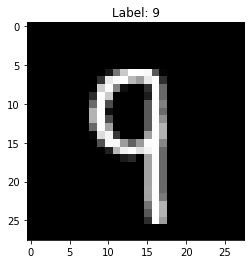

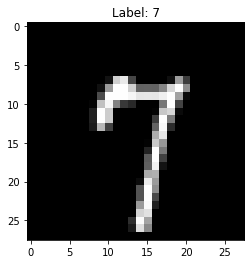

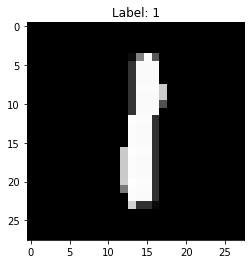

Feature 191 top 3 activations:


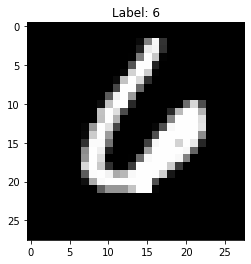

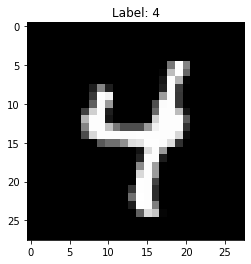

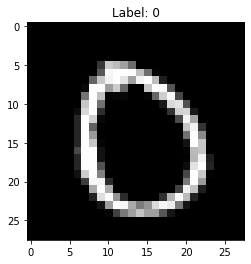

Feature 192 top 3 activations:


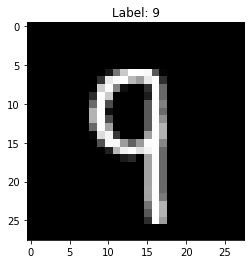

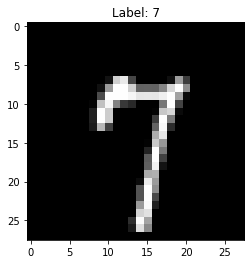

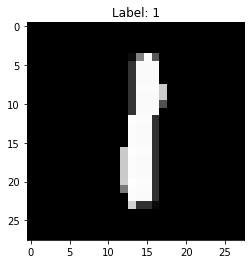

Feature 193 top 3 activations:


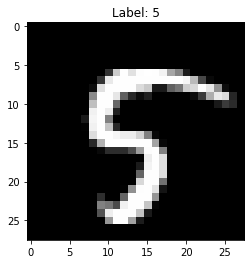

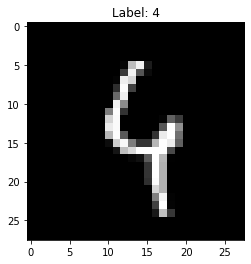

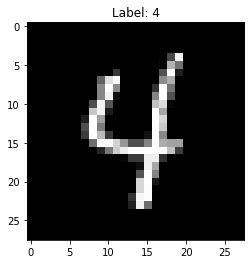

Feature 194 top 3 activations:


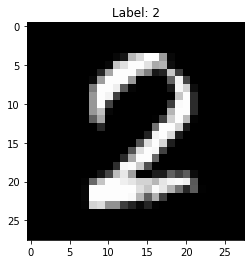

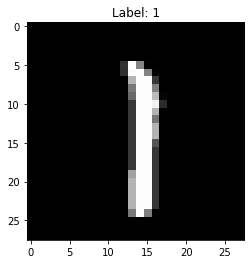

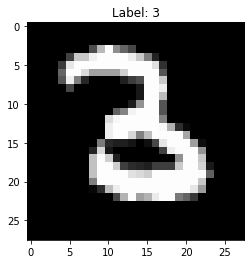

Feature 195 top 3 activations:


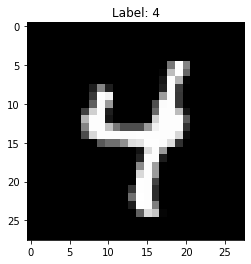

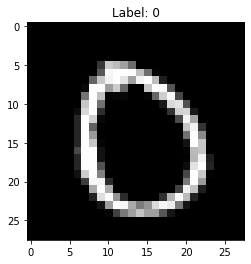

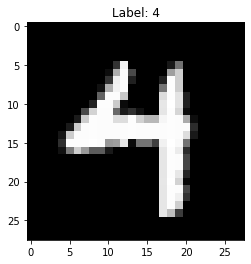

Feature 196 top 3 activations:


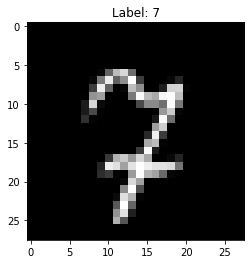

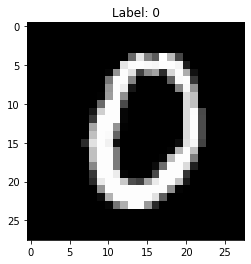

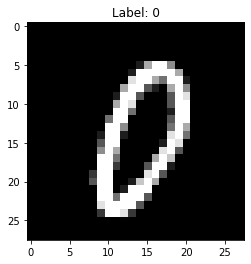

Feature 197 top 3 activations:


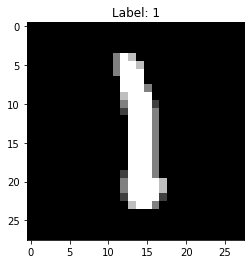

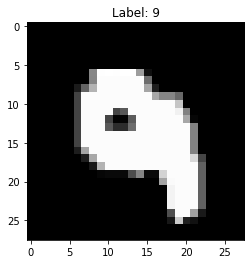

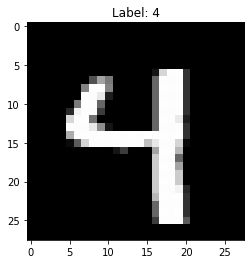

Feature 198 top 3 activations:


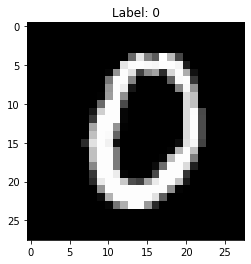

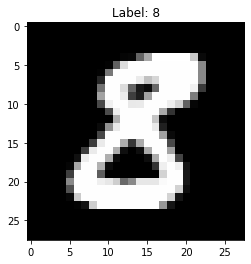

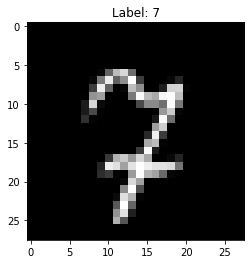

Feature 199 top 3 activations:


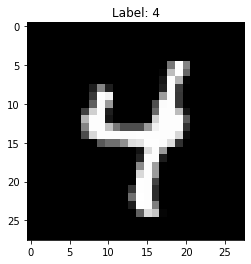

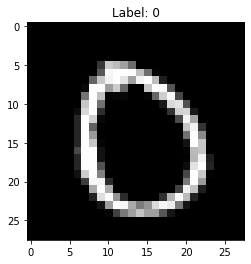

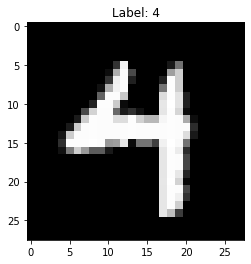

Feature 200 top 3 activations:


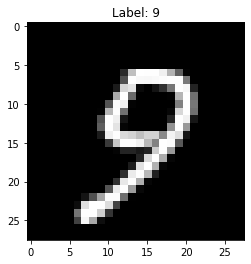

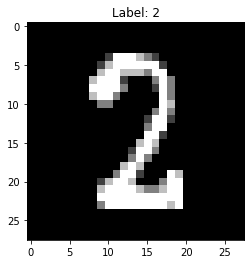

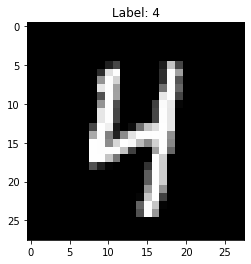

Feature 201 top 3 activations:


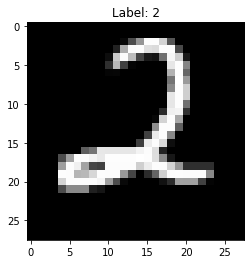

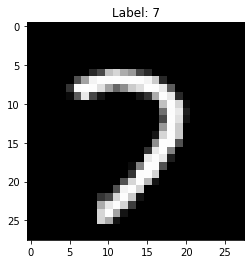

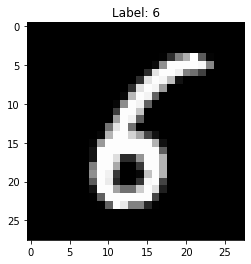

Feature 202 top 3 activations:


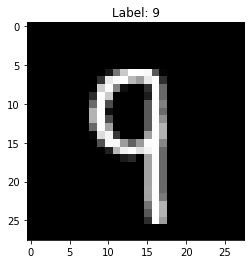

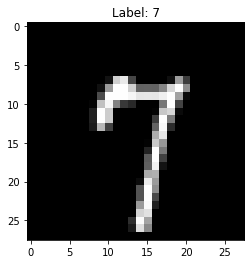

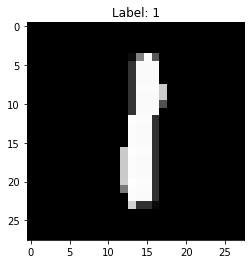

Feature 203 top 3 activations:


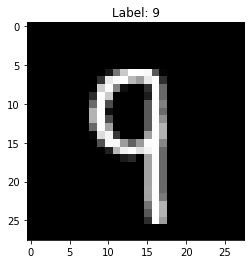

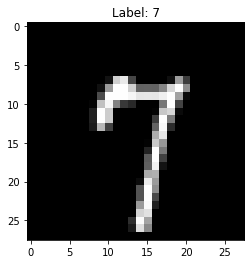

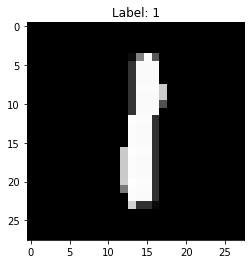

Feature 204 top 3 activations:


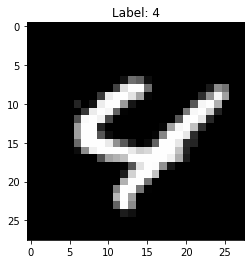

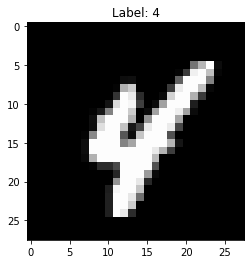

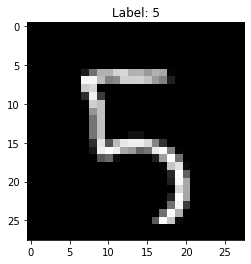

Feature 205 top 3 activations:


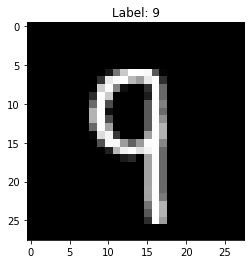

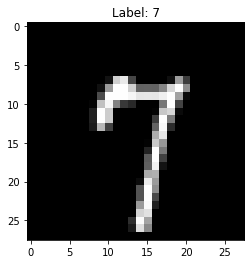

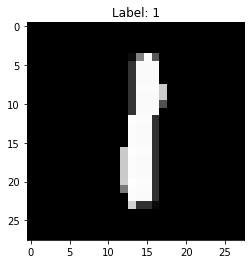

Feature 206 top 3 activations:


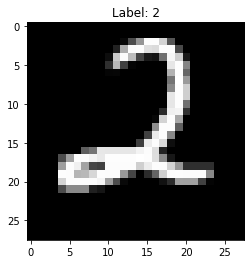

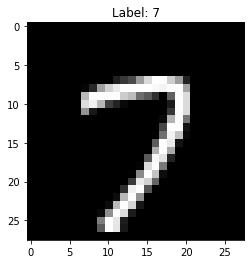

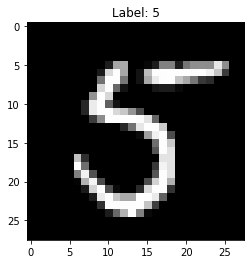

Feature 207 top 3 activations:


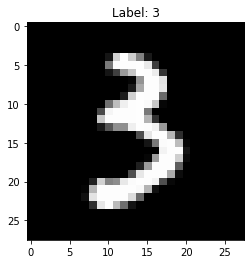

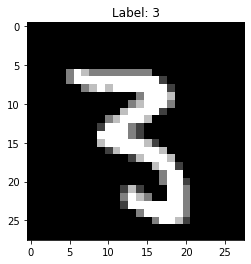

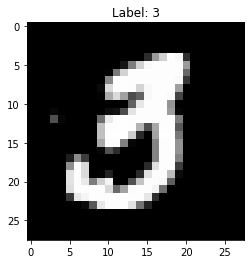

Feature 208 top 3 activations:


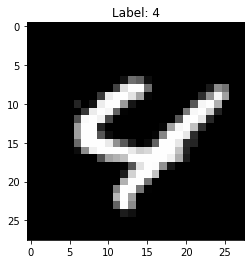

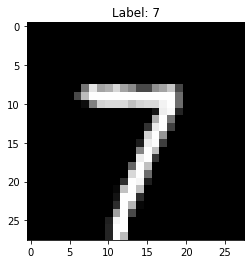

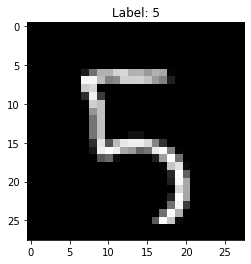

Feature 209 top 3 activations:


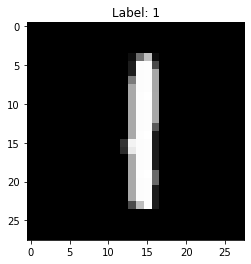

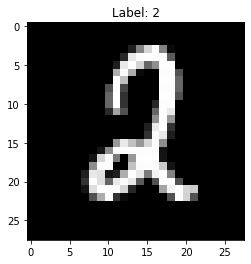

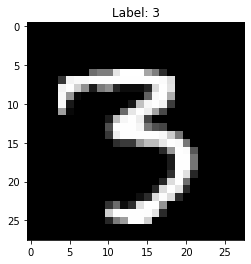

Feature 210 top 3 activations:


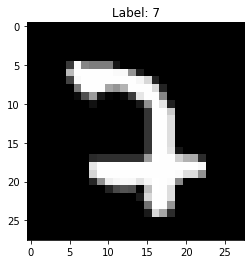

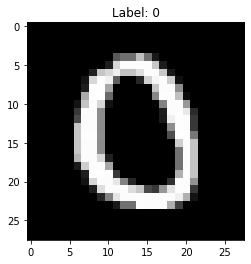

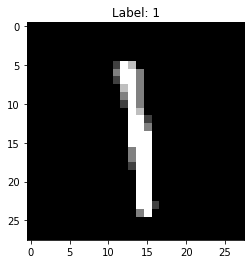

Feature 211 top 3 activations:


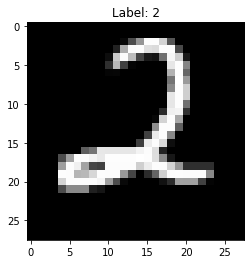

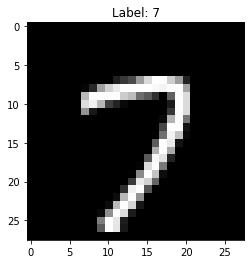

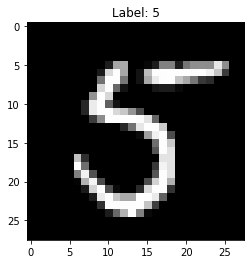

Feature 212 top 3 activations:


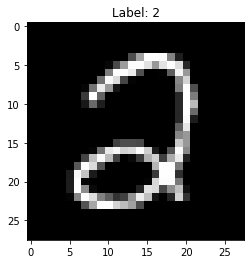

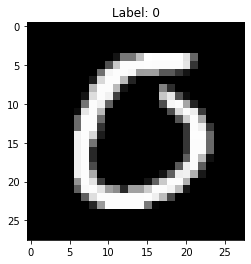

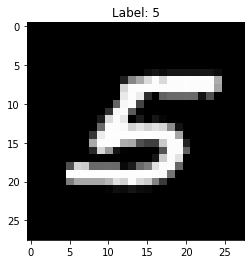

Feature 213 top 3 activations:


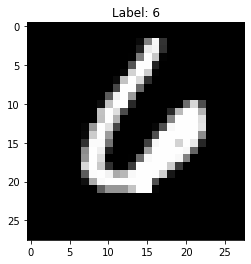

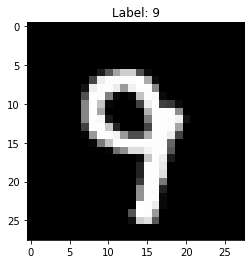

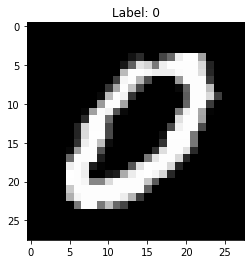

Feature 214 top 3 activations:


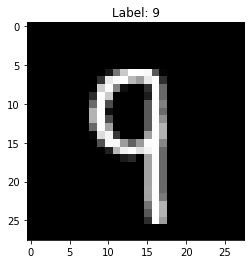

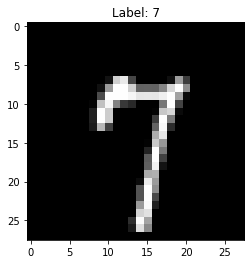

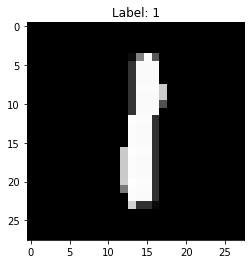

Feature 215 top 3 activations:


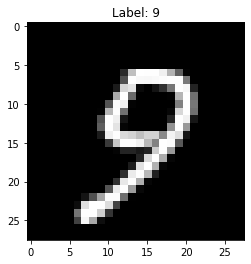

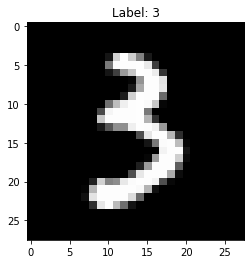

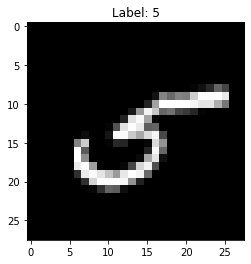

Feature 216 top 3 activations:


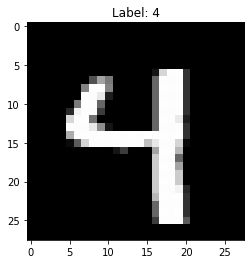

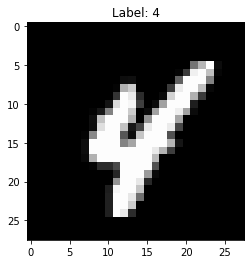

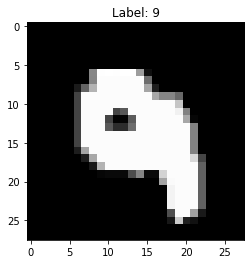

Feature 217 top 3 activations:


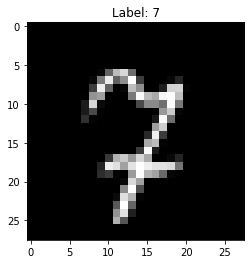

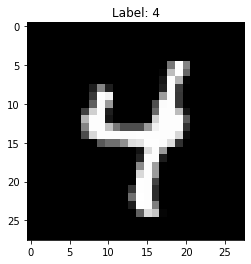

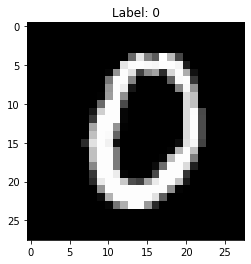

Feature 218 top 3 activations:


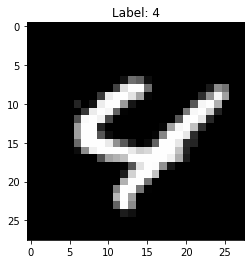

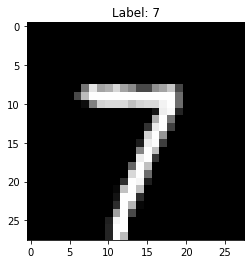

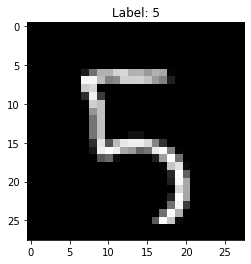

Feature 219 top 3 activations:


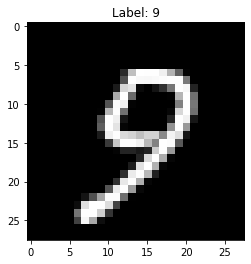

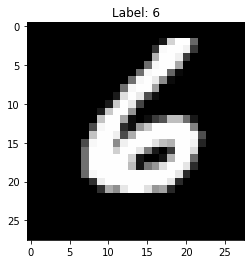

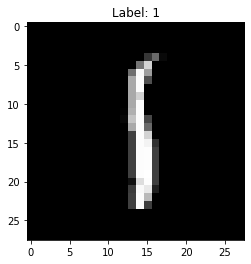

Feature 220 top 3 activations:


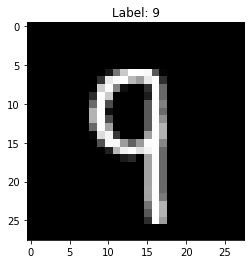

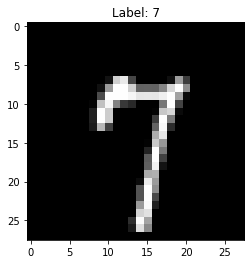

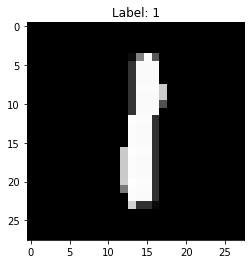

Feature 221 top 3 activations:


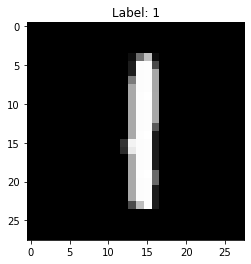

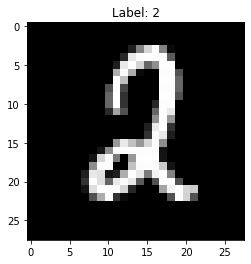

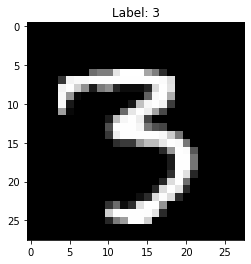

Feature 222 top 3 activations:


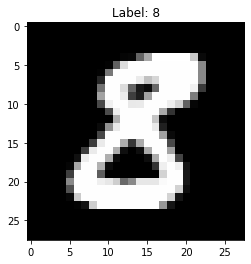

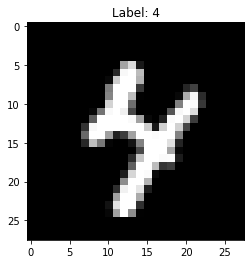

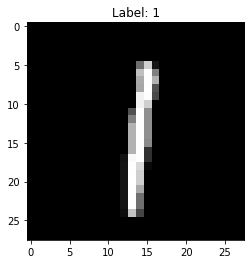

Feature 223 top 3 activations:


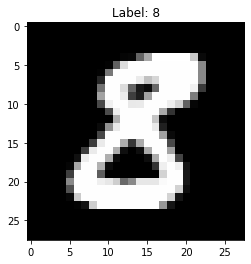

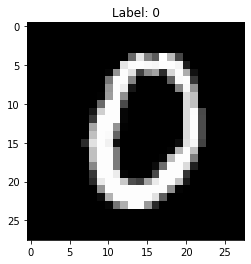

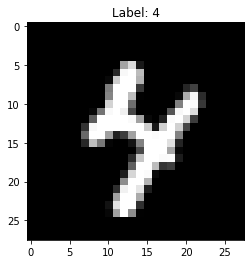

Feature 224 top 3 activations:


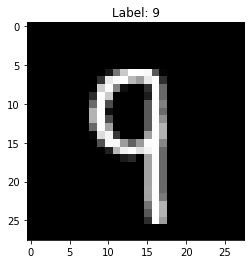

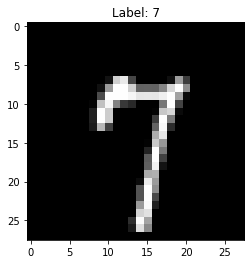

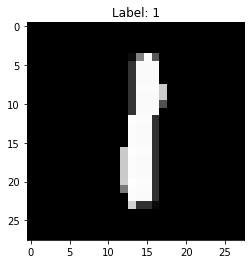

Feature 225 top 3 activations:


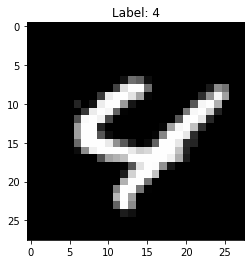

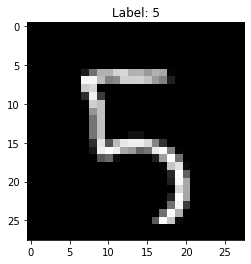

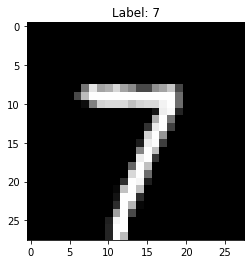

Feature 226 top 3 activations:


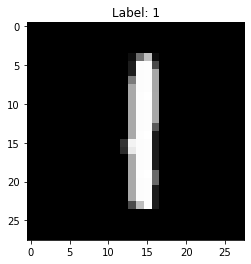

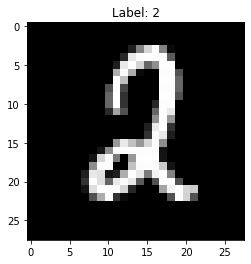

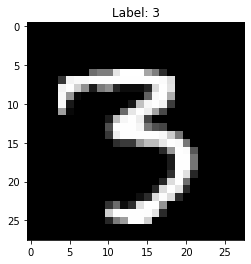

Feature 227 top 3 activations:


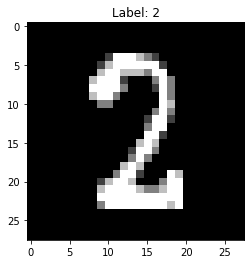

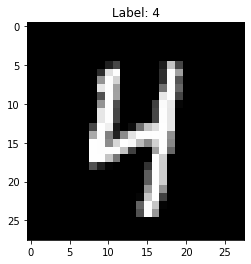

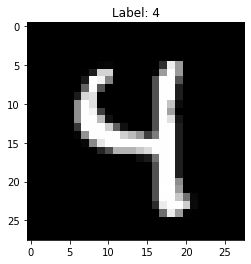

Feature 228 top 3 activations:


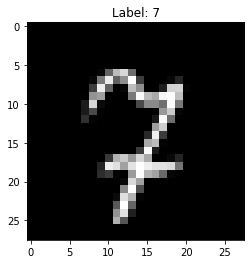

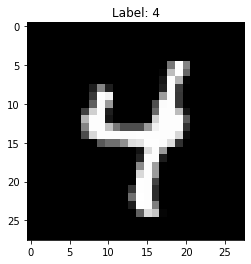

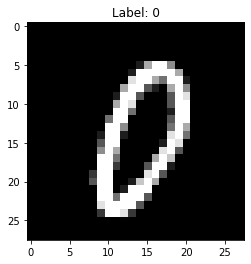

Feature 229 top 3 activations:


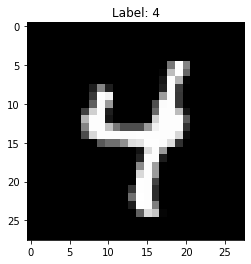

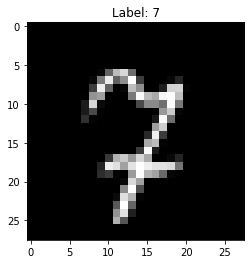

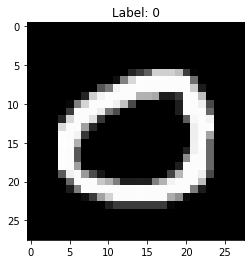

Feature 230 top 3 activations:


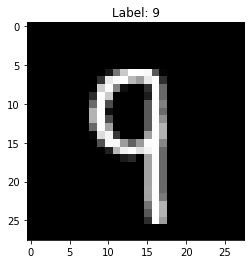

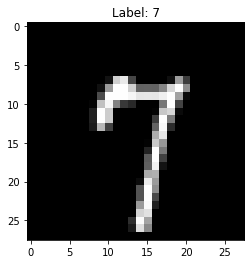

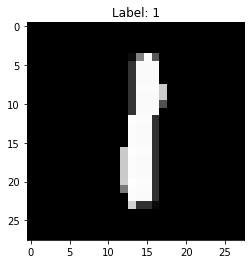

Feature 231 top 3 activations:


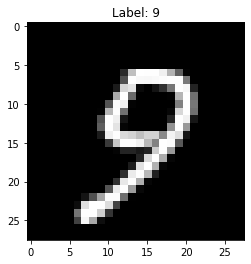

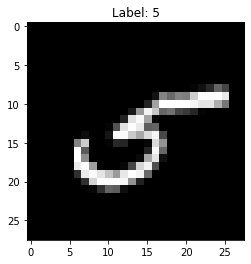

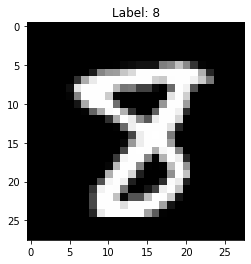

Feature 232 top 3 activations:


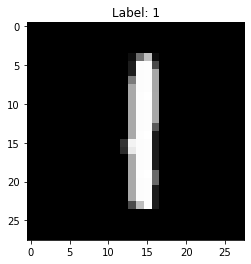

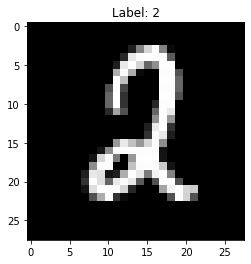

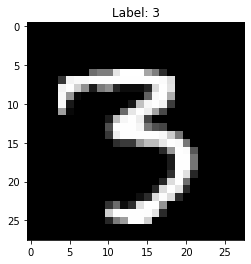

Feature 233 top 3 activations:


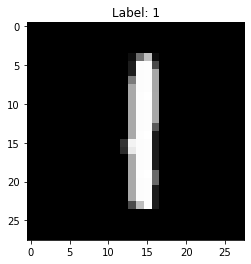

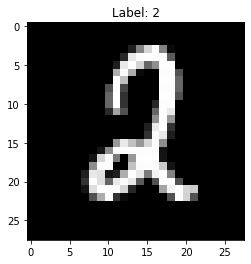

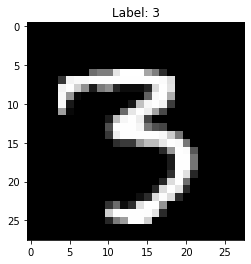

Feature 234 top 3 activations:


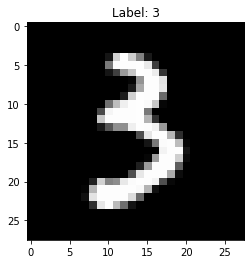

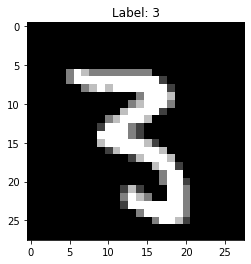

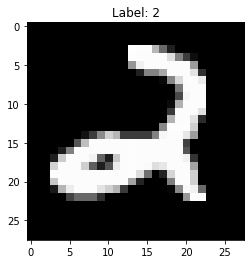

Feature 235 top 3 activations:


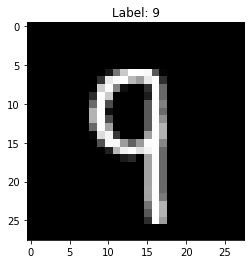

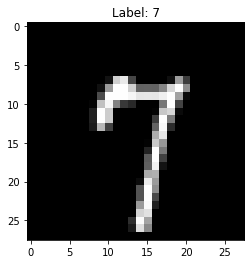

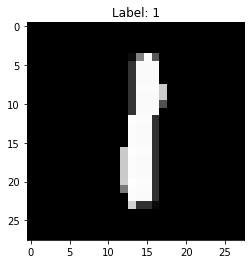

Feature 236 top 3 activations:


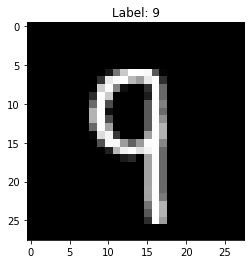

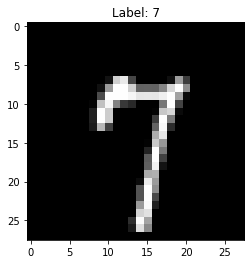

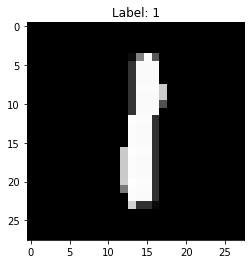

Feature 237 top 3 activations:


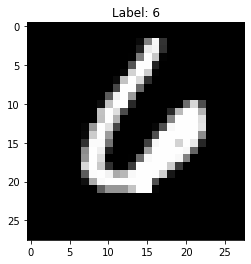

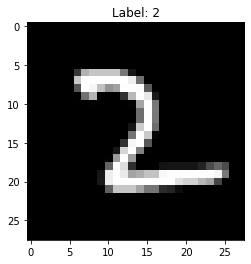

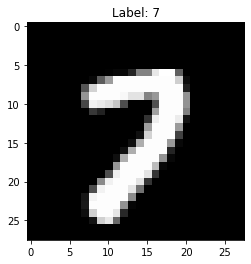

Feature 238 top 3 activations:


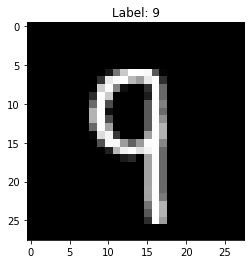

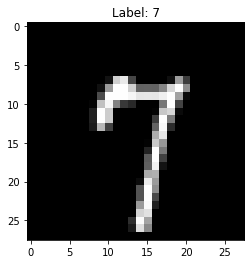

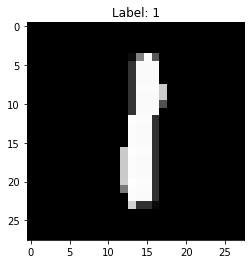

Feature 239 top 3 activations:


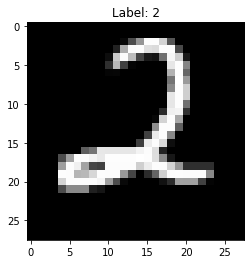

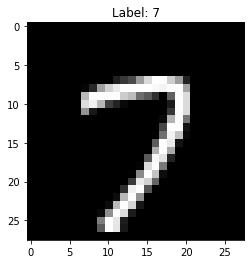

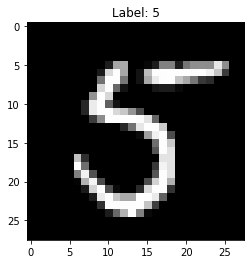

Feature 240 top 3 activations:


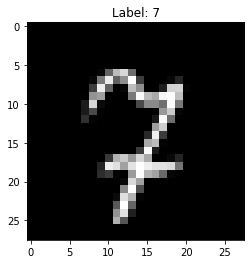

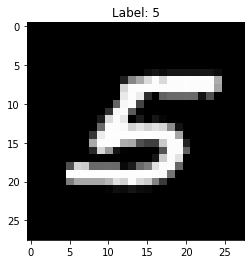

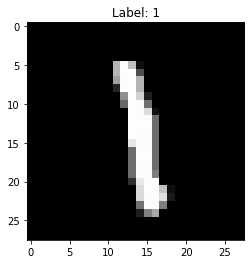

Feature 241 top 3 activations:


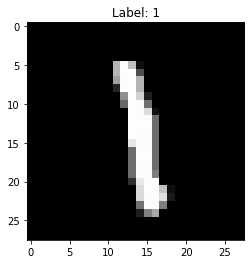

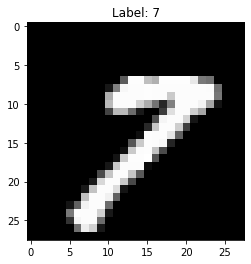

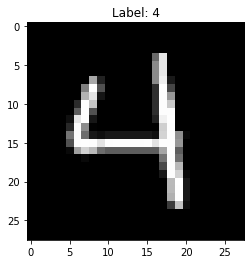

Feature 242 top 3 activations:


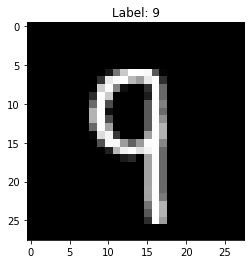

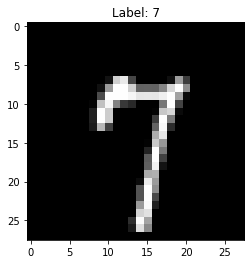

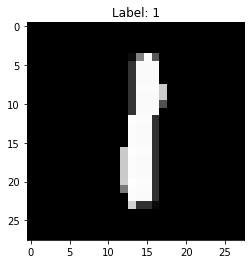

Feature 243 top 3 activations:


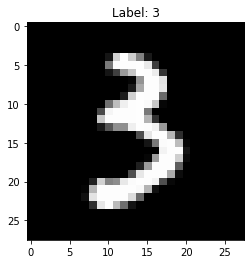

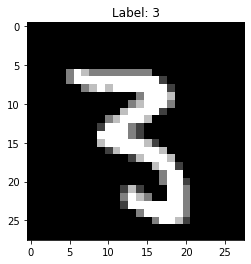

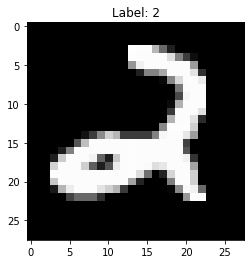

Feature 244 top 3 activations:


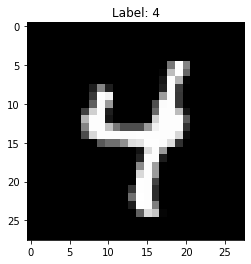

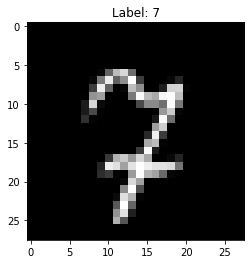

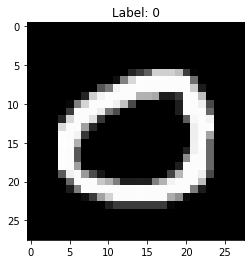

Feature 245 top 3 activations:


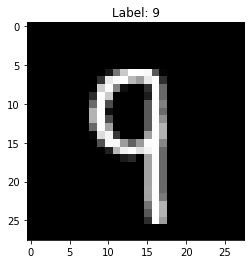

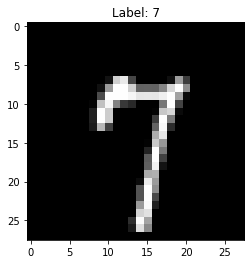

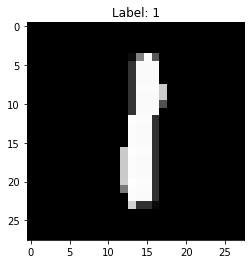

Feature 246 top 3 activations:


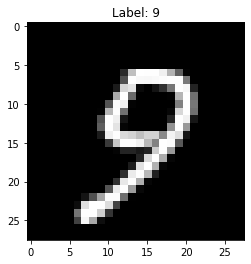

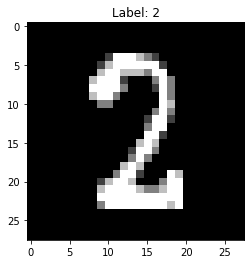

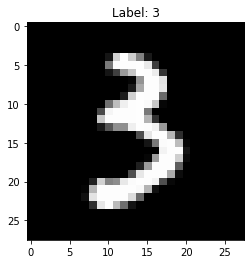

Feature 247 top 3 activations:


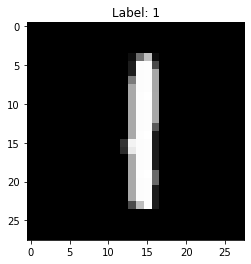

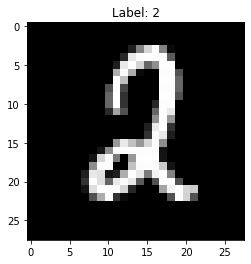

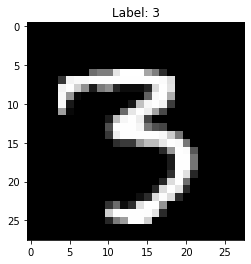

Feature 248 top 3 activations:


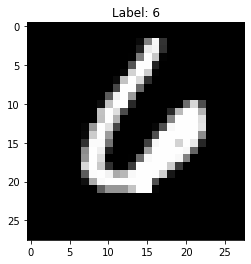

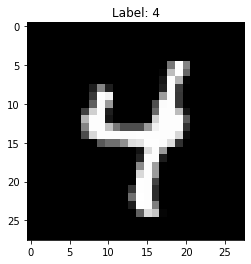

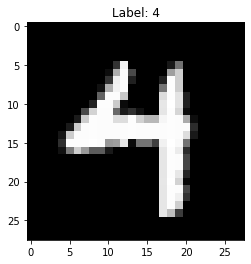

Feature 249 top 3 activations:


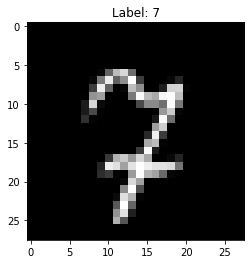

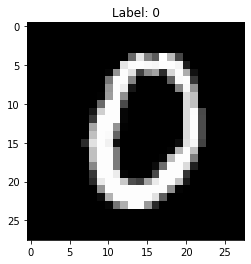

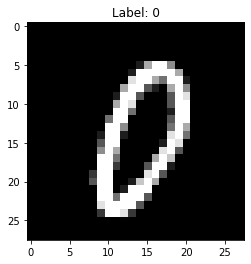

Feature 250 top 3 activations:


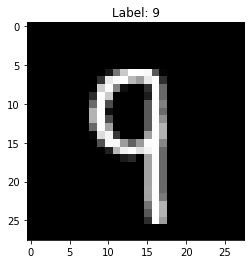

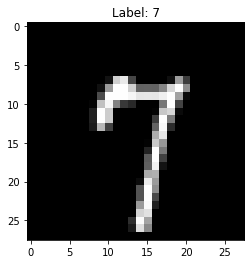

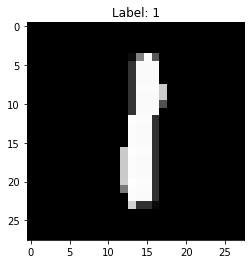

Feature 251 top 3 activations:


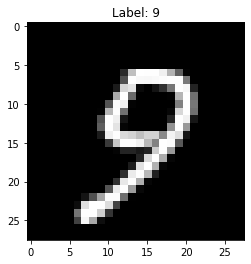

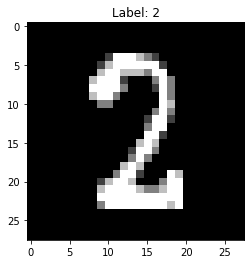

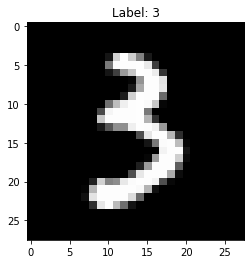

Feature 252 top 3 activations:


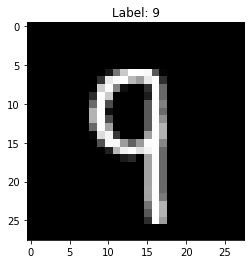

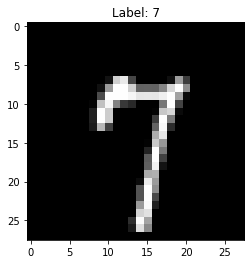

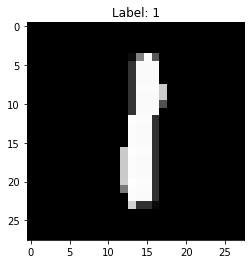

Feature 253 top 3 activations:


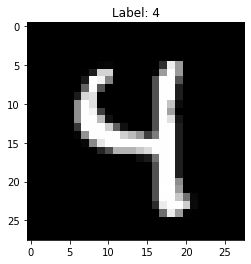

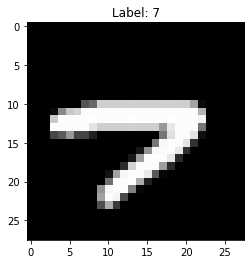

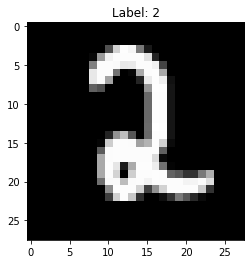

Feature 254 top 3 activations:


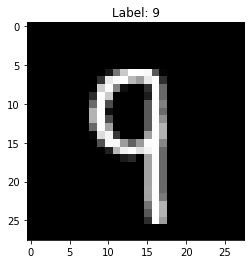

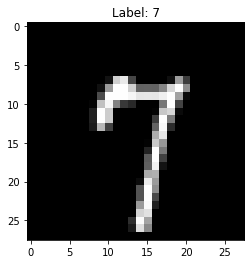

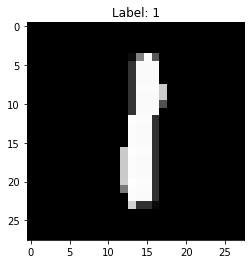

Feature 255 top 3 activations:


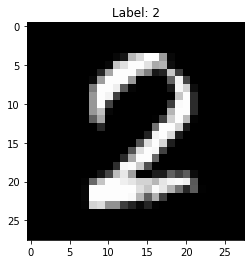

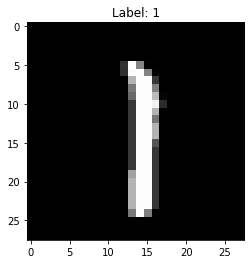

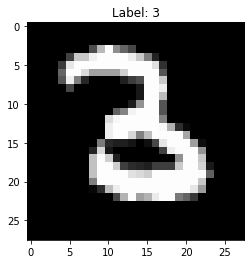

In [34]:
show_top_act_images_by_feature(feature_activations_hidden_one,
                               train_images,
                               train_labels)

Feature 0 top 3 activations:


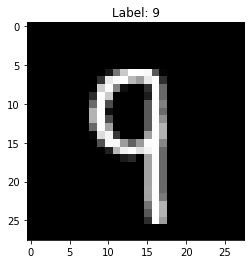

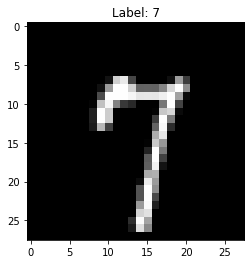

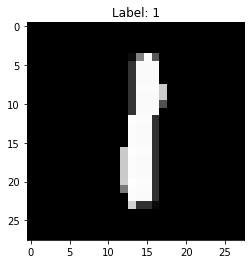

Feature 1 top 3 activations:


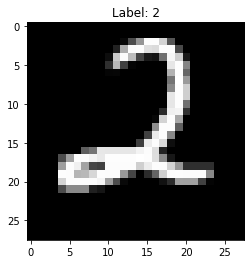

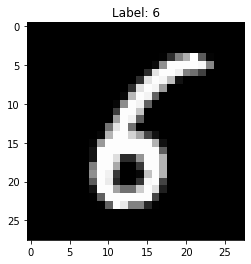

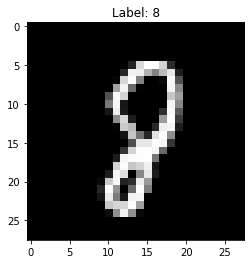

Feature 2 top 3 activations:


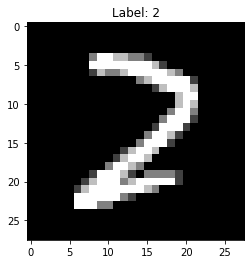

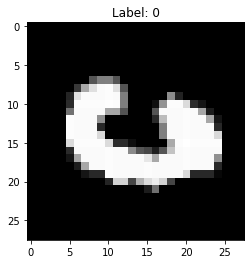

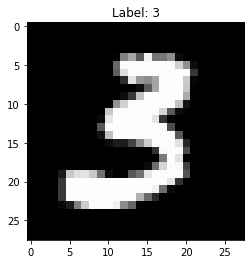

Feature 3 top 3 activations:


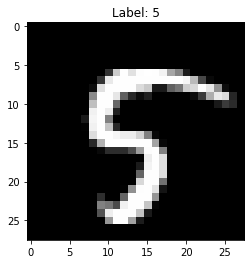

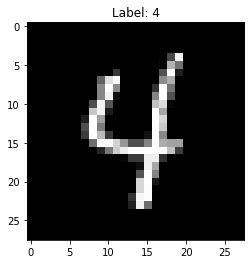

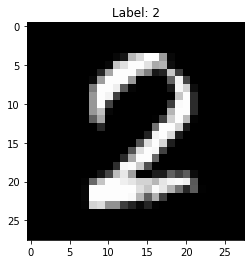

Feature 4 top 3 activations:


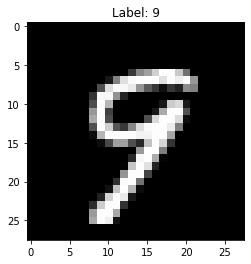

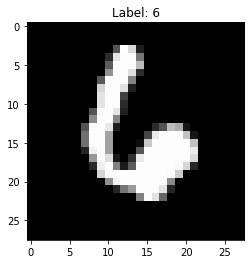

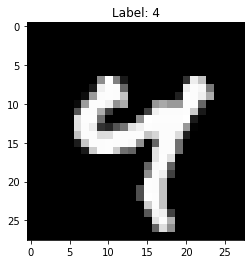

Feature 5 top 3 activations:


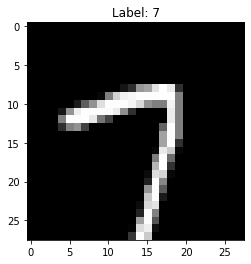

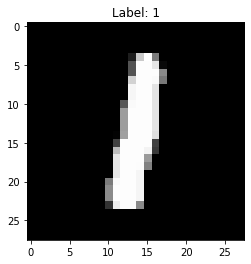

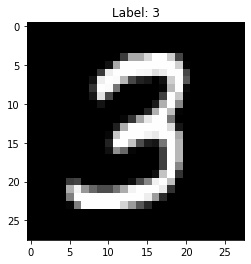

Feature 6 top 3 activations:


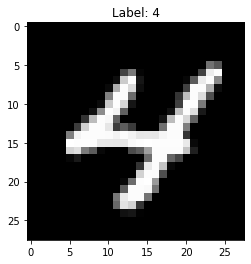

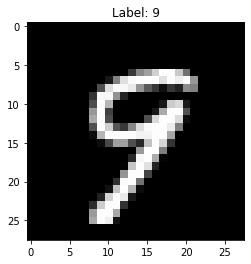

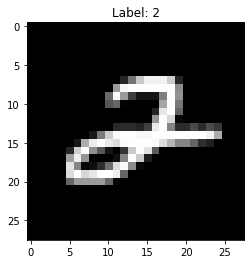

Feature 7 top 3 activations:


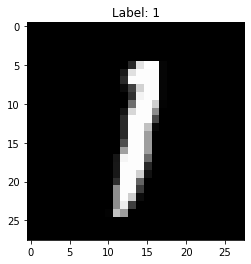

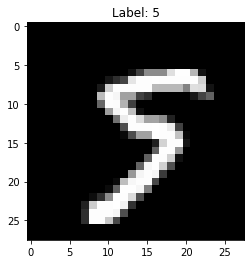

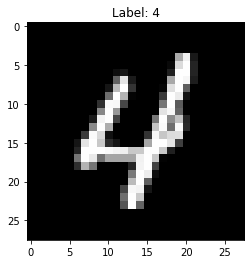

Feature 8 top 3 activations:


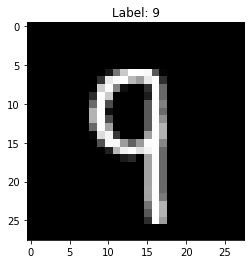

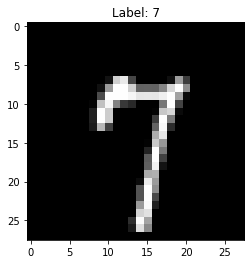

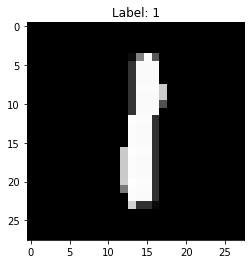

Feature 9 top 3 activations:


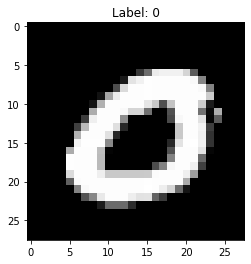

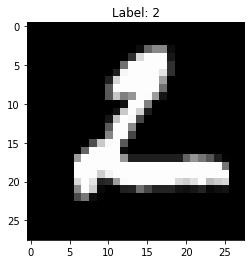

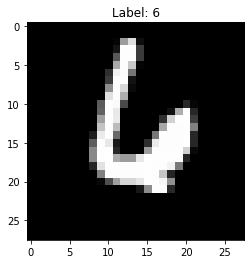

Feature 10 top 3 activations:


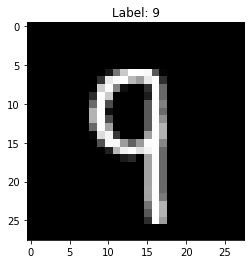

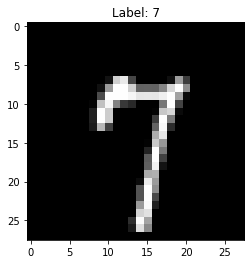

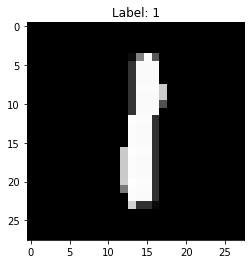

Feature 11 top 3 activations:


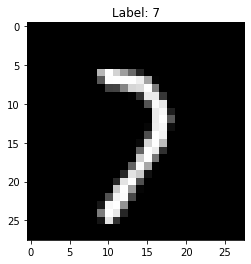

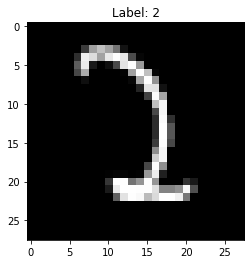

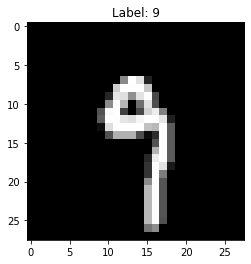

Feature 12 top 3 activations:


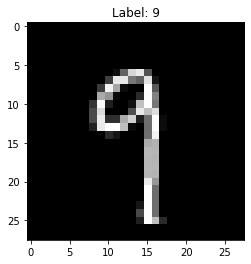

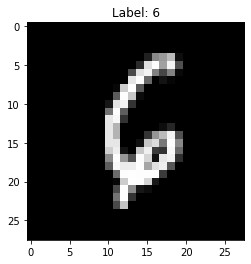

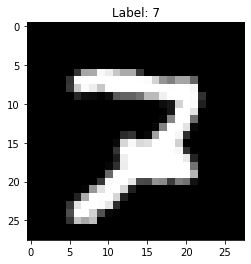

Feature 13 top 3 activations:


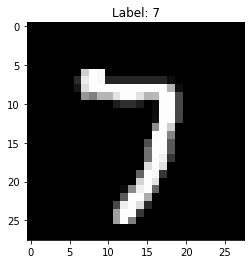

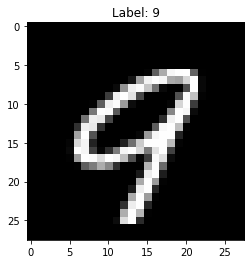

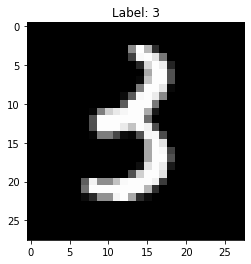

Feature 14 top 3 activations:


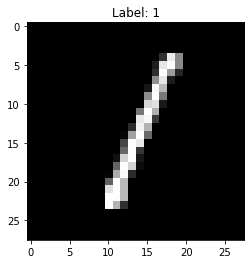

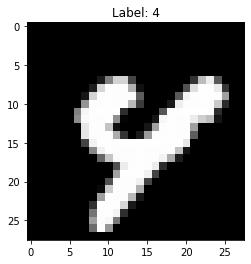

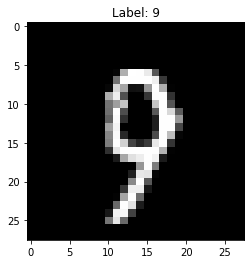

Feature 15 top 3 activations:


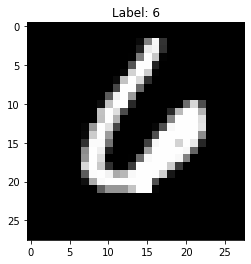

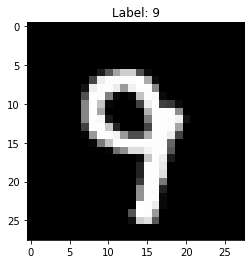

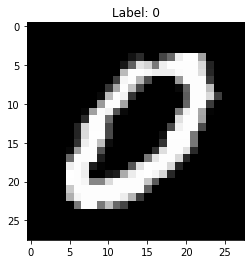

Feature 16 top 3 activations:


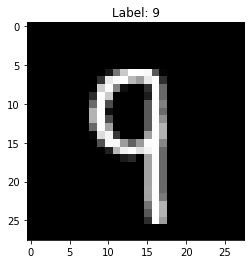

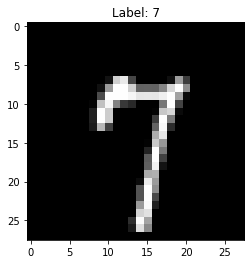

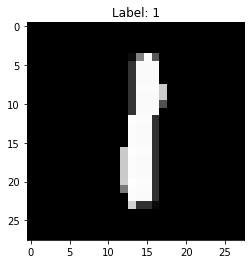

Feature 17 top 3 activations:


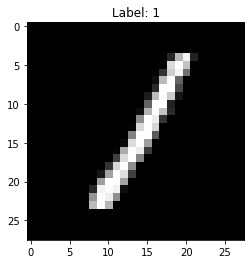

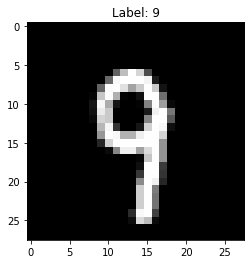

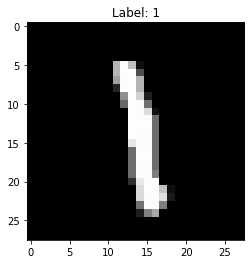

Feature 18 top 3 activations:


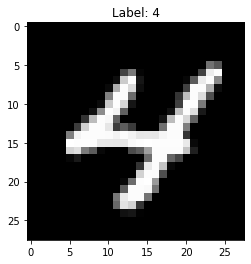

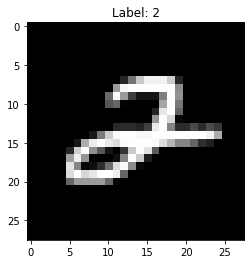

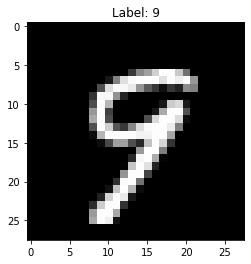

Feature 19 top 3 activations:


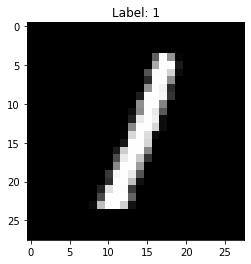

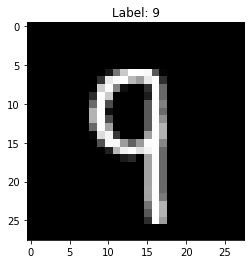

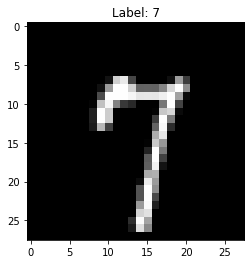

Feature 20 top 3 activations:


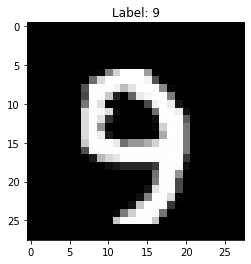

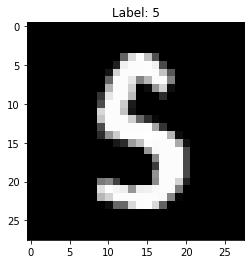

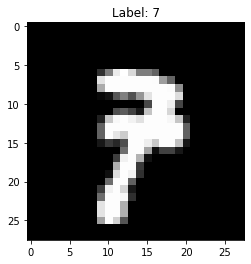

Feature 21 top 3 activations:


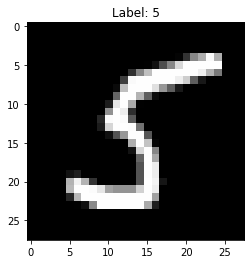

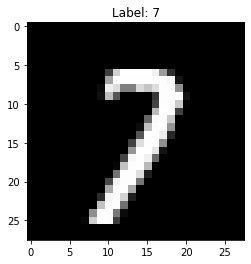

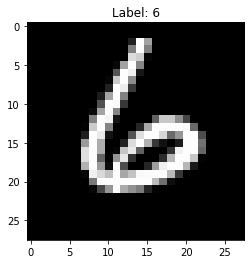

Feature 22 top 3 activations:


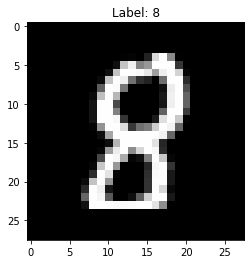

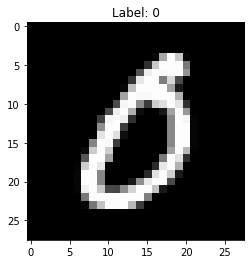

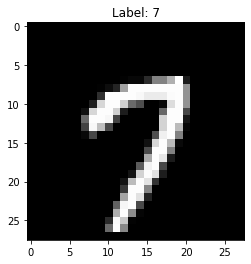

Feature 23 top 3 activations:


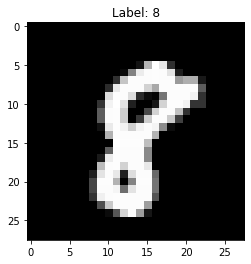

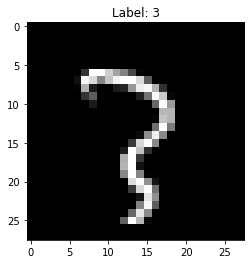

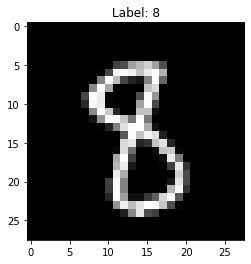

Feature 24 top 3 activations:


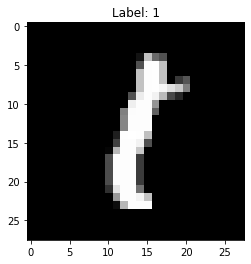

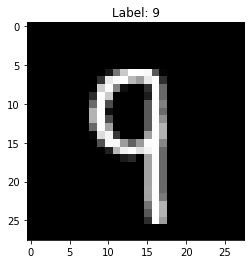

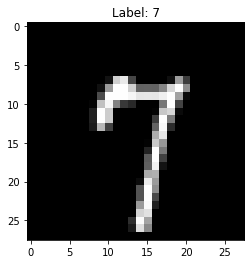

Feature 25 top 3 activations:


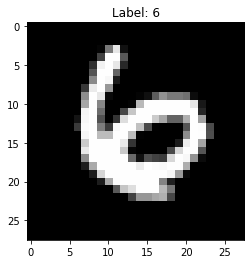

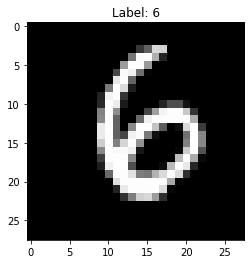

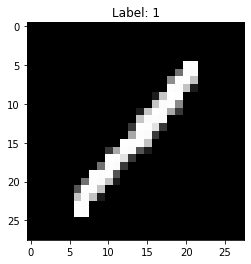

Feature 26 top 3 activations:


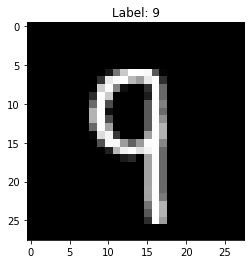

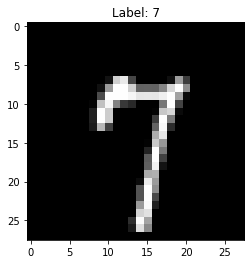

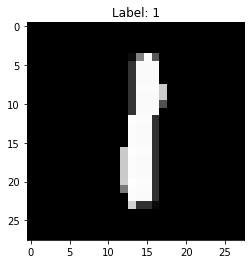

Feature 27 top 3 activations:


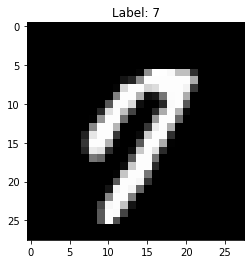

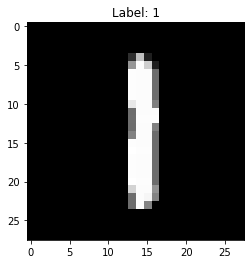

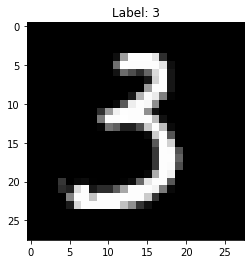

Feature 28 top 3 activations:


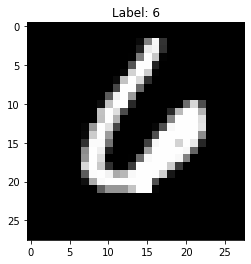

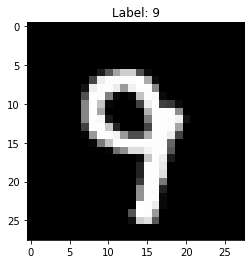

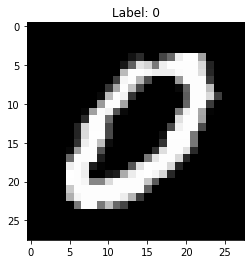

Feature 29 top 3 activations:


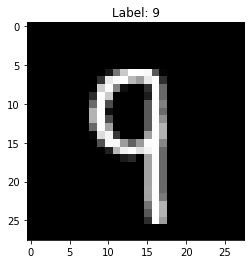

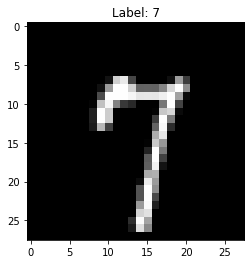

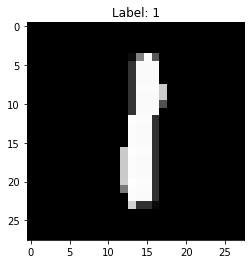

Feature 30 top 3 activations:


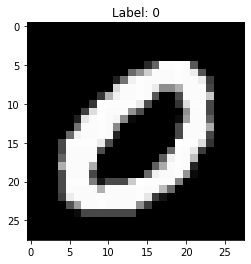

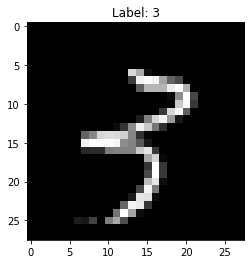

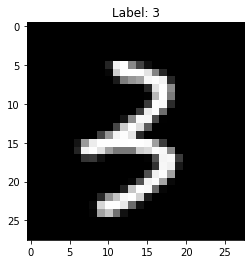

Feature 31 top 3 activations:


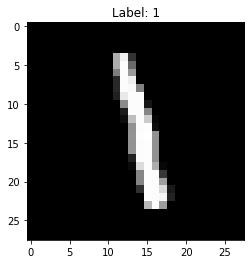

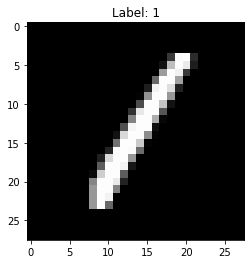

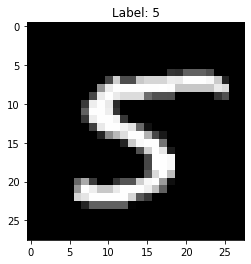

Feature 32 top 3 activations:


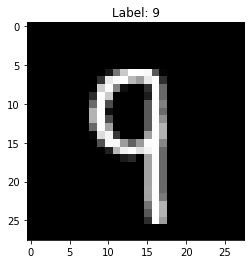

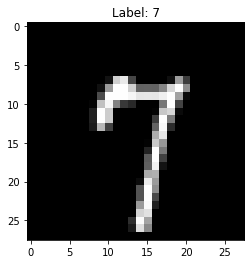

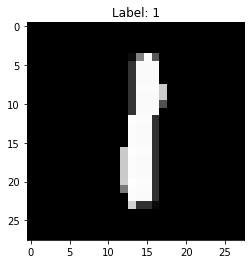

Feature 33 top 3 activations:


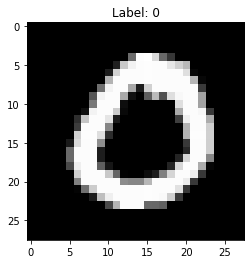

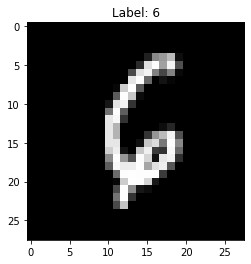

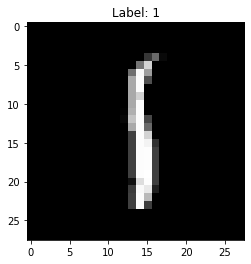

Feature 34 top 3 activations:


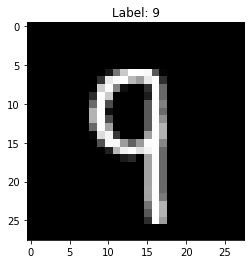

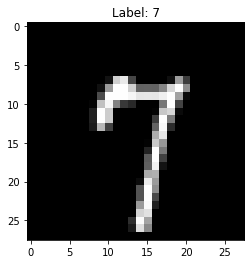

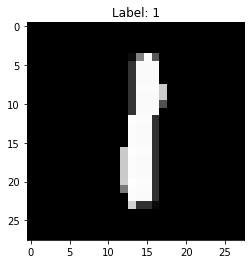

Feature 35 top 3 activations:


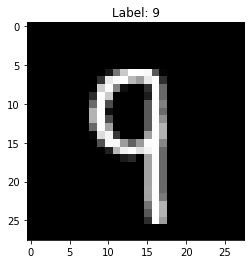

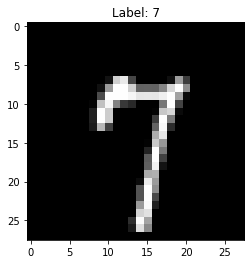

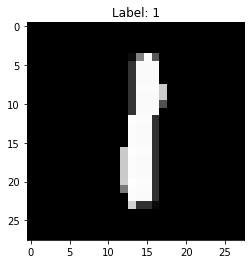

Feature 36 top 3 activations:


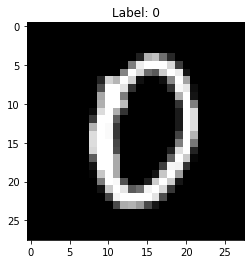

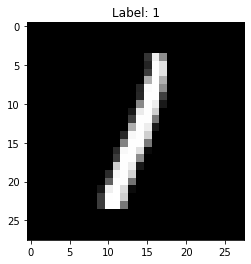

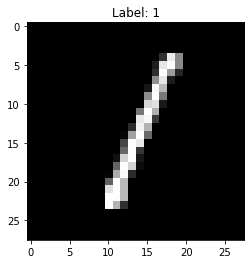

Feature 37 top 3 activations:


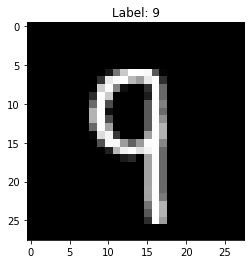

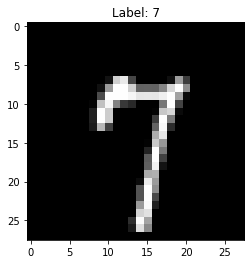

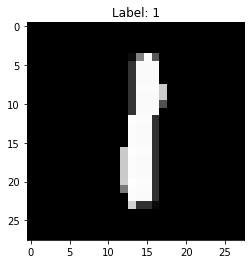

Feature 38 top 3 activations:


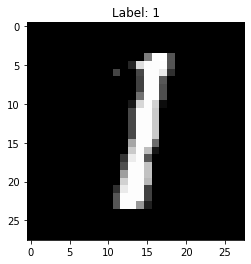

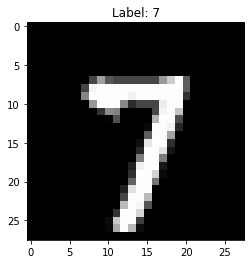

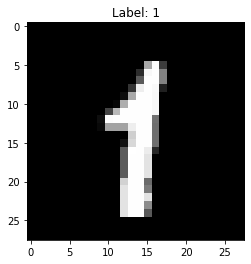

Feature 39 top 3 activations:


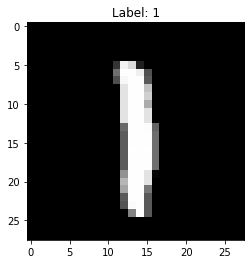

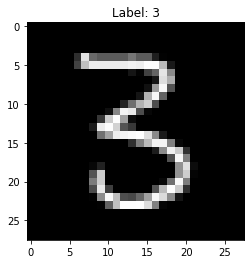

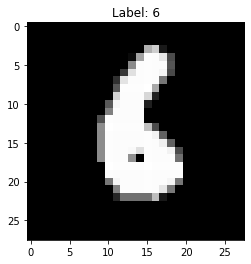

Feature 40 top 3 activations:


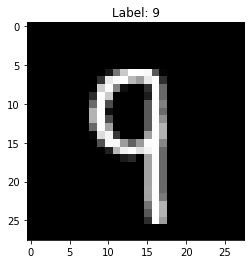

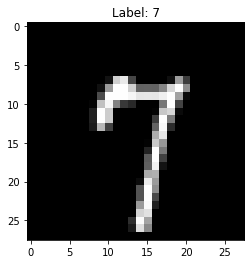

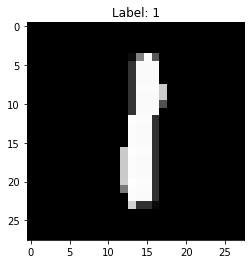

Feature 41 top 3 activations:


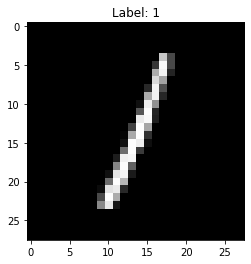

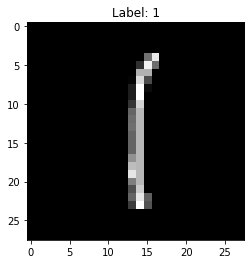

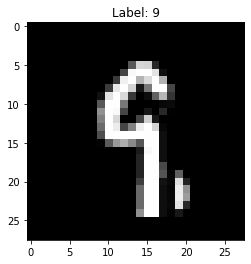

Feature 42 top 3 activations:


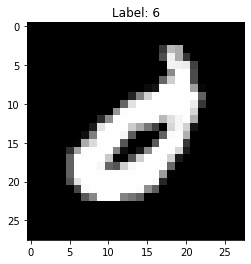

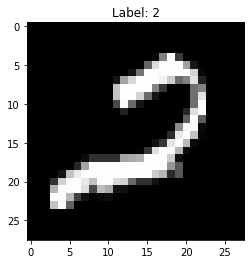

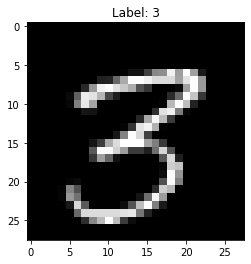

Feature 43 top 3 activations:


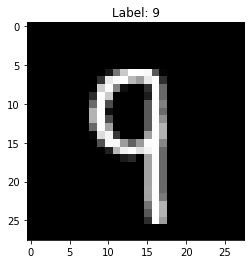

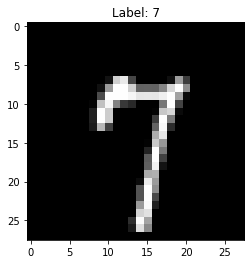

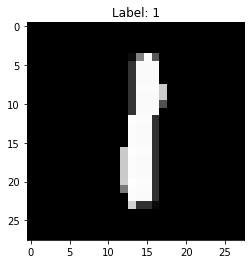

Feature 44 top 3 activations:


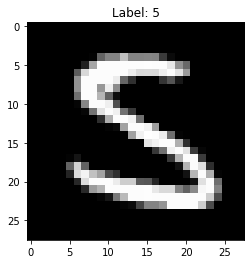

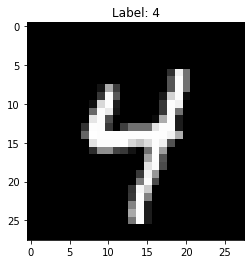

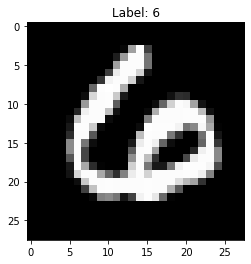

Feature 45 top 3 activations:


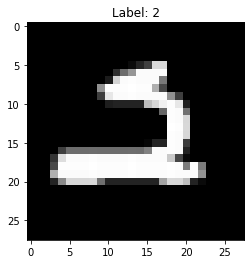

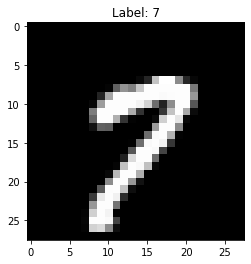

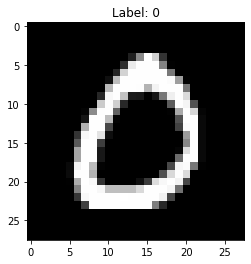

Feature 46 top 3 activations:


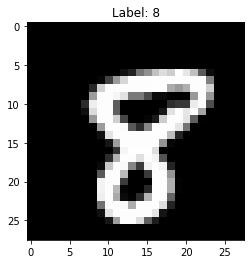

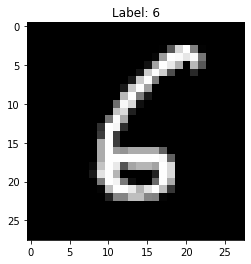

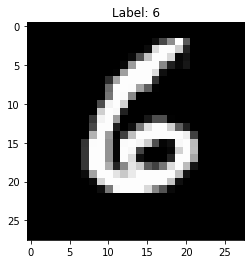

Feature 47 top 3 activations:


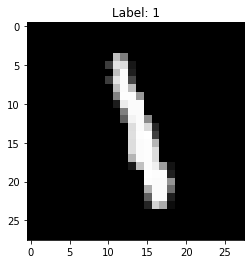

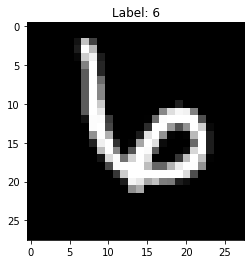

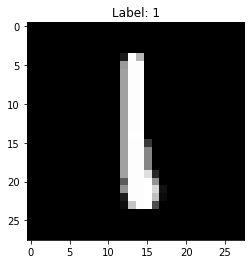

Feature 48 top 3 activations:


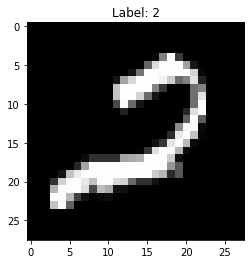

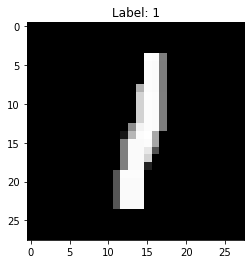

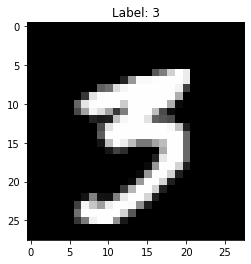

Feature 49 top 3 activations:


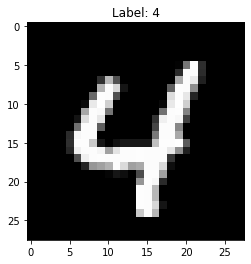

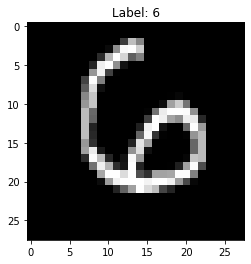

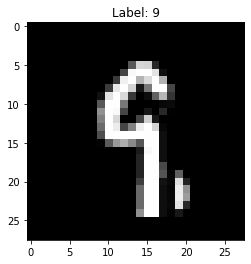

Feature 50 top 3 activations:


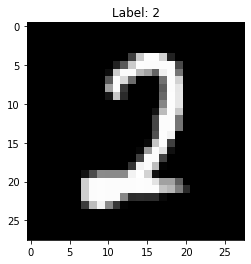

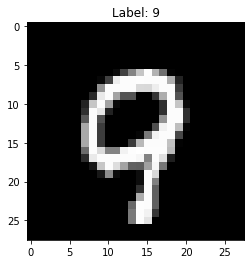

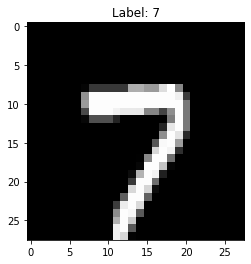

Feature 51 top 3 activations:


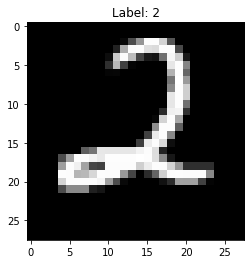

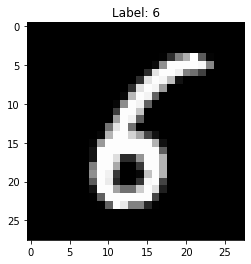

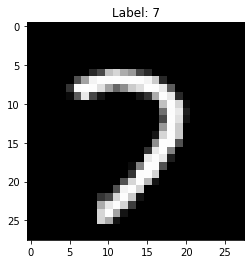

Feature 52 top 3 activations:


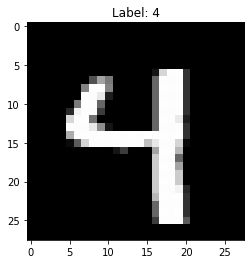

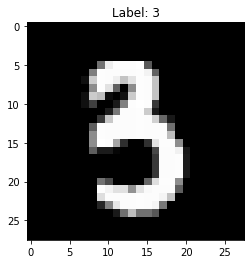

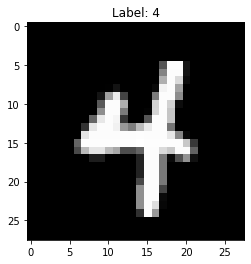

Feature 53 top 3 activations:


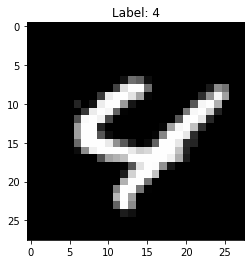

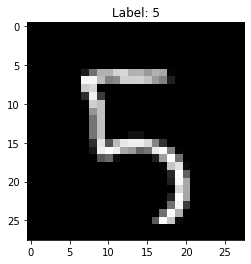

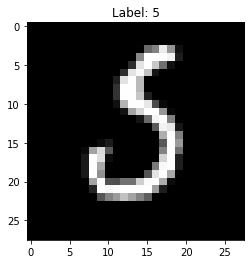

Feature 54 top 3 activations:


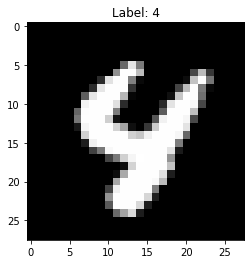

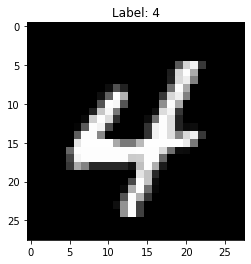

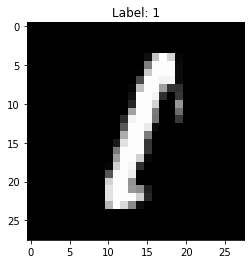

Feature 55 top 3 activations:


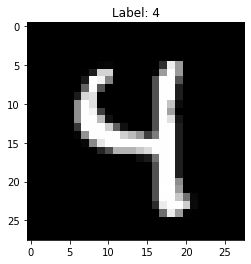

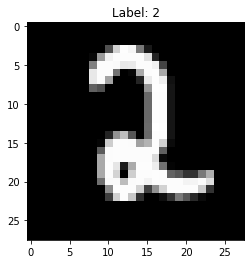

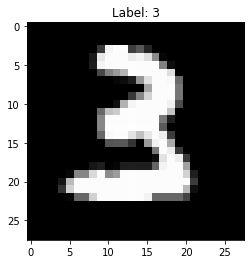

Feature 56 top 3 activations:


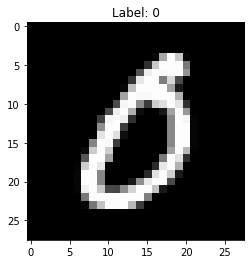

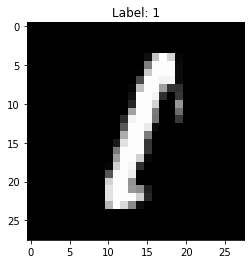

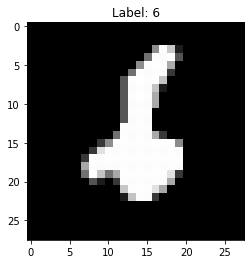

Feature 57 top 3 activations:


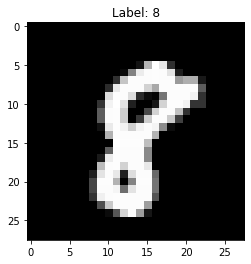

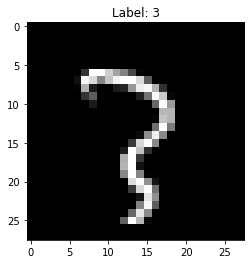

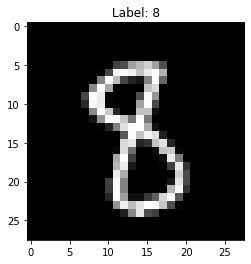

Feature 58 top 3 activations:


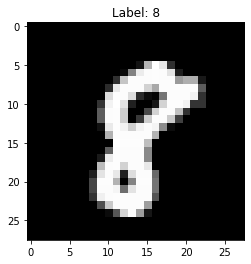

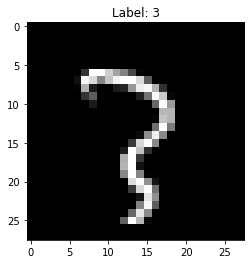

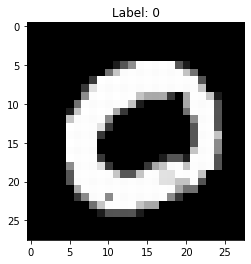

Feature 59 top 3 activations:


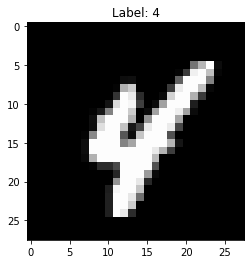

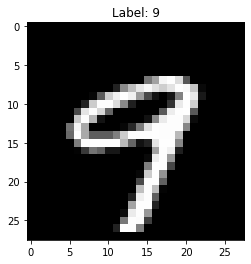

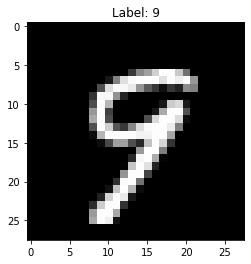

Feature 60 top 3 activations:


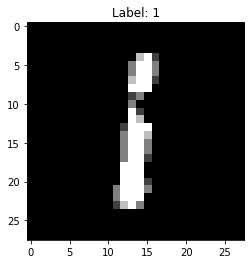

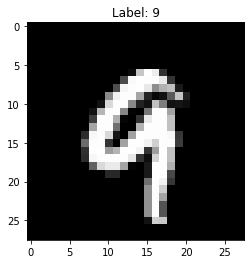

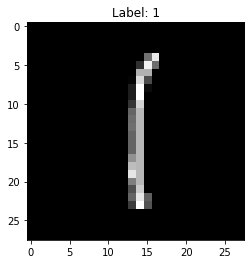

Feature 61 top 3 activations:


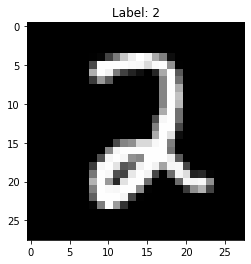

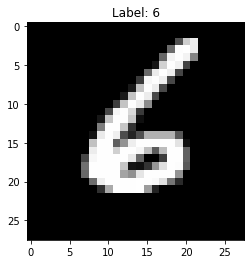

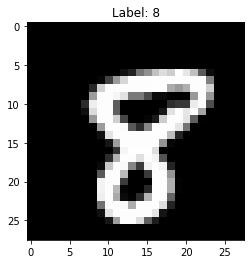

Feature 62 top 3 activations:


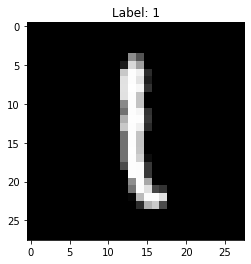

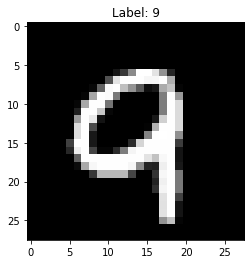

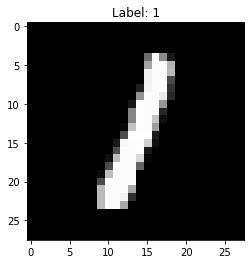

Feature 63 top 3 activations:


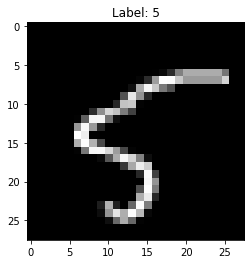

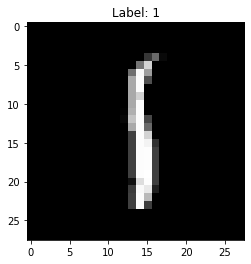

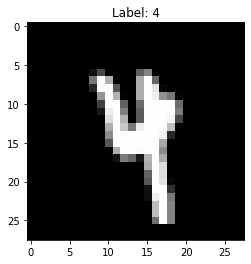

Feature 64 top 3 activations:


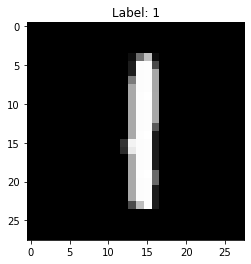

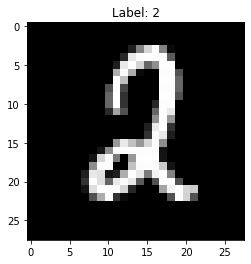

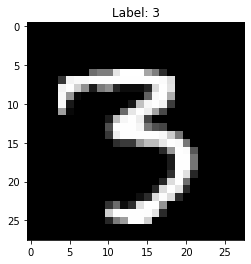

Feature 65 top 3 activations:


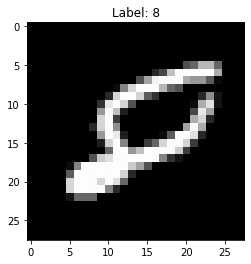

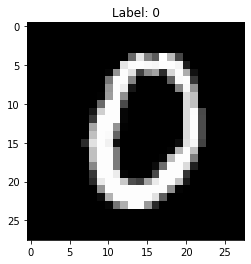

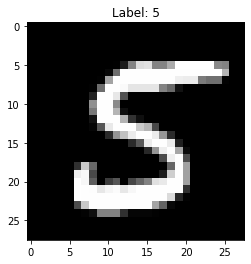

Feature 66 top 3 activations:


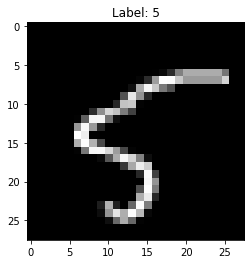

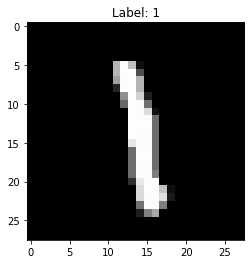

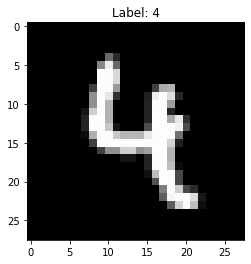

Feature 67 top 3 activations:


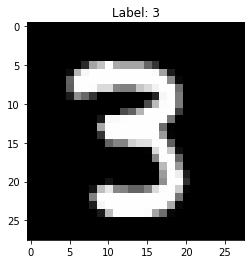

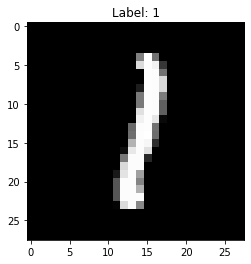

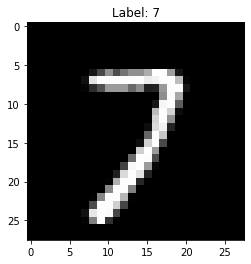

Feature 68 top 3 activations:


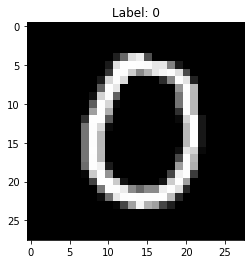

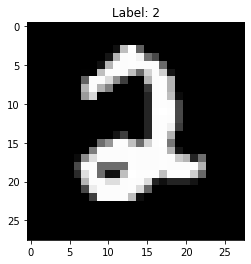

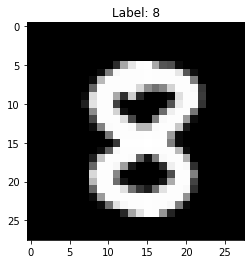

Feature 69 top 3 activations:


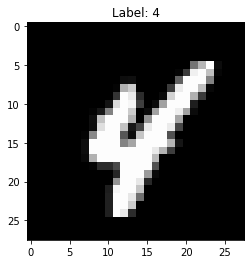

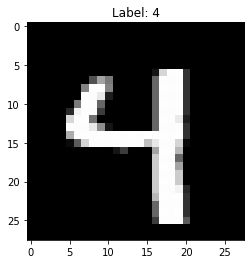

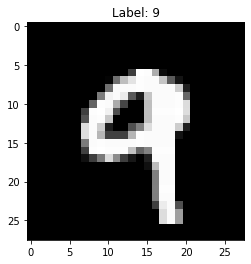

Feature 70 top 3 activations:


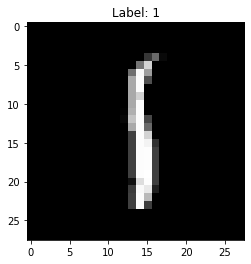

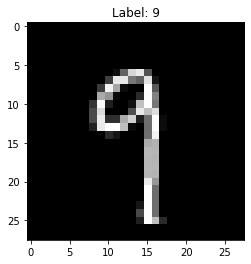

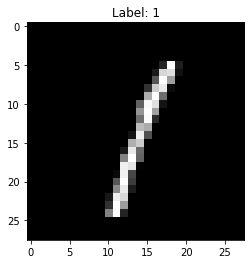

Feature 71 top 3 activations:


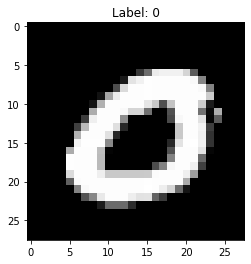

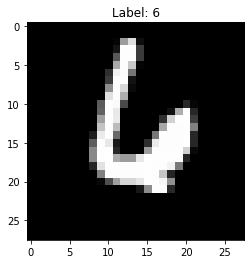

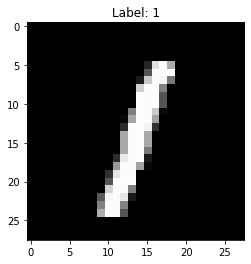

Feature 72 top 3 activations:


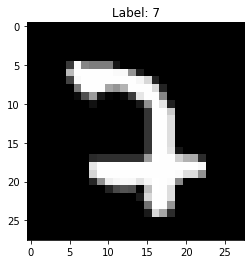

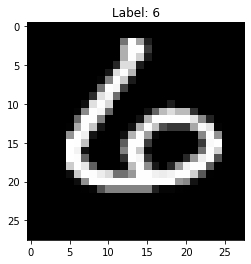

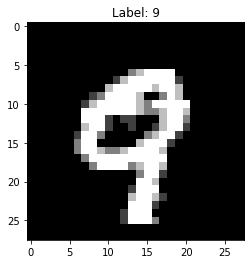

Feature 73 top 3 activations:


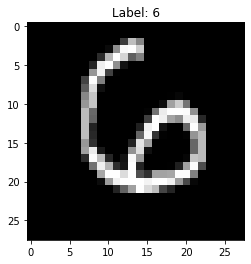

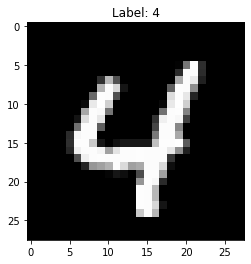

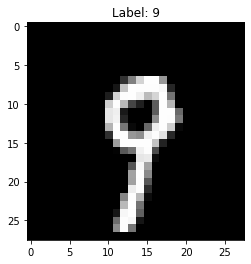

Feature 74 top 3 activations:


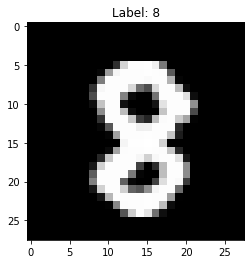

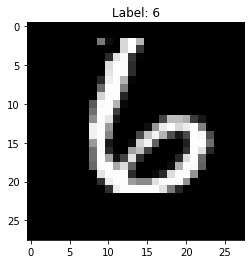

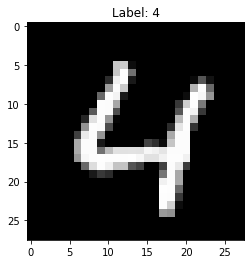

Feature 75 top 3 activations:


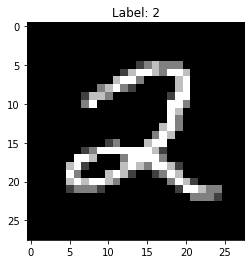

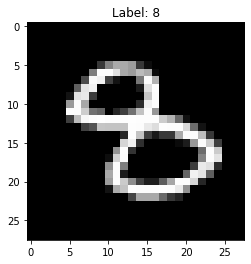

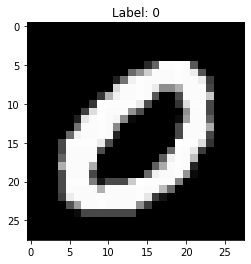

Feature 76 top 3 activations:


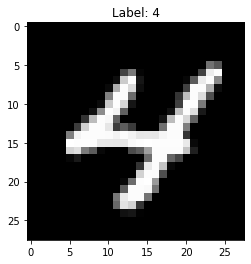

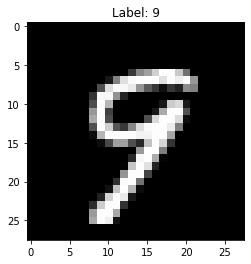

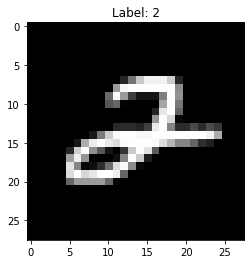

Feature 77 top 3 activations:


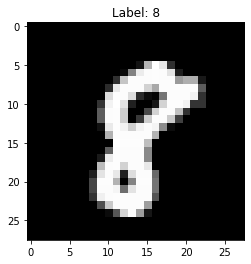

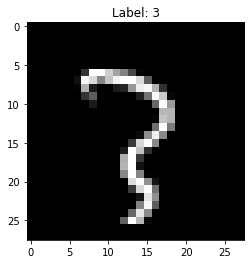

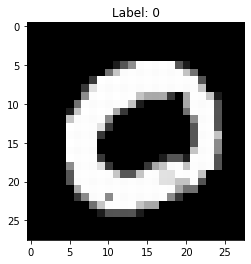

Feature 78 top 3 activations:


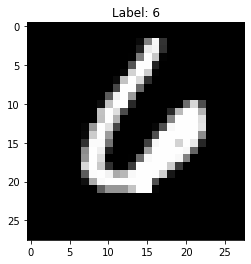

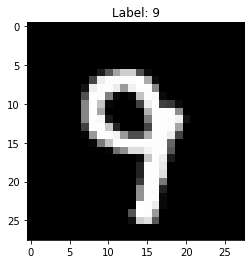

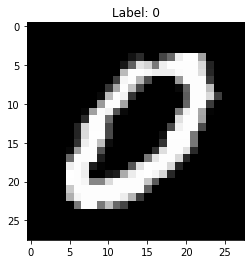

Feature 79 top 3 activations:


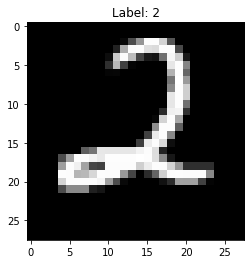

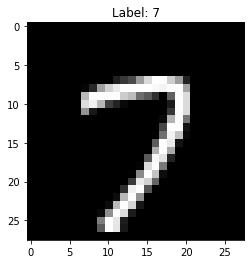

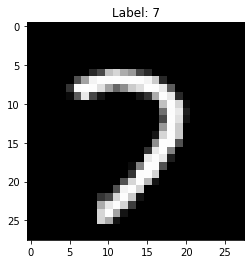

Feature 80 top 3 activations:


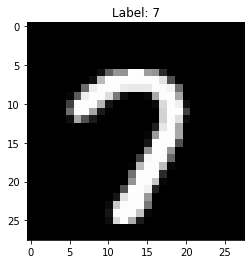

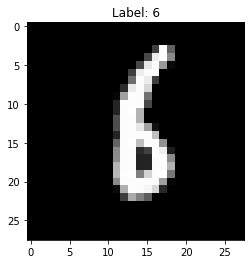

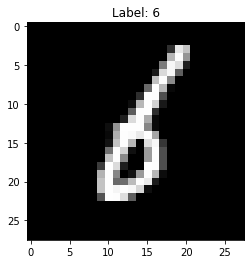

Feature 81 top 3 activations:


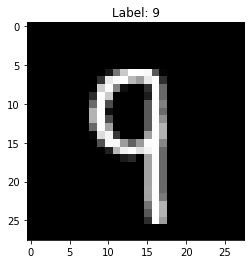

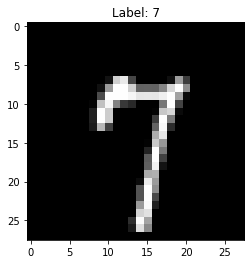

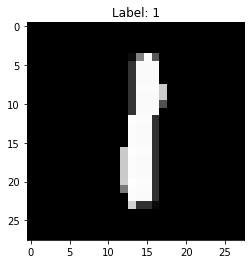

Feature 82 top 3 activations:


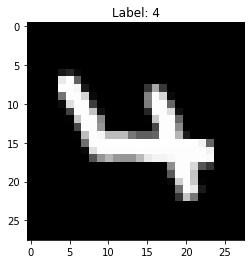

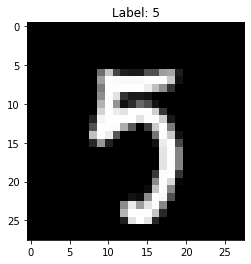

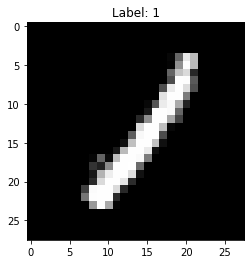

Feature 83 top 3 activations:


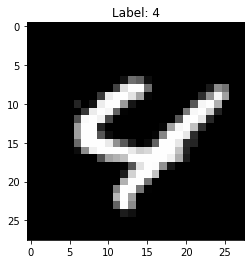

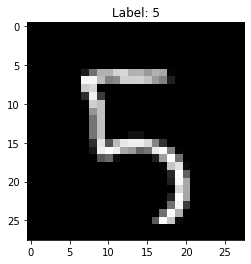

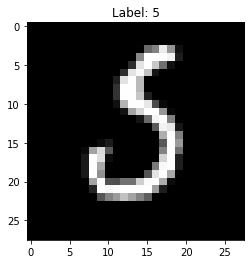

Feature 84 top 3 activations:


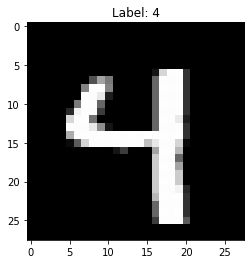

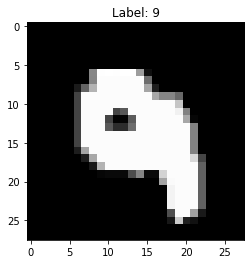

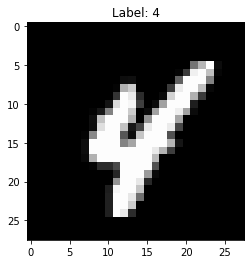

Feature 85 top 3 activations:


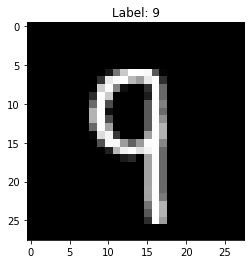

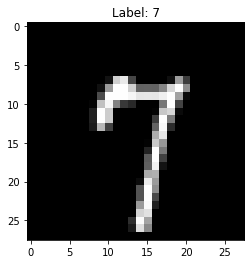

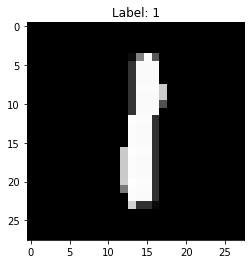

Feature 86 top 3 activations:


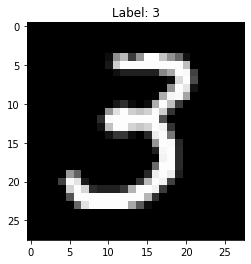

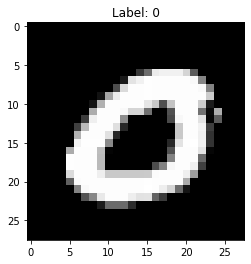

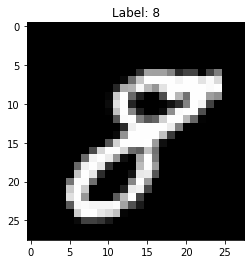

Feature 87 top 3 activations:


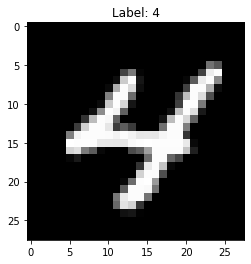

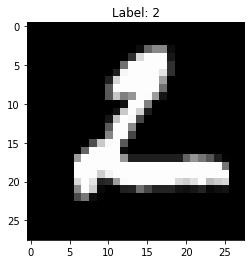

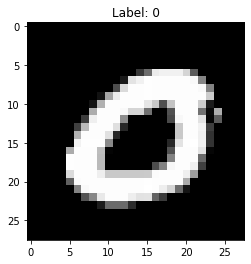

Feature 88 top 3 activations:


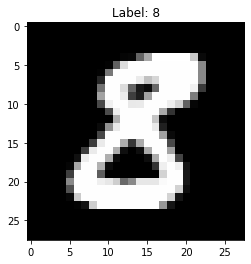

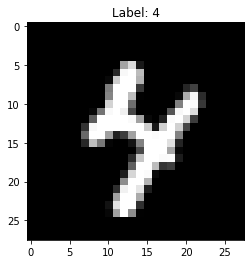

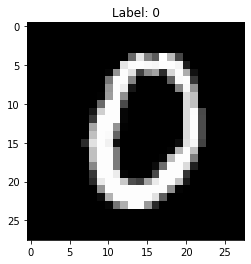

Feature 89 top 3 activations:


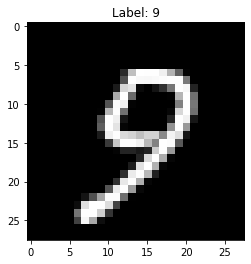

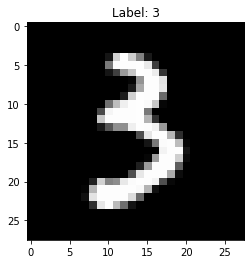

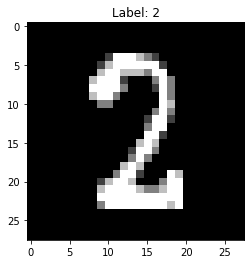

Feature 90 top 3 activations:


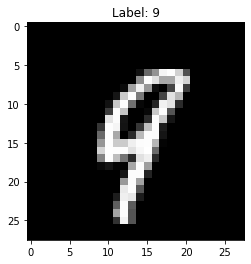

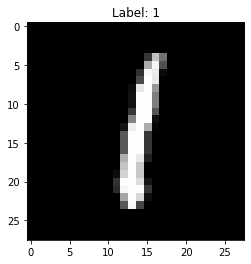

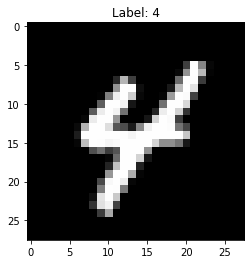

Feature 91 top 3 activations:


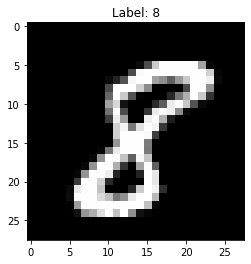

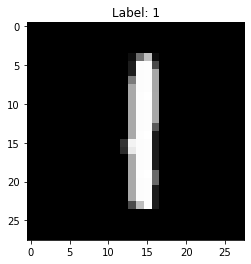

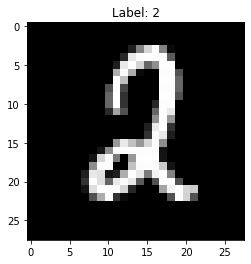

Feature 92 top 3 activations:


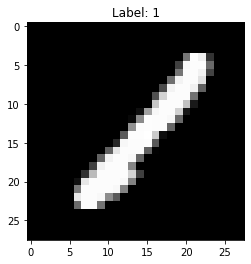

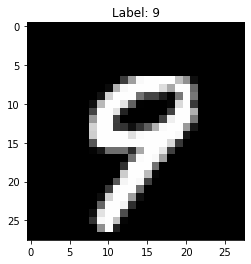

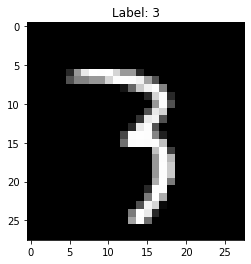

Feature 93 top 3 activations:


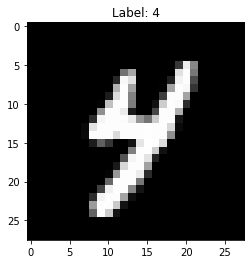

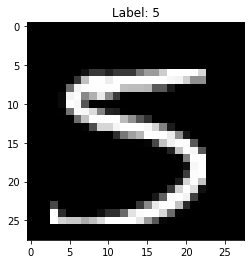

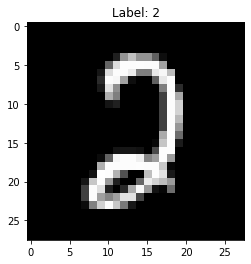

Feature 94 top 3 activations:


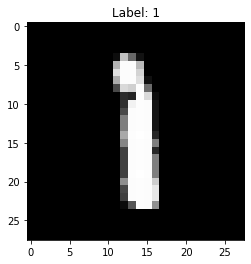

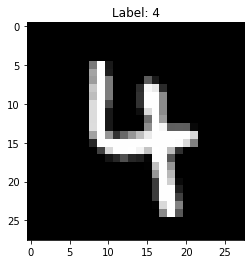

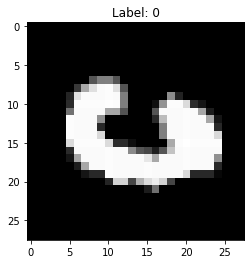

Feature 95 top 3 activations:


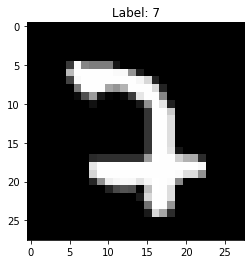

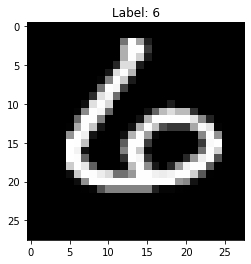

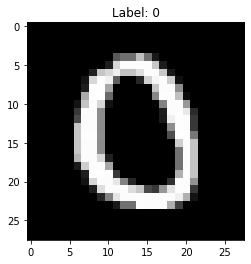

Feature 96 top 3 activations:


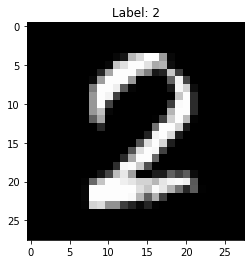

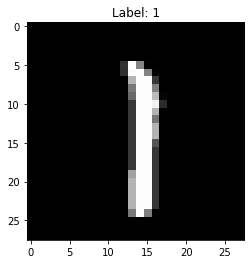

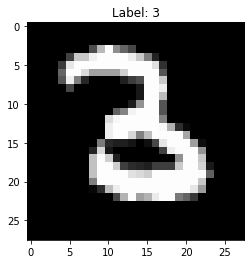

Feature 97 top 3 activations:


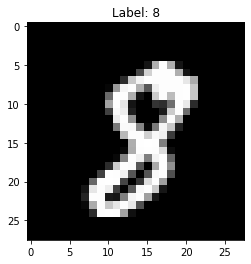

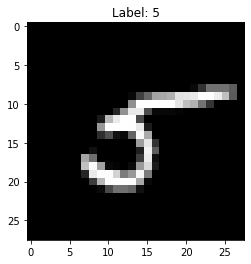

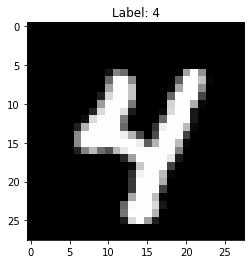

Feature 98 top 3 activations:


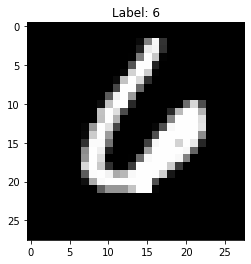

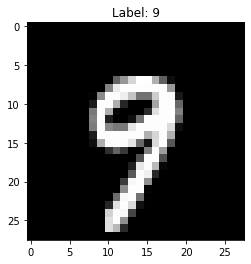

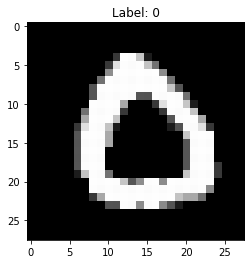

Feature 99 top 3 activations:


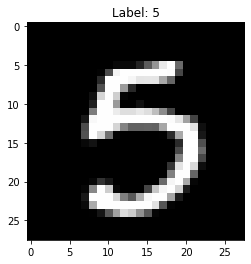

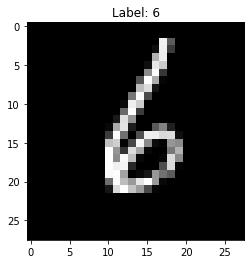

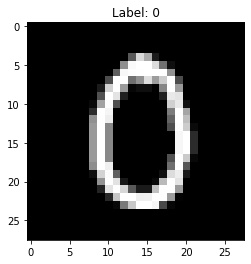

Feature 100 top 3 activations:


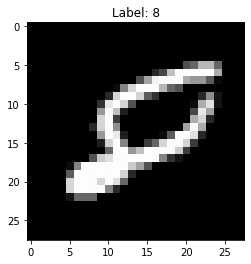

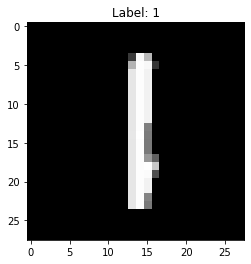

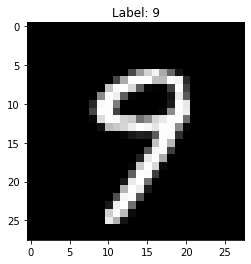

Feature 101 top 3 activations:


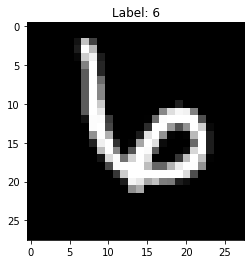

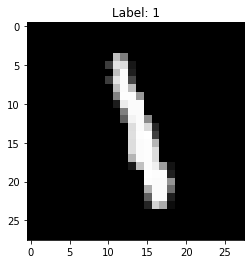

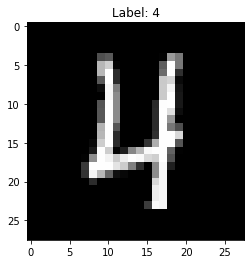

Feature 102 top 3 activations:


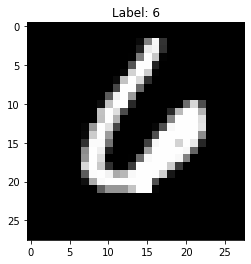

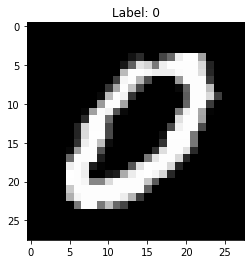

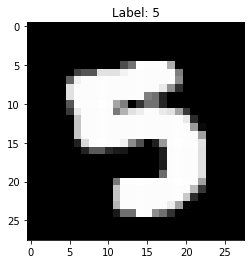

Feature 103 top 3 activations:


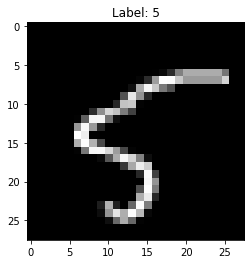

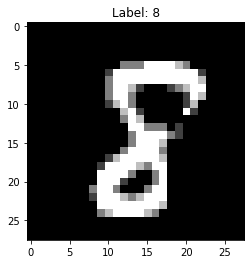

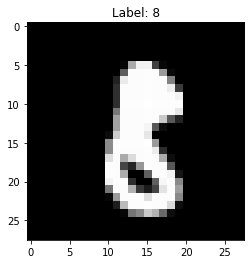

Feature 104 top 3 activations:


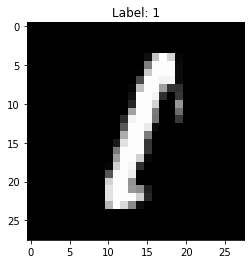

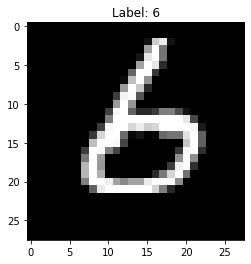

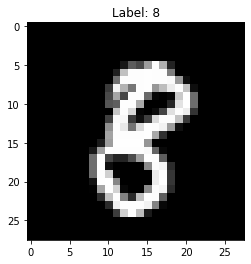

Feature 105 top 3 activations:


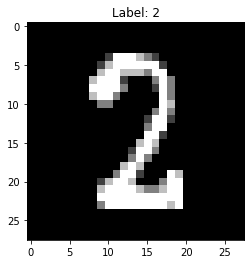

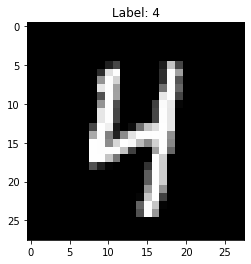

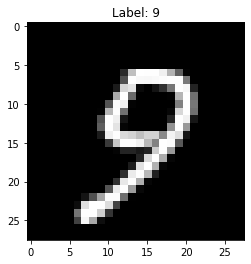

Feature 106 top 3 activations:


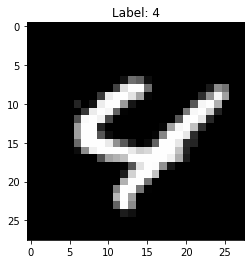

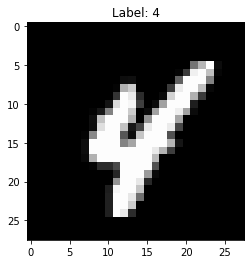

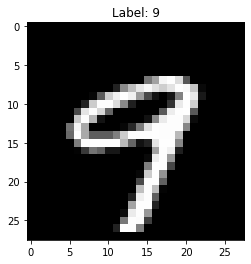

Feature 107 top 3 activations:


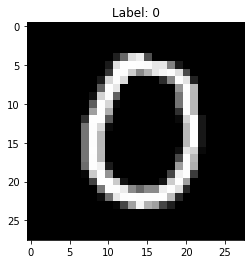

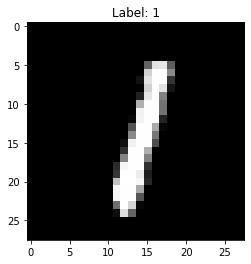

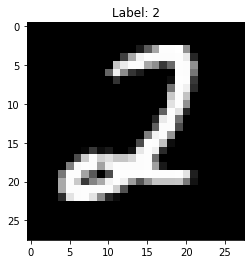

Feature 108 top 3 activations:


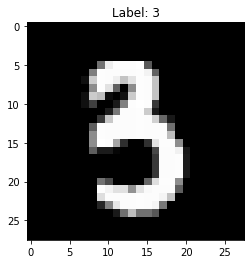

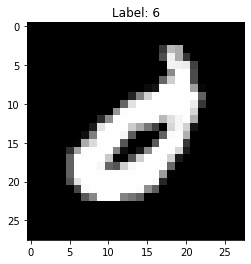

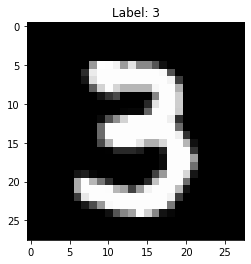

Feature 109 top 3 activations:


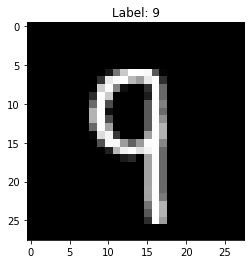

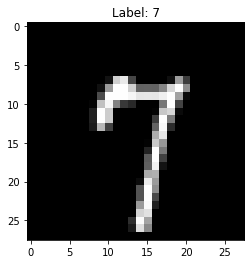

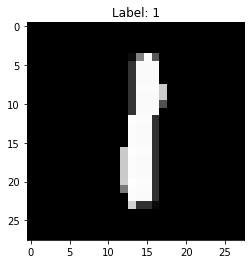

Feature 110 top 3 activations:


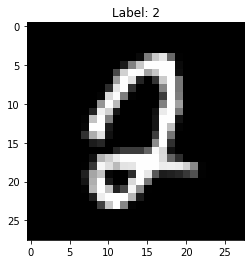

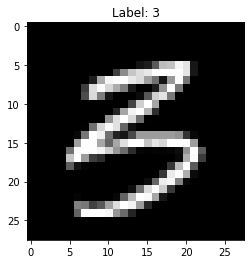

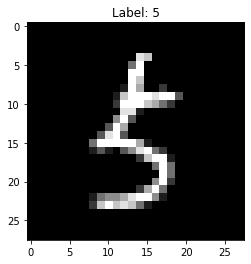

Feature 111 top 3 activations:


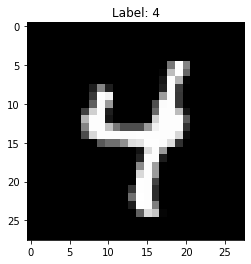

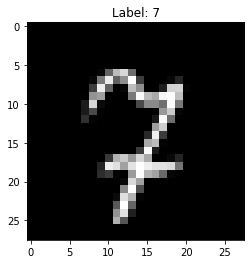

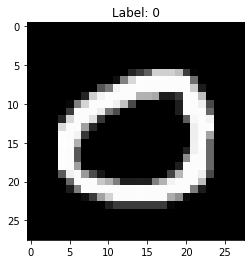

Feature 112 top 3 activations:


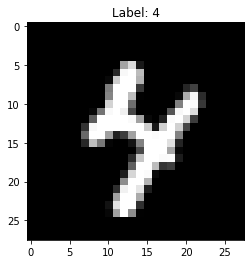

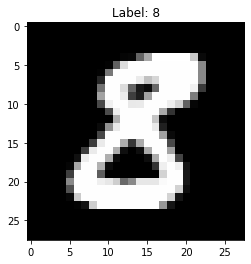

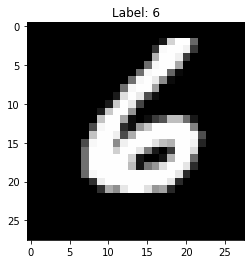

Feature 113 top 3 activations:


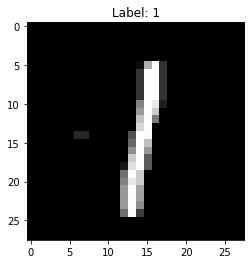

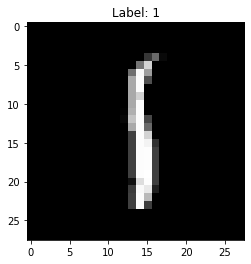

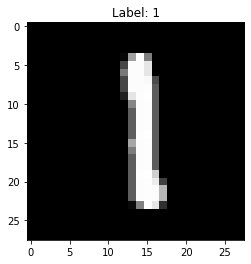

Feature 114 top 3 activations:


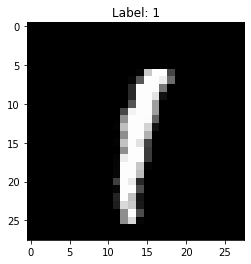

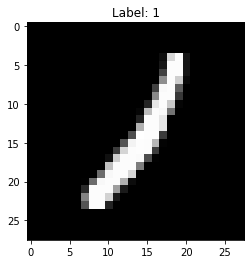

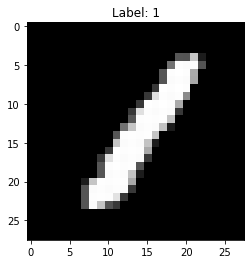

Feature 115 top 3 activations:


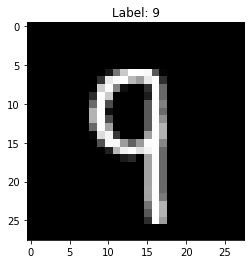

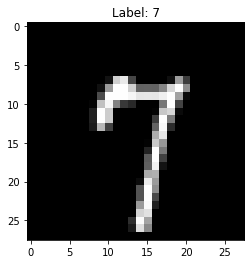

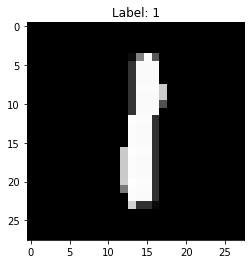

Feature 116 top 3 activations:


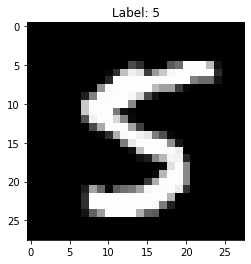

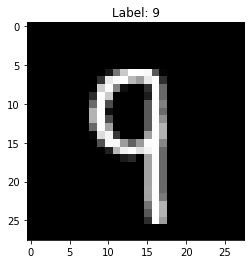

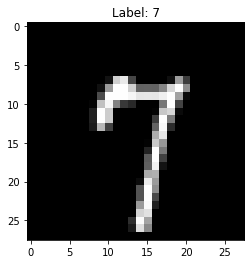

Feature 117 top 3 activations:


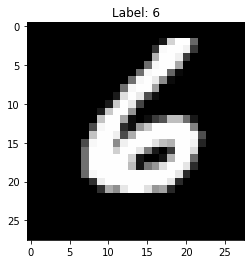

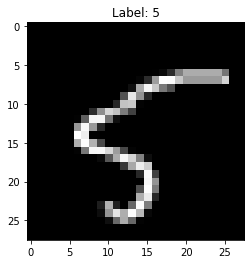

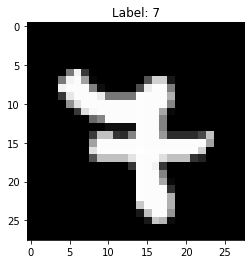

Feature 118 top 3 activations:


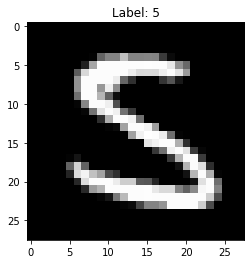

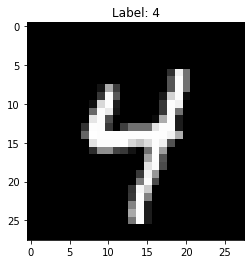

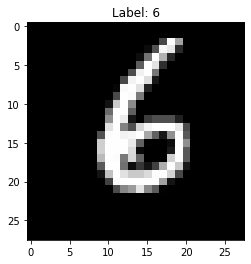

Feature 119 top 3 activations:


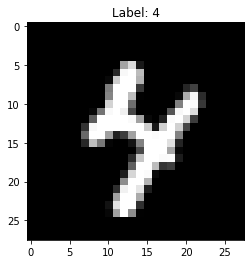

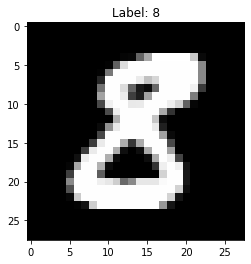

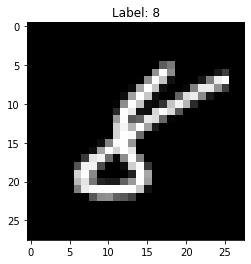

Feature 120 top 3 activations:


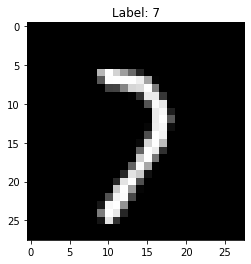

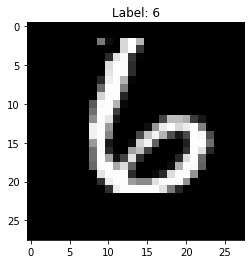

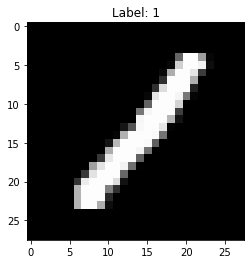

Feature 121 top 3 activations:


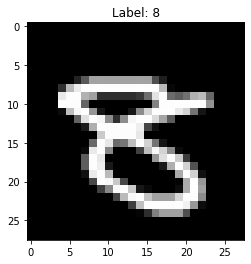

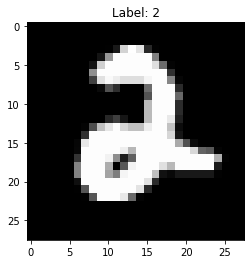

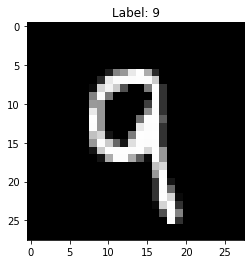

Feature 122 top 3 activations:


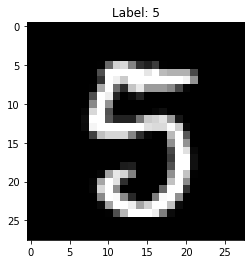

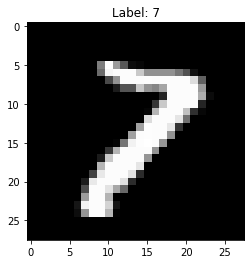

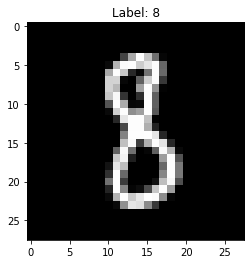

Feature 123 top 3 activations:


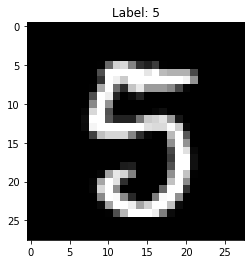

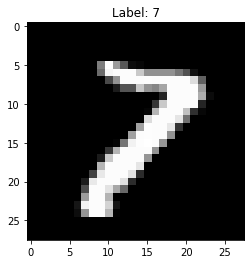

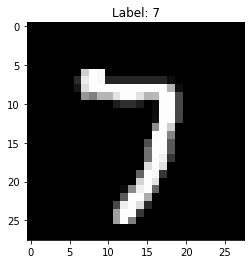

Feature 124 top 3 activations:


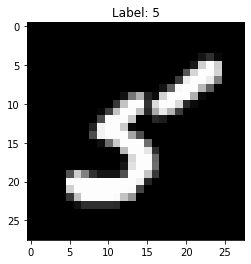

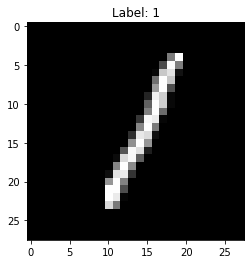

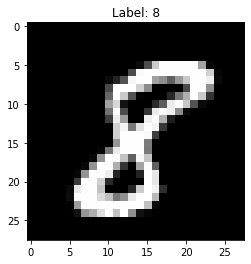

Feature 125 top 3 activations:


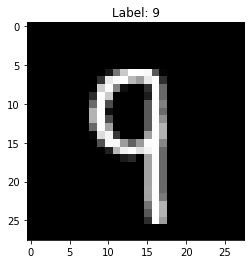

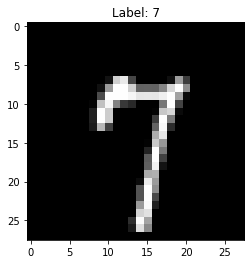

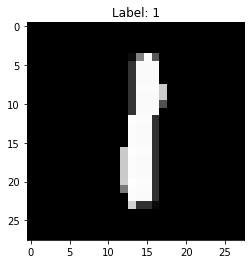

Feature 126 top 3 activations:


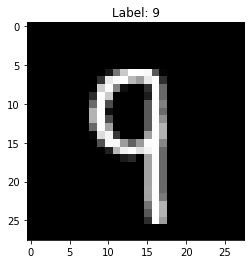

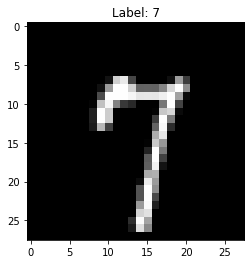

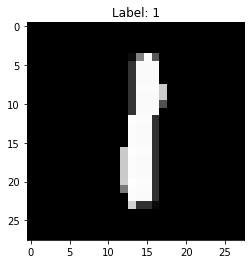

Feature 127 top 3 activations:


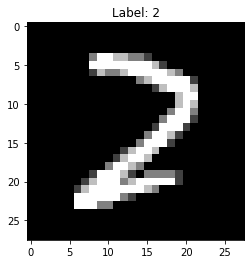

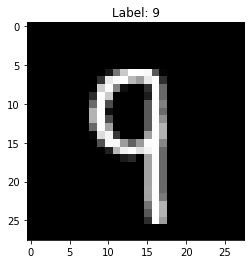

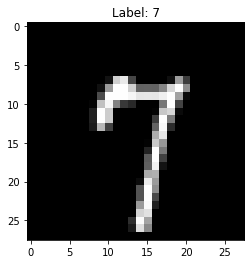

Feature 128 top 3 activations:


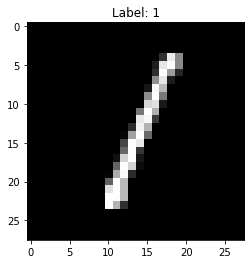

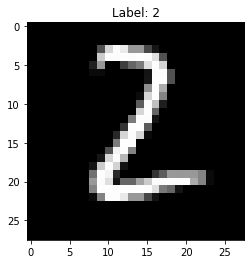

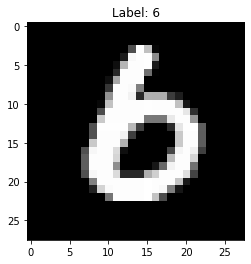

Feature 129 top 3 activations:


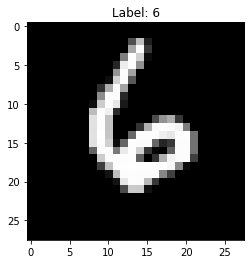

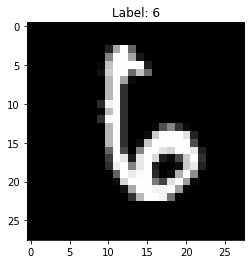

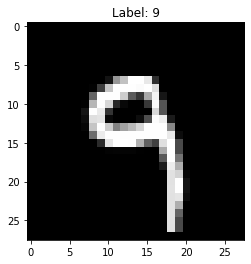

Feature 130 top 3 activations:


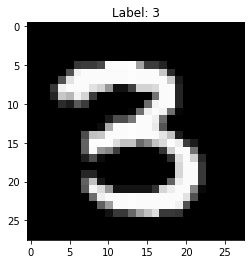

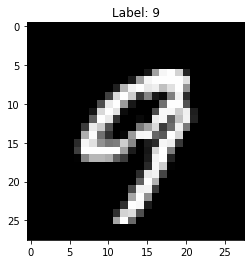

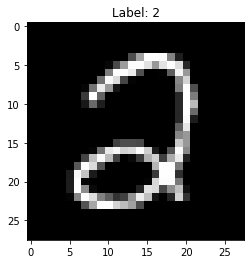

Feature 131 top 3 activations:


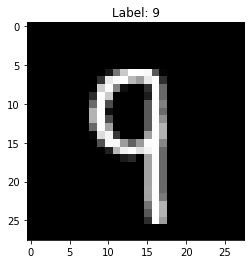

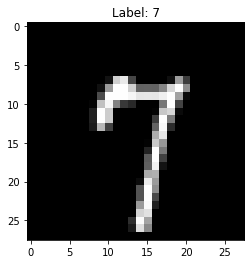

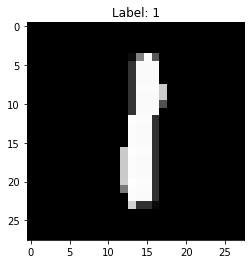

Feature 132 top 3 activations:


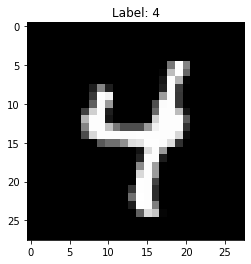

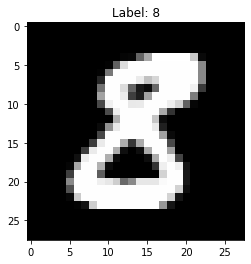

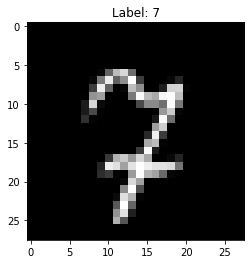

Feature 133 top 3 activations:


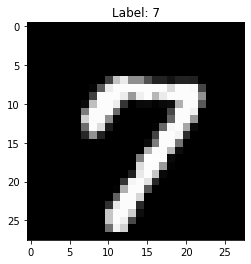

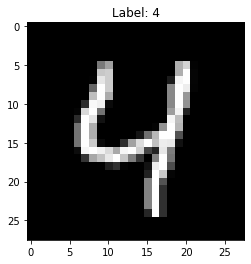

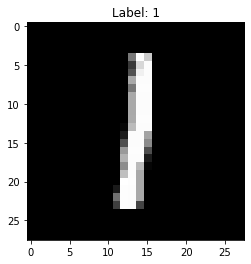

Feature 134 top 3 activations:


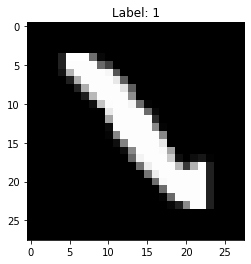

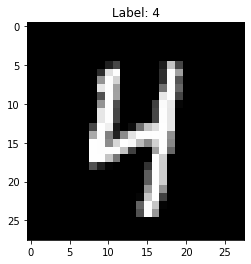

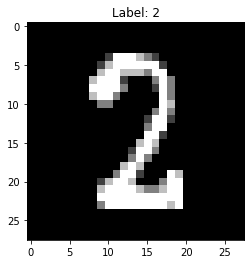

Feature 135 top 3 activations:


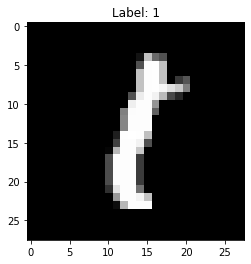

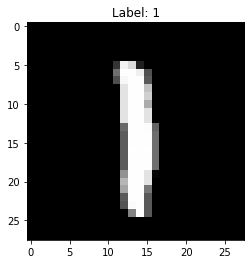

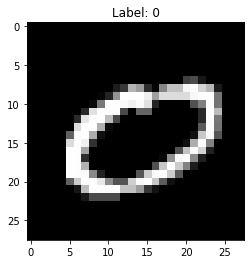

Feature 136 top 3 activations:


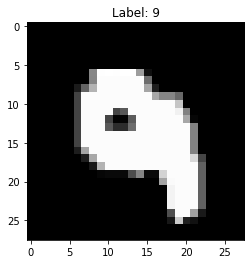

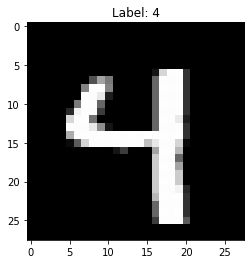

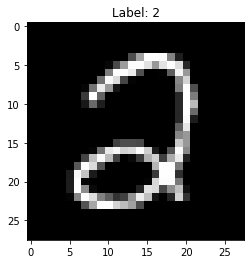

Feature 137 top 3 activations:


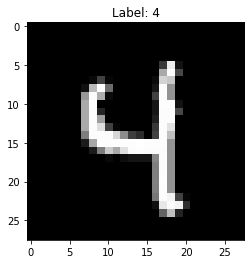

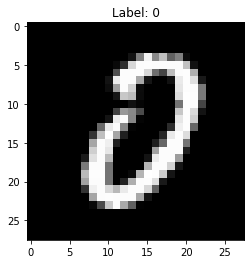

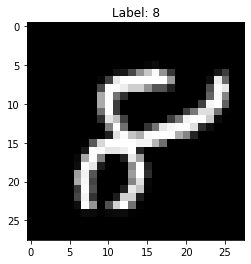

Feature 138 top 3 activations:


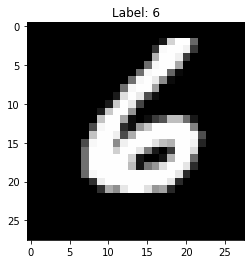

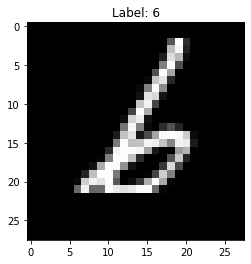

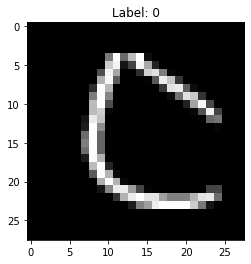

Feature 139 top 3 activations:


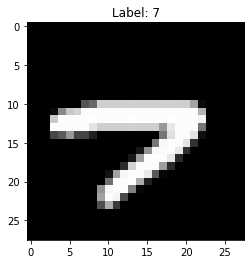

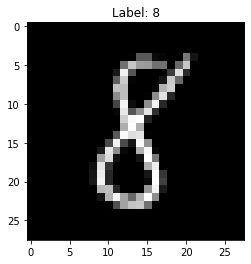

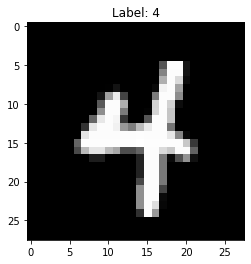

Feature 140 top 3 activations:


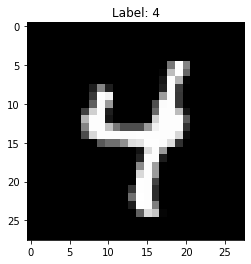

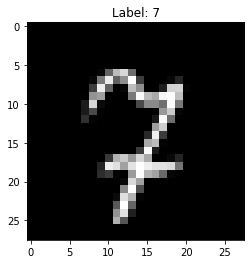

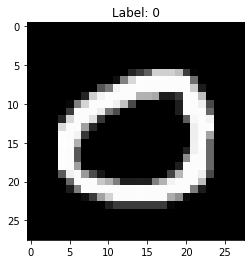

Feature 141 top 3 activations:


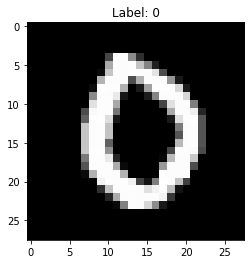

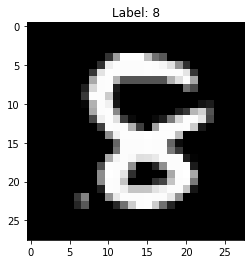

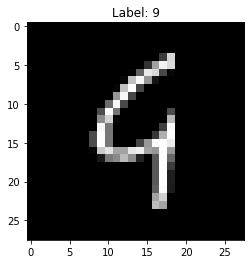

Feature 142 top 3 activations:


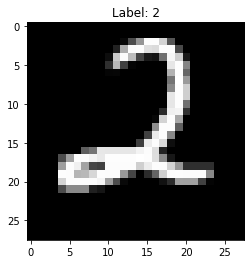

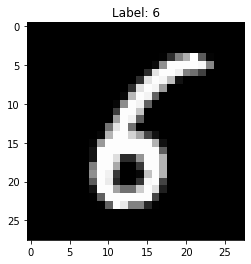

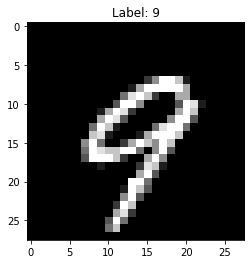

Feature 143 top 3 activations:


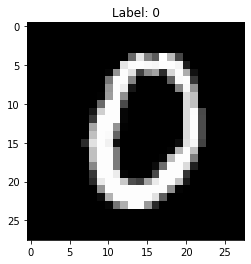

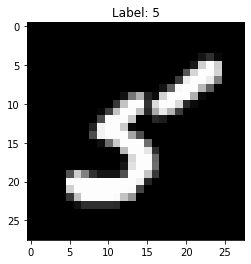

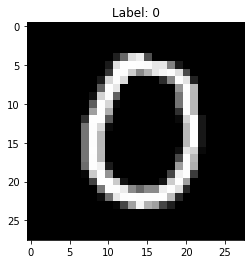

Feature 144 top 3 activations:


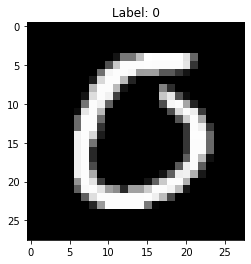

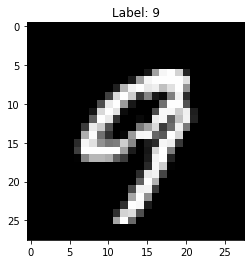

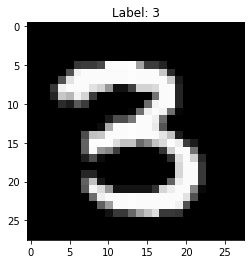

Feature 145 top 3 activations:


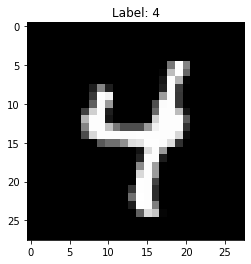

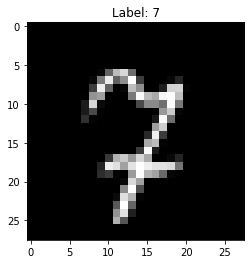

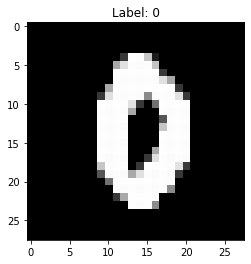

Feature 146 top 3 activations:


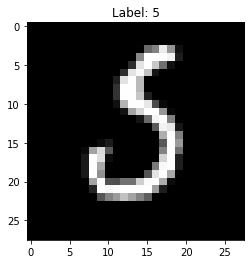

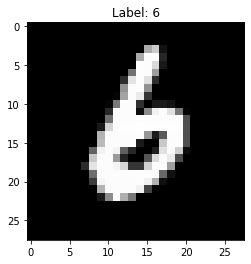

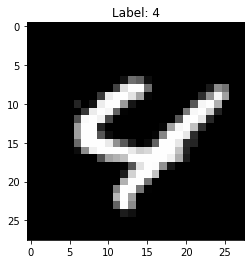

Feature 147 top 3 activations:


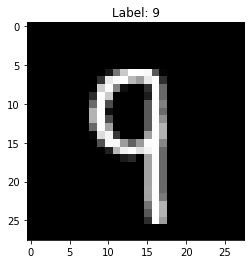

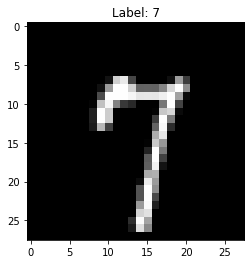

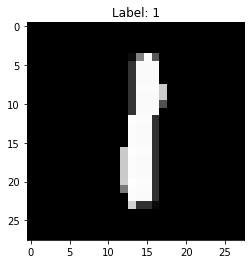

Feature 148 top 3 activations:


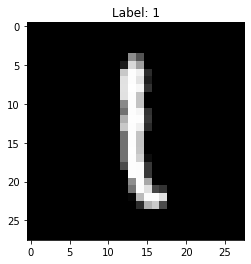

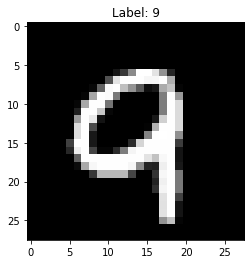

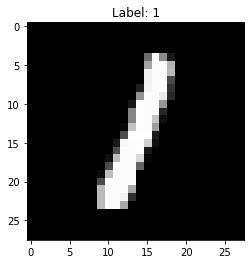

Feature 149 top 3 activations:


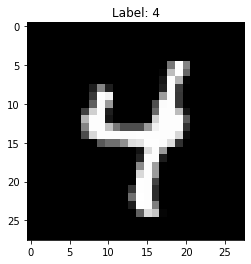

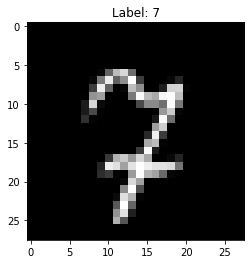

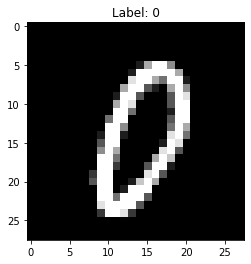

Feature 150 top 3 activations:


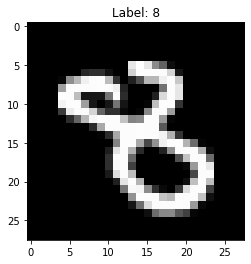

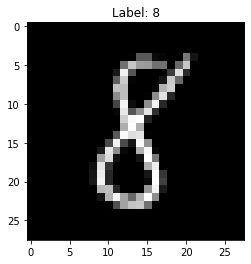

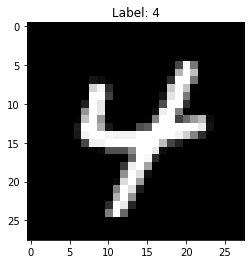

Feature 151 top 3 activations:


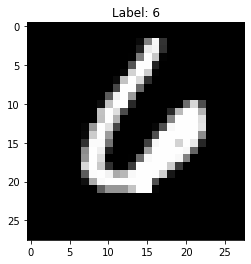

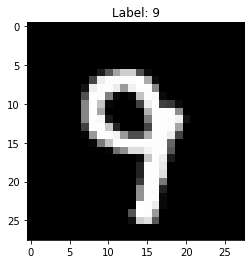

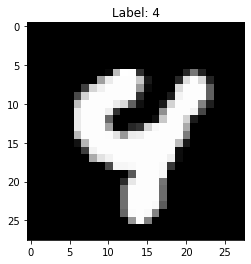

Feature 152 top 3 activations:


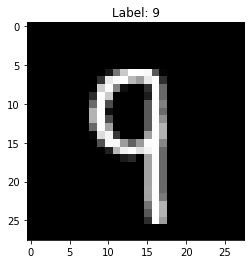

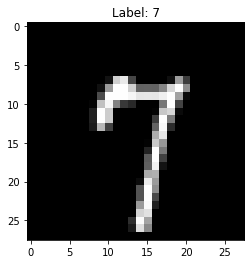

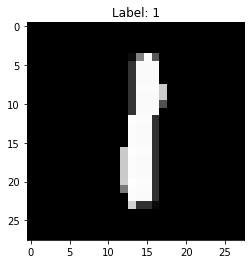

Feature 153 top 3 activations:


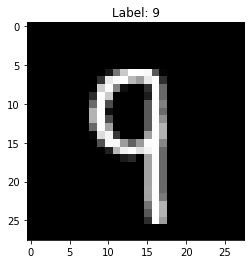

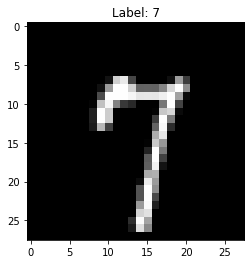

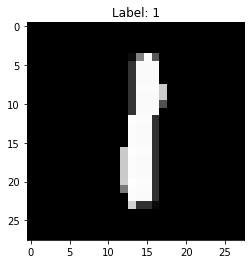

Feature 154 top 3 activations:


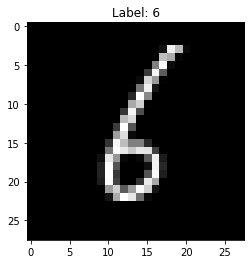

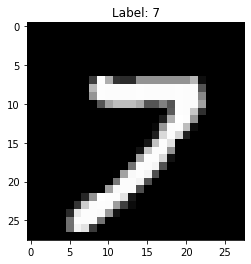

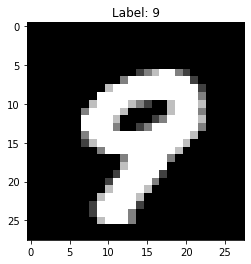

Feature 155 top 3 activations:


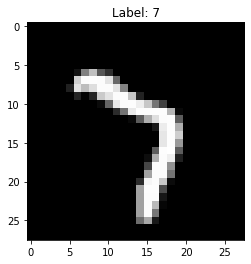

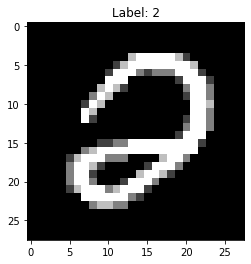

Feature 156 top 3 activations:


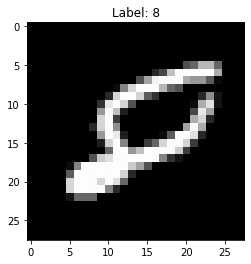

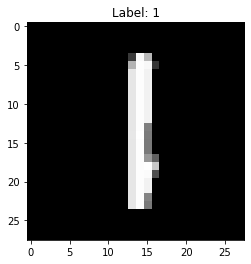

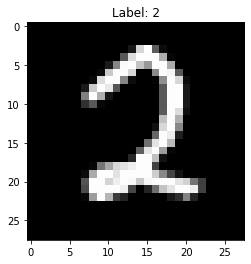

Feature 157 top 3 activations:


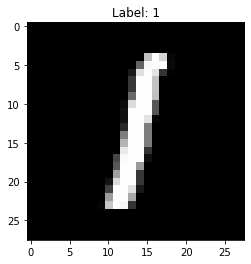

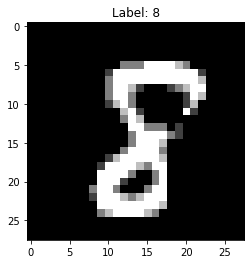

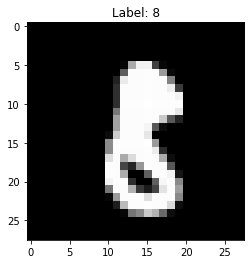

Feature 158 top 3 activations:


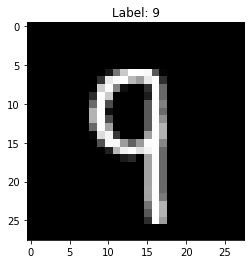

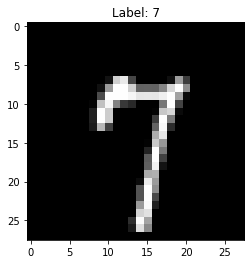

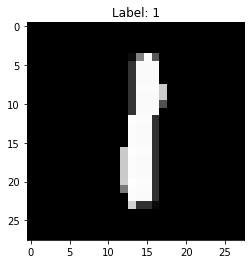

Feature 159 top 3 activations:


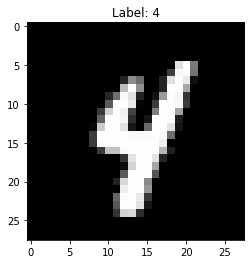

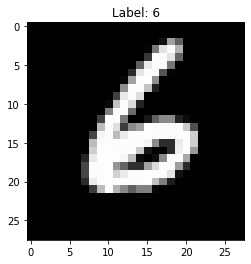

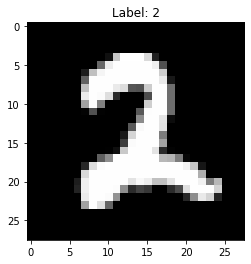

Feature 160 top 3 activations:


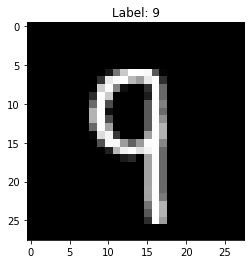

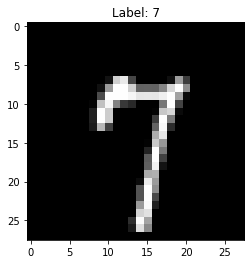

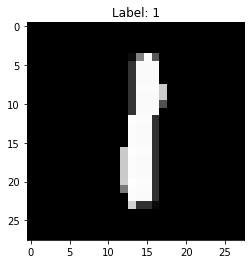

Feature 161 top 3 activations:


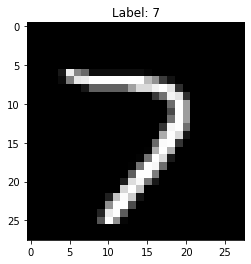

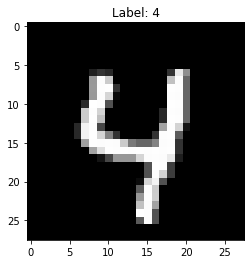

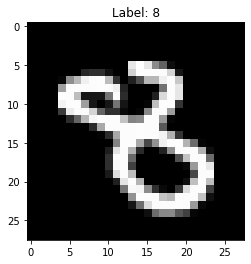

Feature 162 top 3 activations:


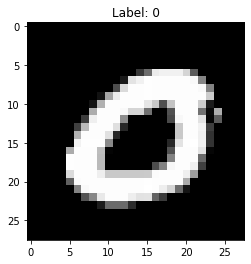

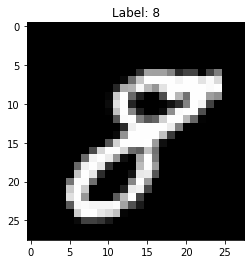

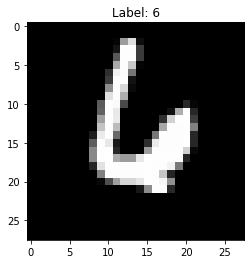

Feature 163 top 3 activations:


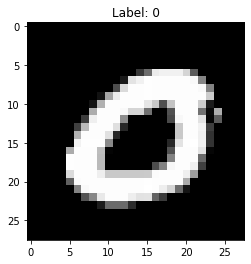

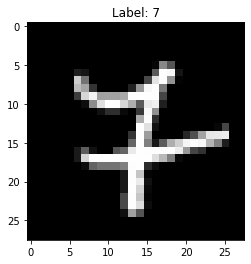

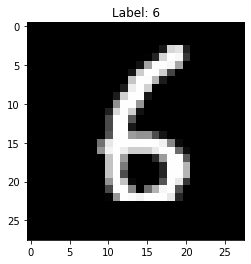

Feature 164 top 3 activations:


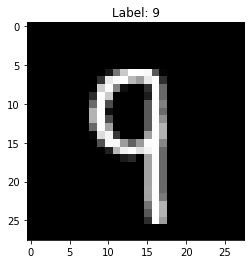

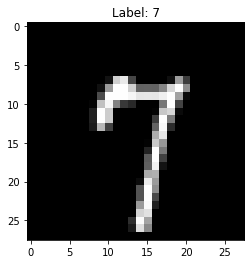

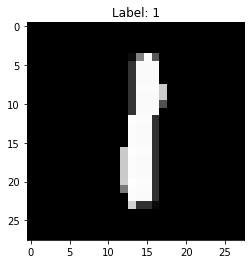

Feature 165 top 3 activations:


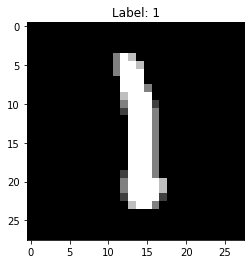

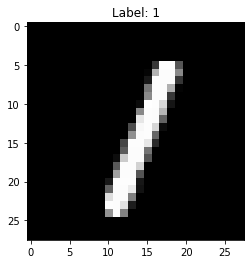

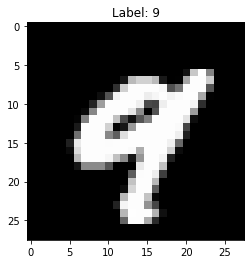

Feature 166 top 3 activations:


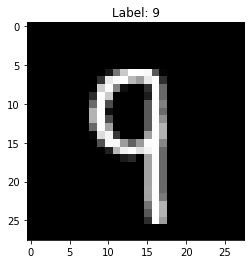

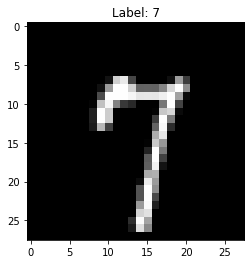

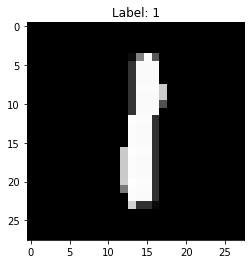

Feature 167 top 3 activations:


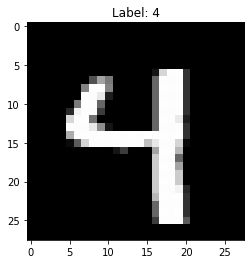

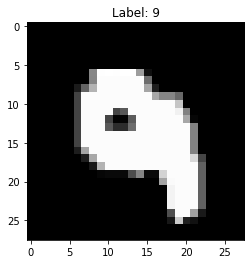

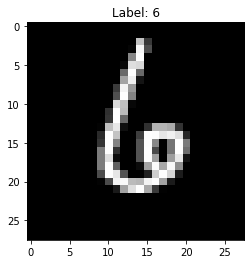

Feature 168 top 3 activations:


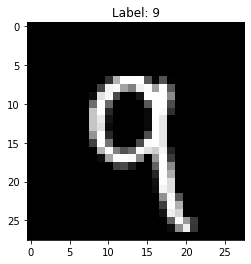

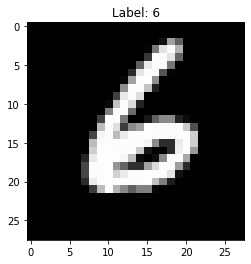

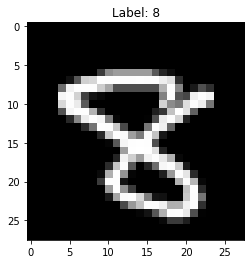

Feature 169 top 3 activations:


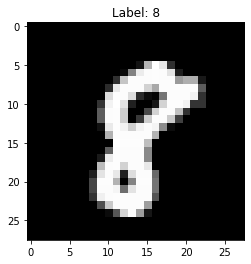

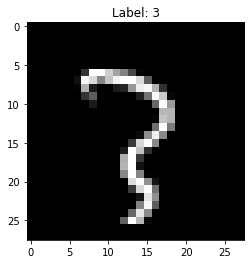

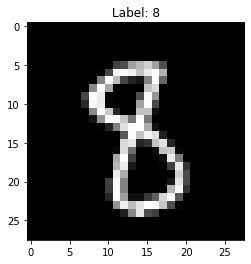

Feature 170 top 3 activations:


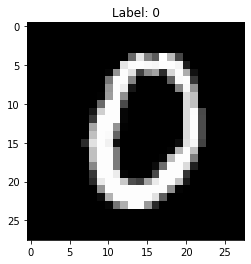

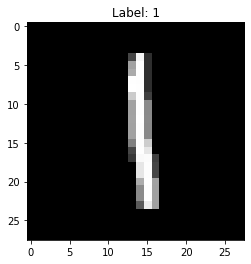

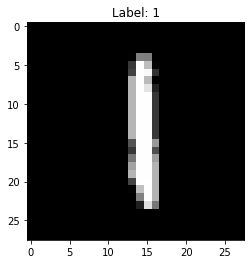

Feature 171 top 3 activations:


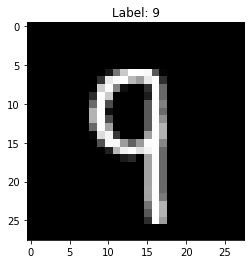

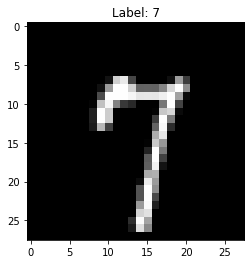

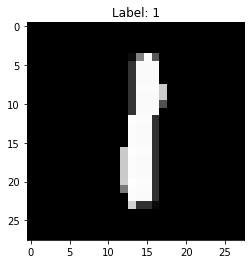

Feature 172 top 3 activations:


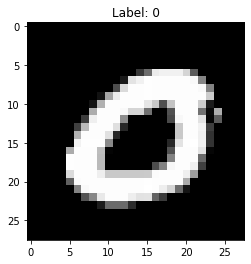

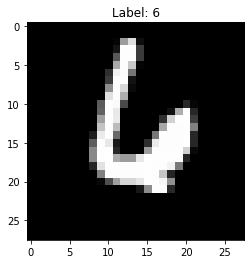

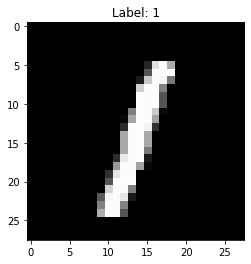

Feature 173 top 3 activations:


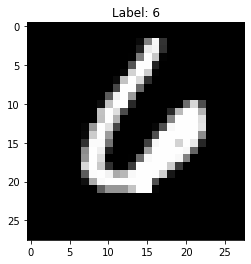

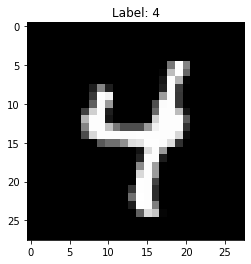

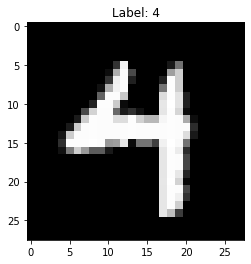

Feature 174 top 3 activations:


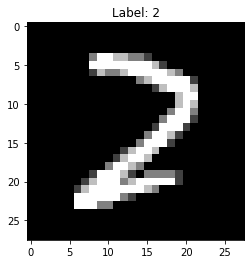

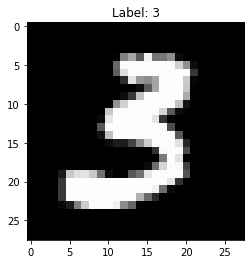

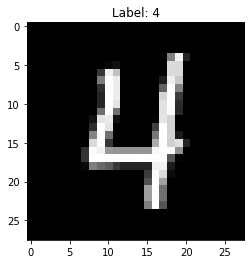

Feature 175 top 3 activations:


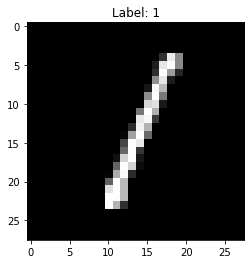

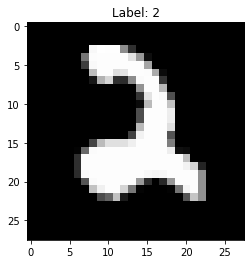

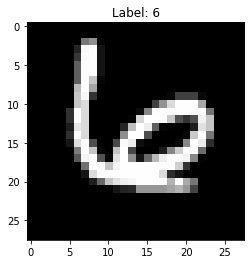

Feature 176 top 3 activations:


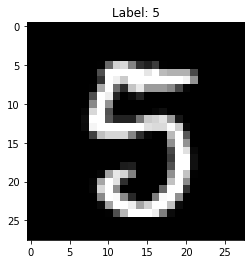

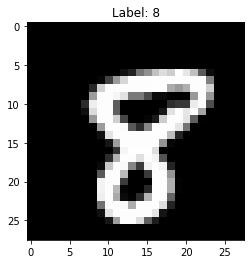

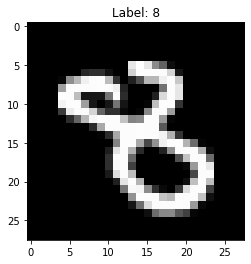

Feature 177 top 3 activations:


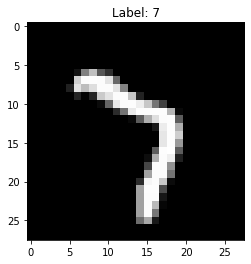

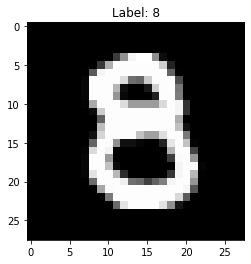

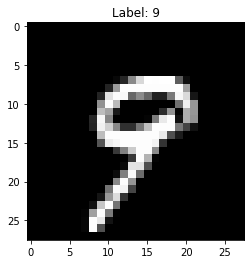

Feature 178 top 3 activations:


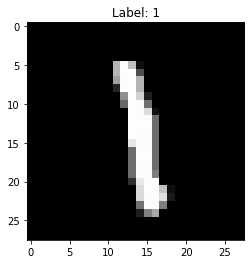

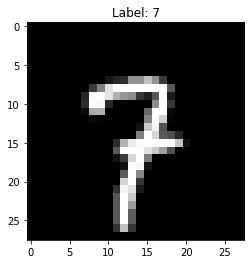

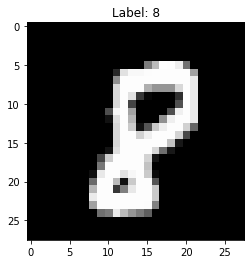

Feature 179 top 3 activations:


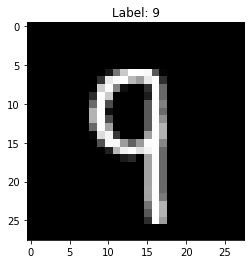

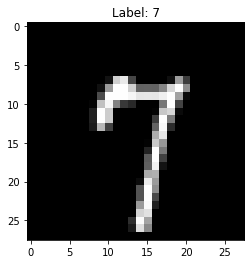

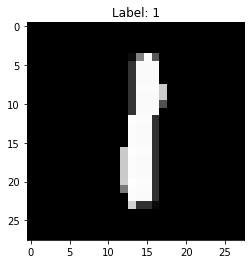

Feature 180 top 3 activations:


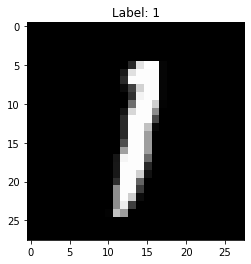

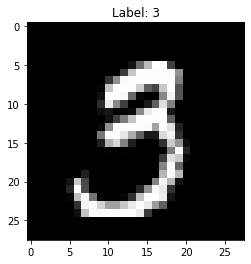

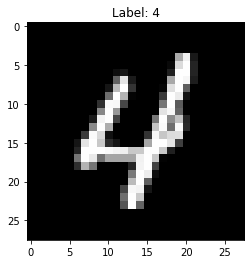

Feature 181 top 3 activations:


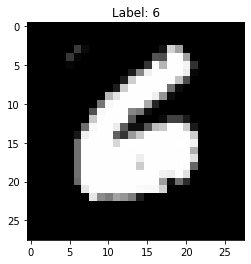

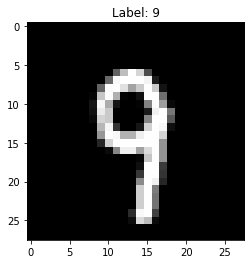

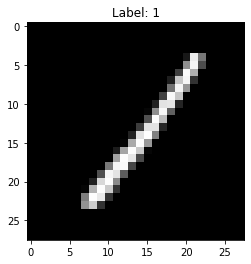

Feature 182 top 3 activations:


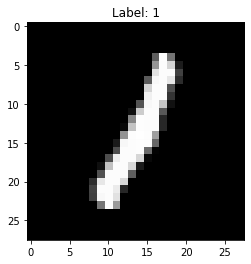

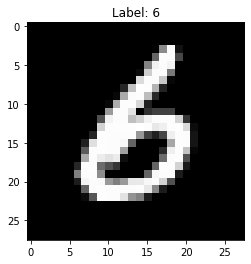

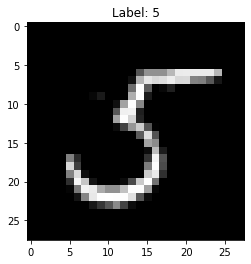

Feature 183 top 3 activations:


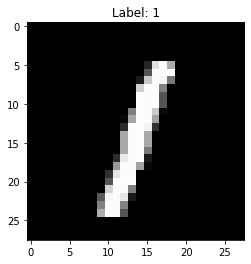

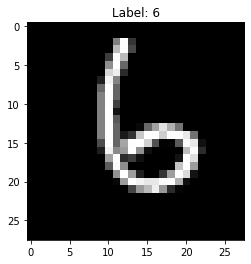

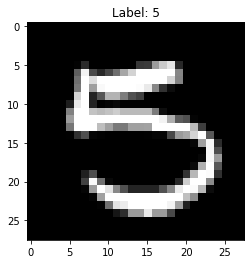

Feature 184 top 3 activations:


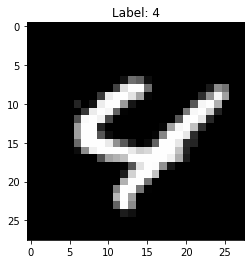

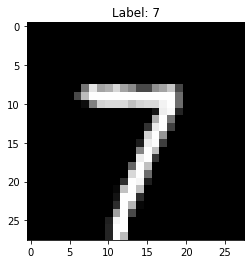

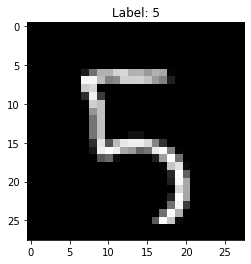

Feature 185 top 3 activations:


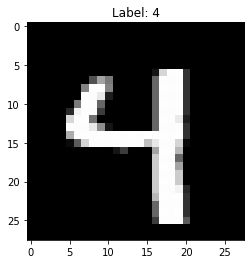

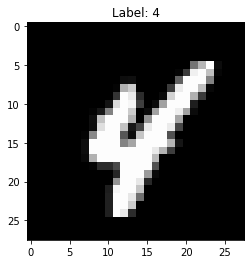

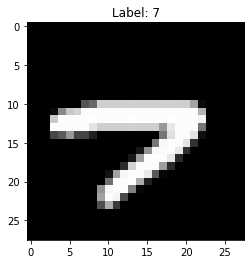

Feature 186 top 3 activations:


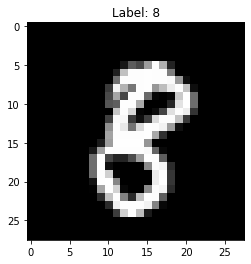

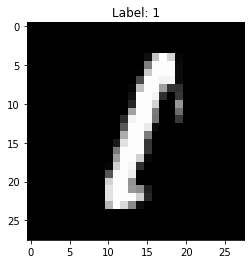

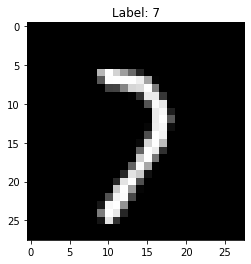

Feature 187 top 3 activations:


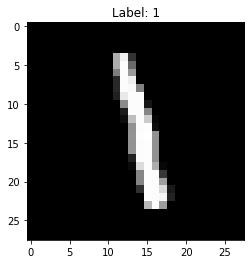

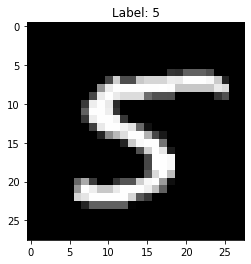

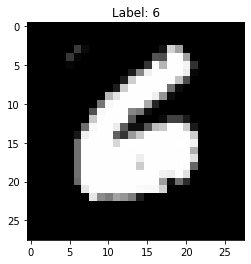

Feature 188 top 3 activations:


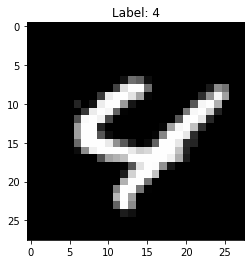

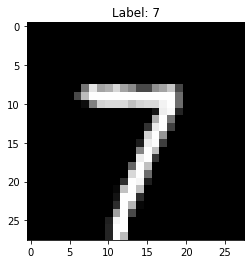

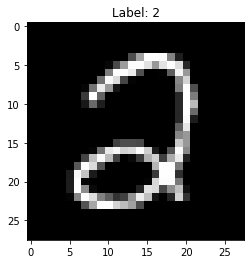

Feature 189 top 3 activations:


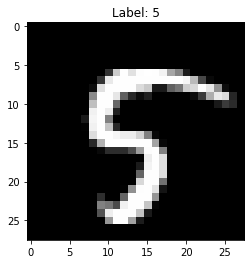

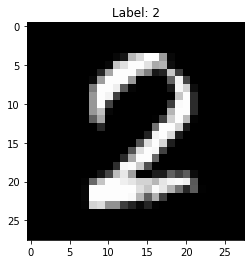

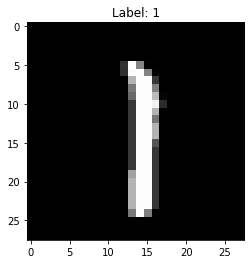

Feature 190 top 3 activations:


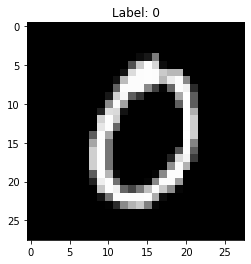

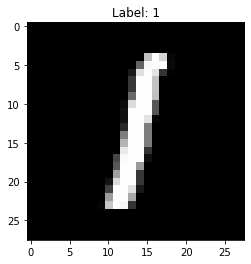

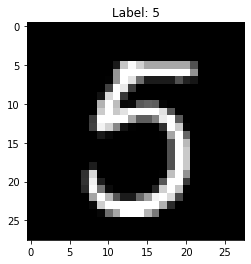

Feature 191 top 3 activations:


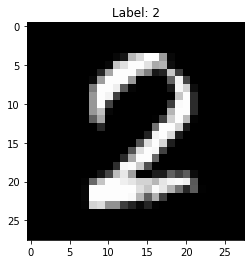

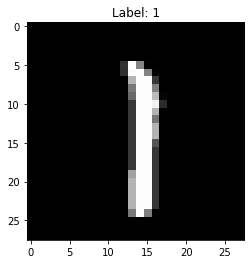

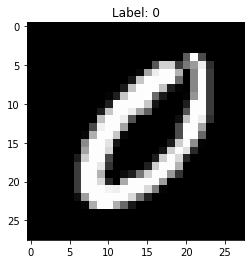

Feature 192 top 3 activations:


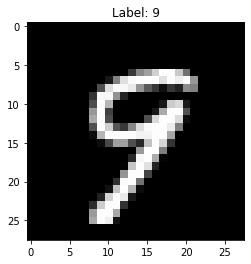

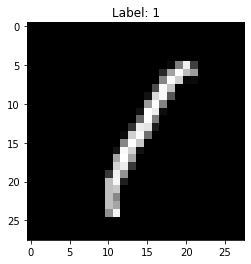

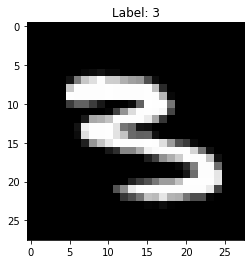

Feature 193 top 3 activations:


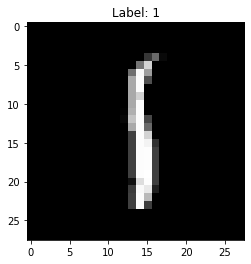

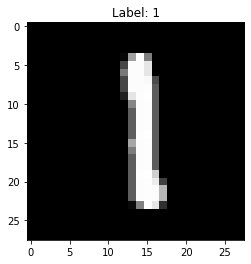

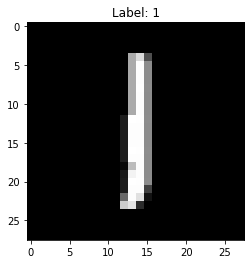

Feature 194 top 3 activations:


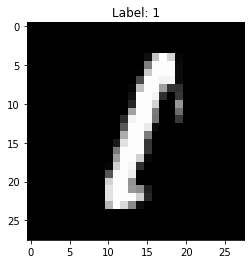

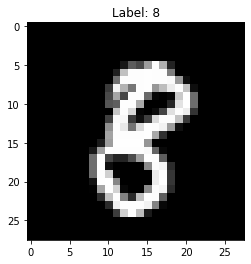

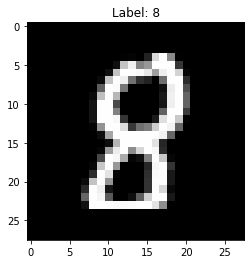

Feature 195 top 3 activations:


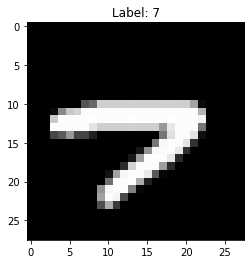

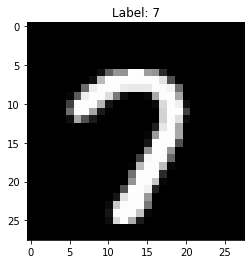

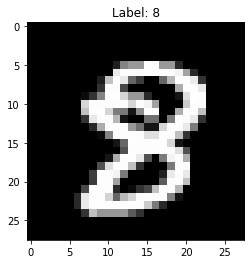

Feature 196 top 3 activations:


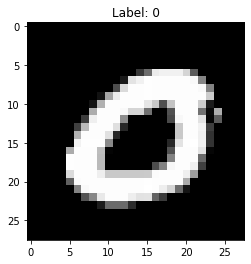

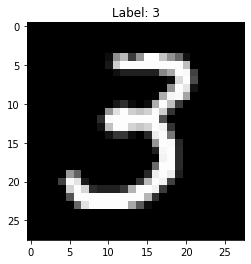

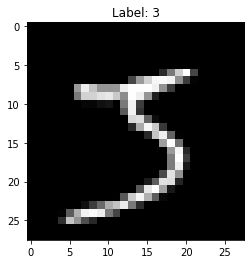

Feature 197 top 3 activations:


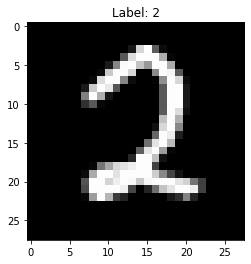

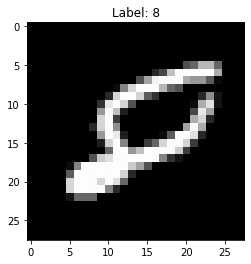

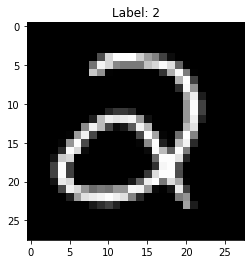

Feature 198 top 3 activations:


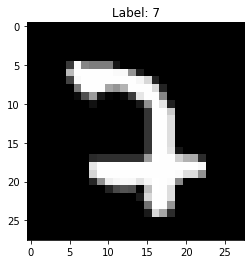

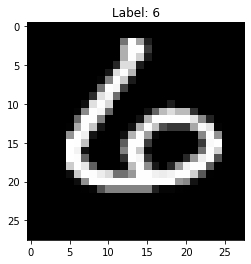

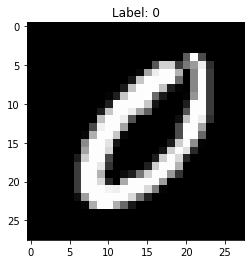

Feature 199 top 3 activations:


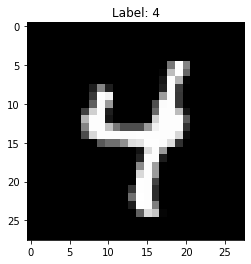

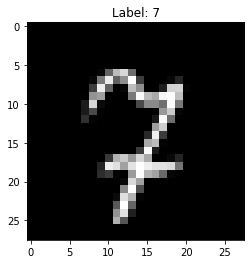

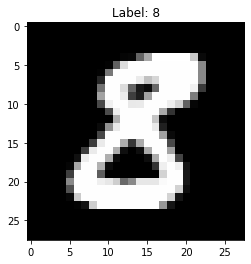

Feature 200 top 3 activations:


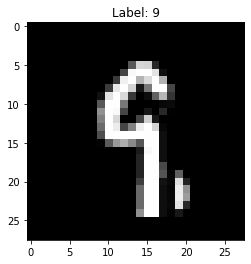

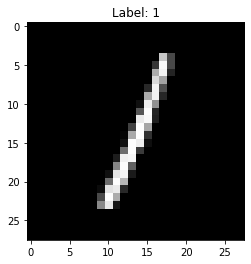

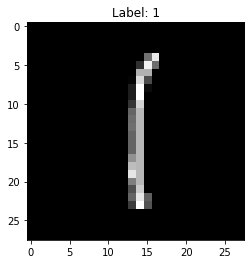

Feature 201 top 3 activations:


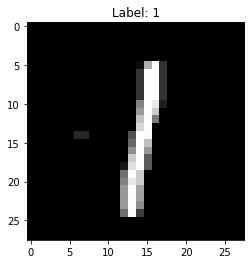

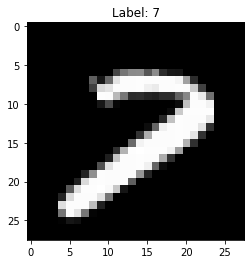

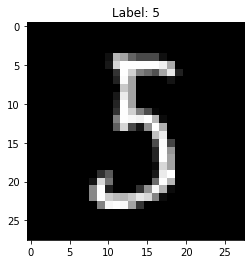

Feature 202 top 3 activations:


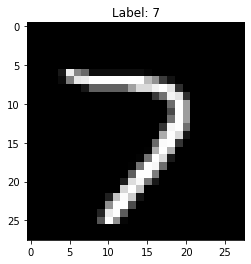

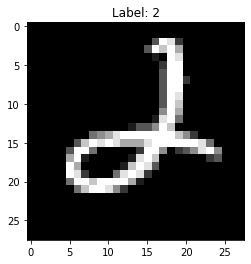

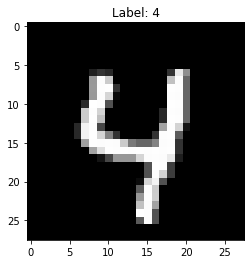

Feature 203 top 3 activations:


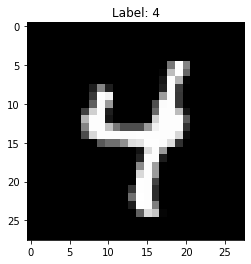

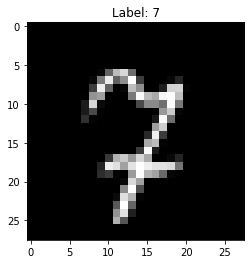

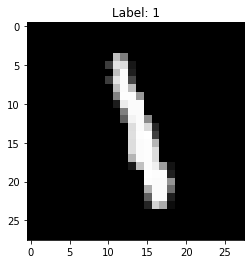

Feature 204 top 3 activations:


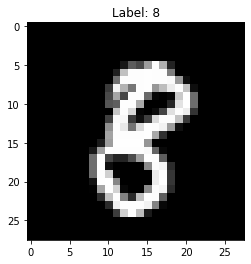

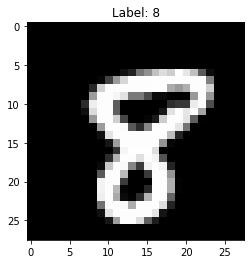

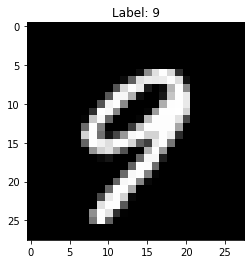

Feature 205 top 3 activations:


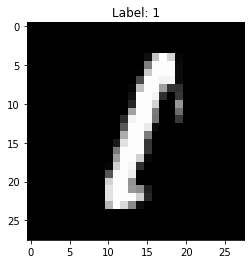

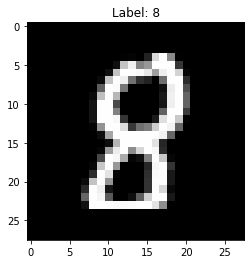

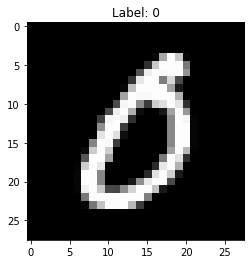

Feature 206 top 3 activations:


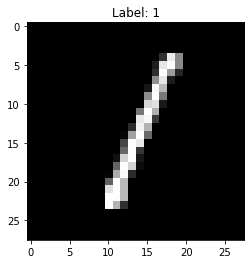

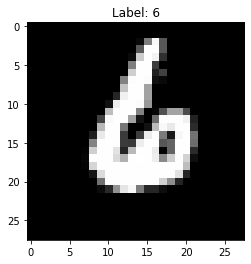

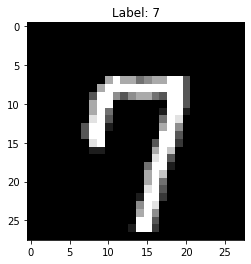

Feature 207 top 3 activations:


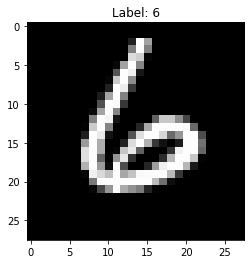

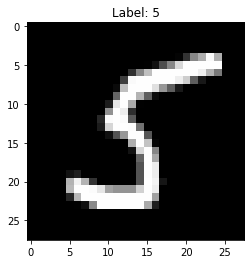

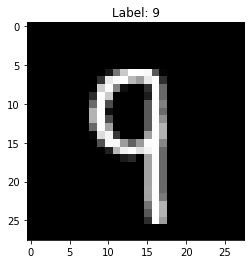

Feature 208 top 3 activations:


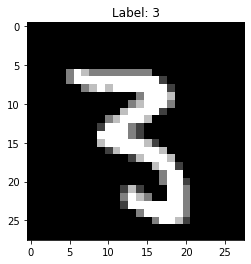

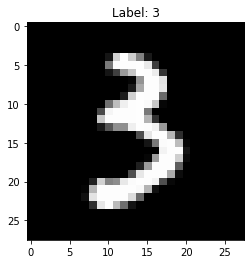

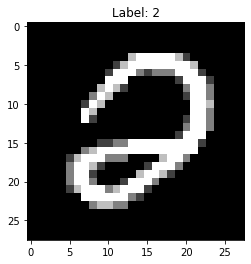

Feature 209 top 3 activations:


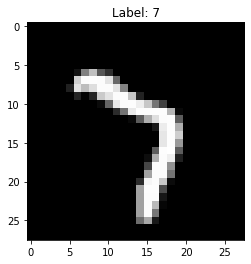

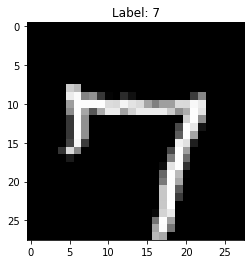

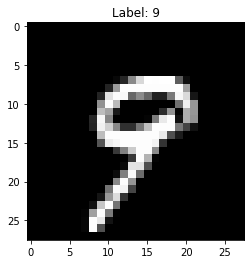

Feature 210 top 3 activations:


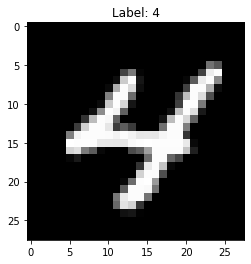

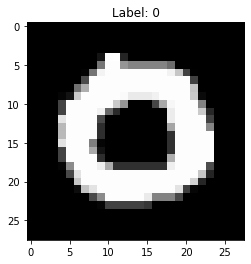

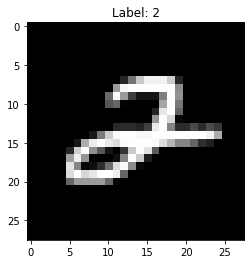

Feature 211 top 3 activations:


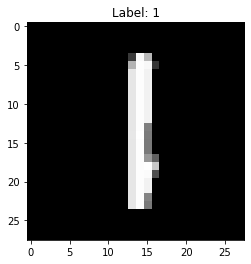

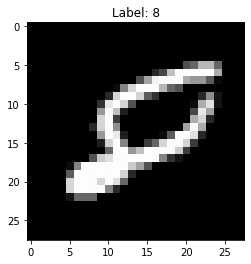

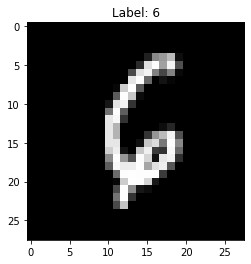

Feature 212 top 3 activations:


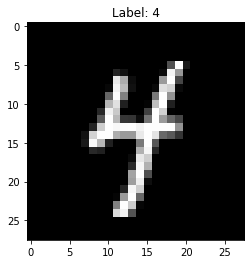

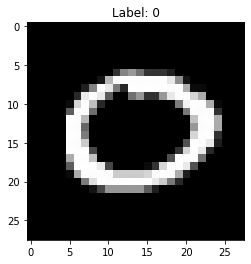

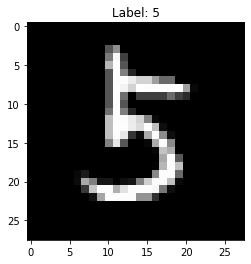

Feature 213 top 3 activations:


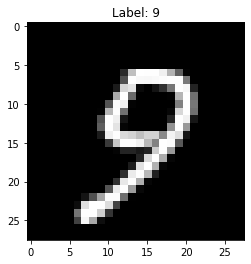

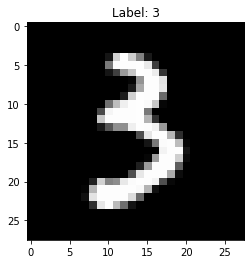

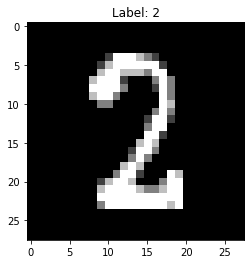

Feature 214 top 3 activations:


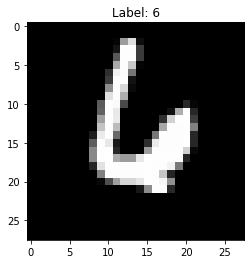

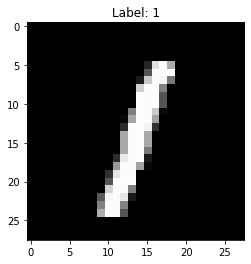

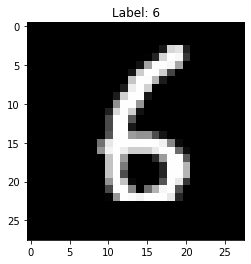

Feature 215 top 3 activations:


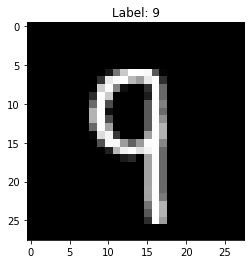

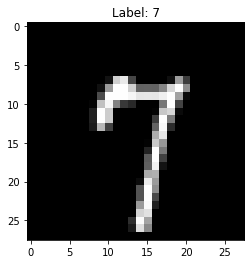

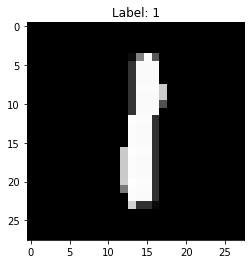

Feature 216 top 3 activations:


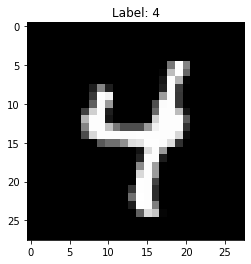

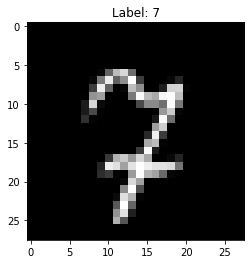

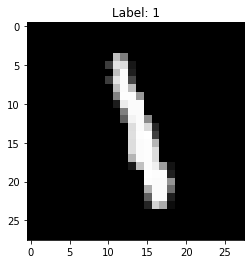

Feature 217 top 3 activations:


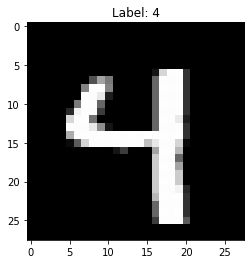

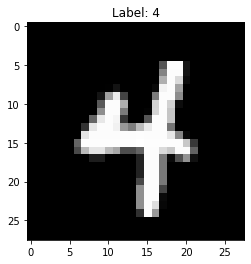

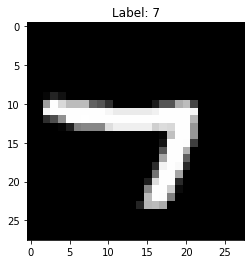

Feature 218 top 3 activations:


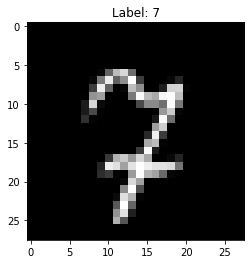

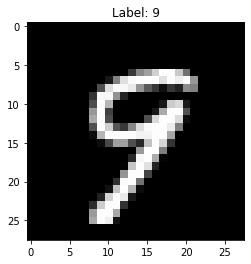

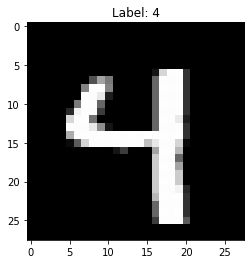

Feature 219 top 3 activations:


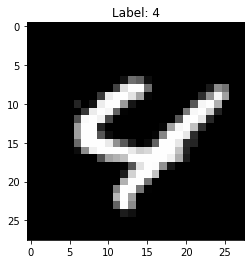

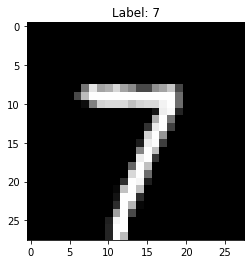

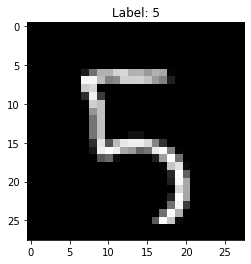

Feature 220 top 3 activations:


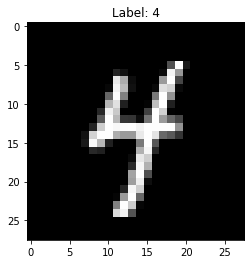

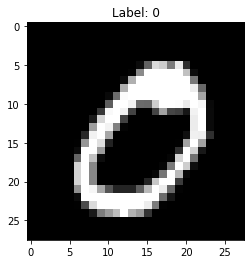

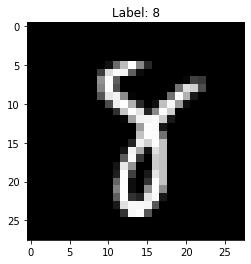

Feature 221 top 3 activations:


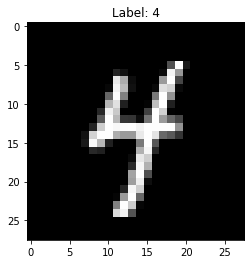

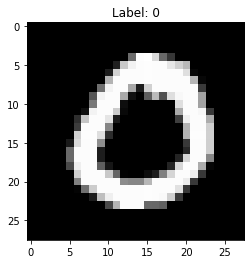

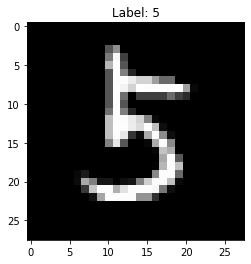

Feature 222 top 3 activations:


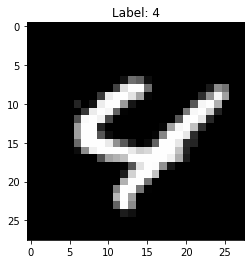

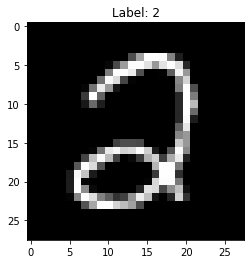

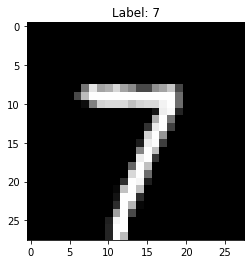

Feature 223 top 3 activations:


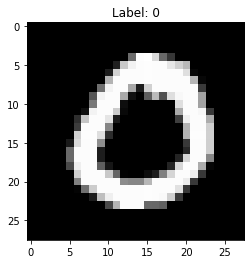

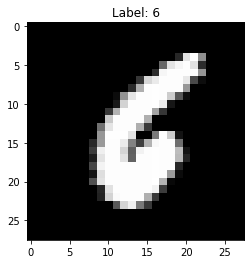

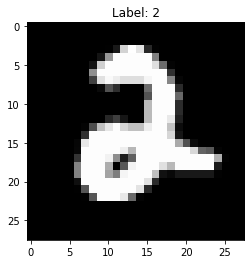

Feature 224 top 3 activations:


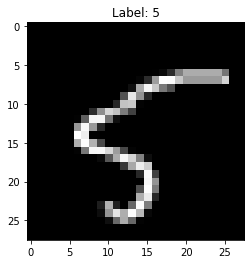

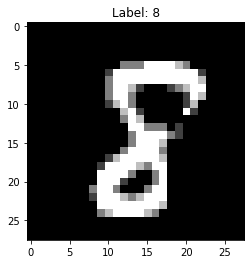

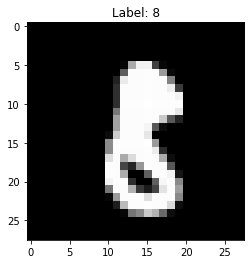

Feature 225 top 3 activations:


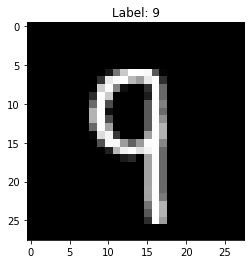

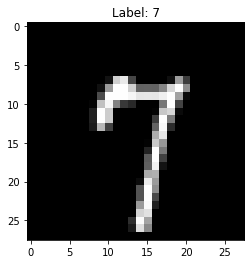

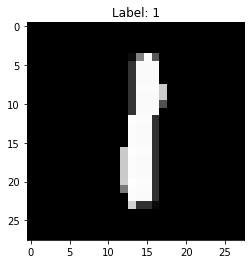

Feature 226 top 3 activations:


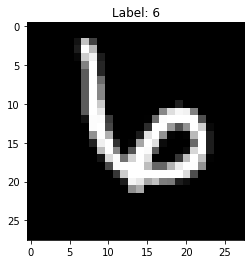

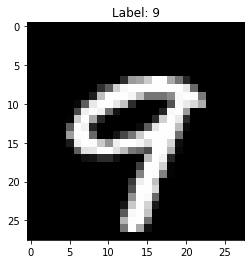

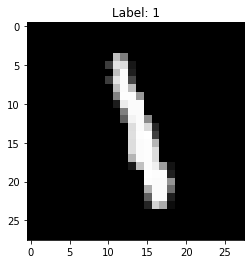

Feature 227 top 3 activations:


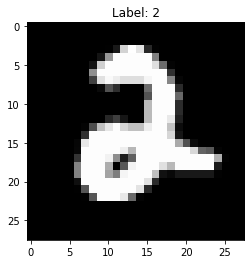

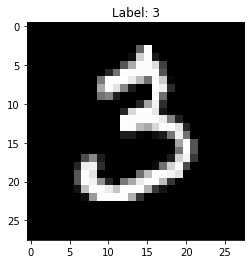

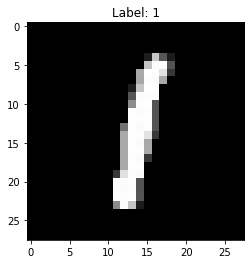

Feature 228 top 3 activations:


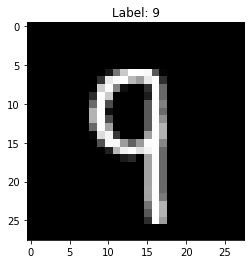

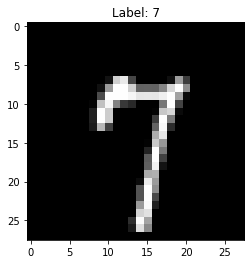

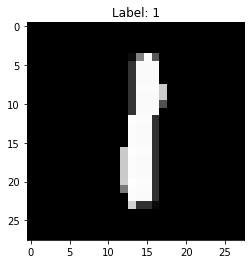

Feature 229 top 3 activations:


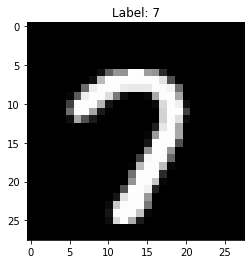

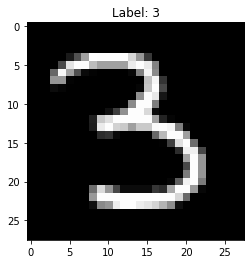

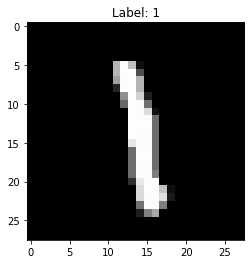

Feature 230 top 3 activations:


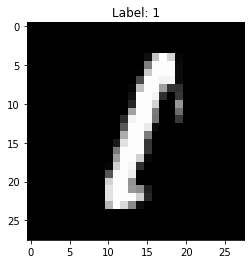

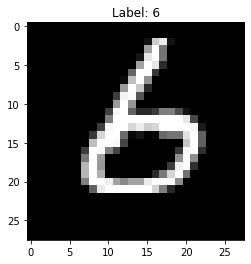

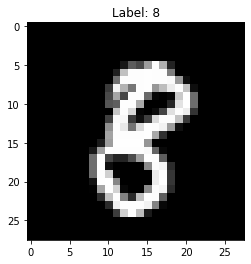

Feature 231 top 3 activations:


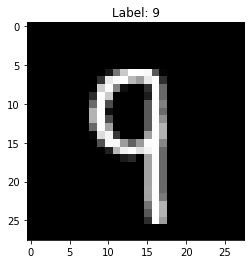

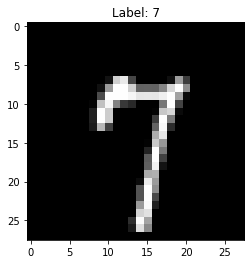

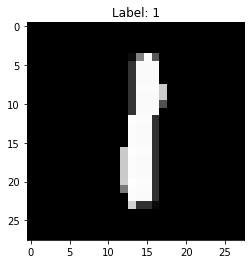

Feature 232 top 3 activations:


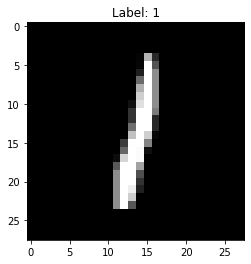

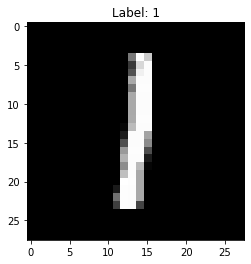

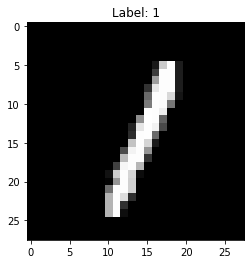

Feature 233 top 3 activations:


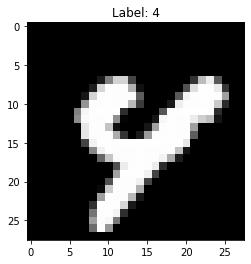

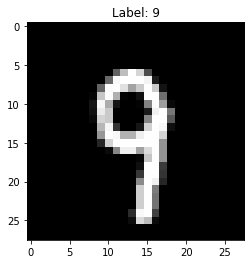

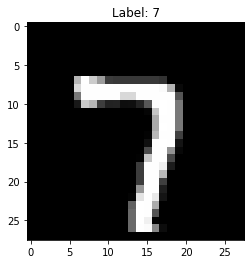

Feature 234 top 3 activations:


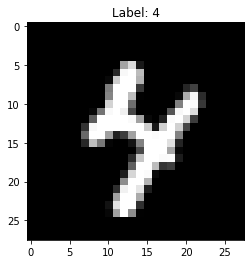

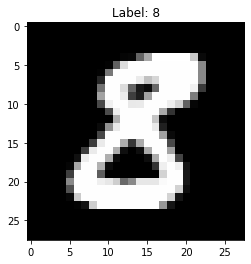

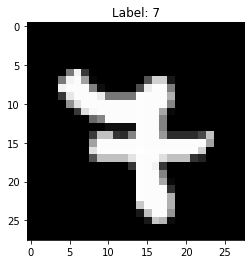

Feature 235 top 3 activations:


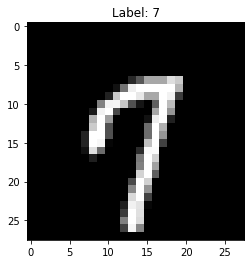

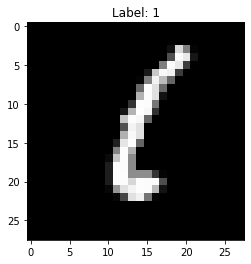

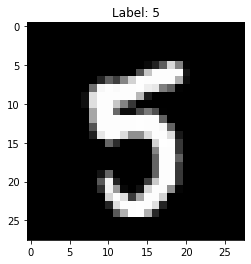

Feature 236 top 3 activations:


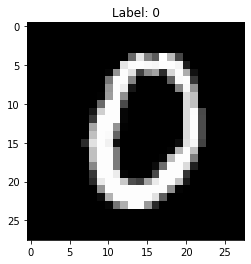

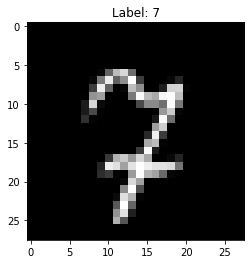

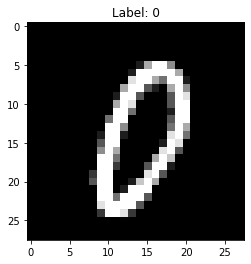

Feature 237 top 3 activations:


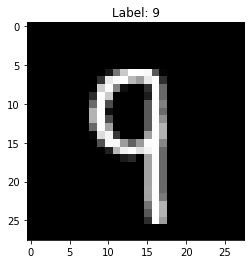

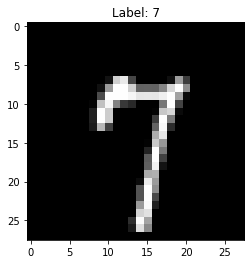

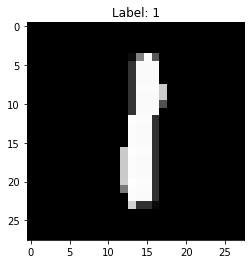

Feature 238 top 3 activations:


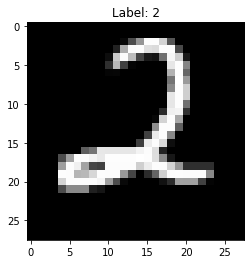

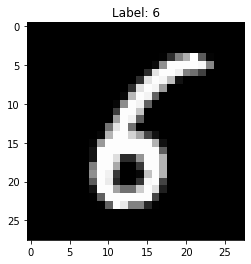

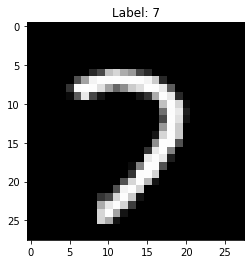

Feature 239 top 3 activations:


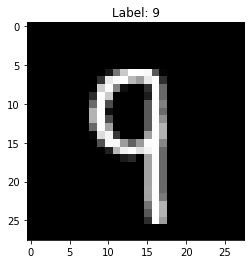

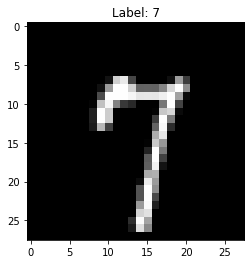

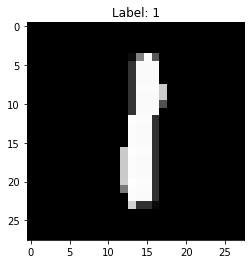

Feature 240 top 3 activations:


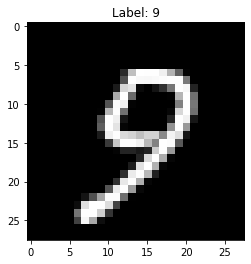

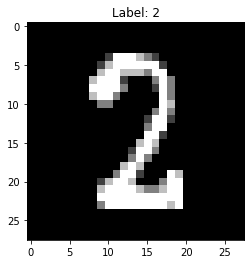

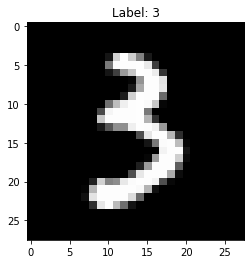

Feature 241 top 3 activations:


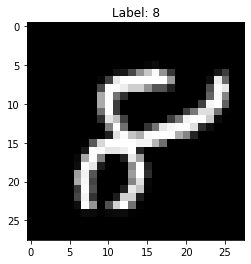

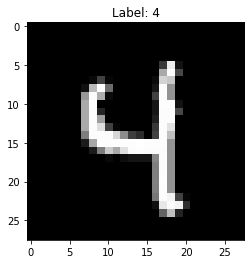

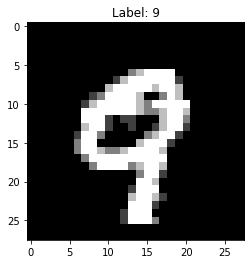

Feature 242 top 3 activations:


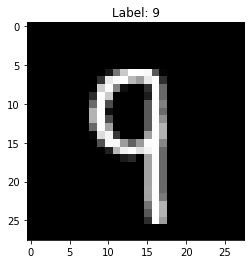

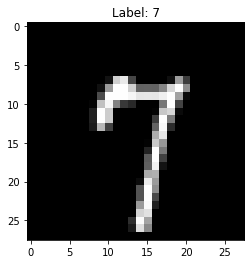

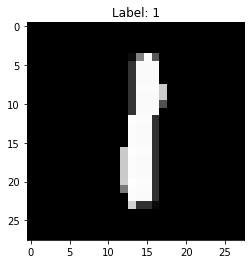

Feature 243 top 3 activations:


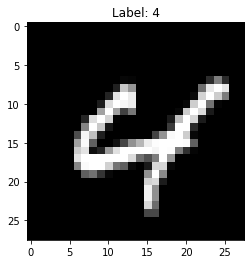

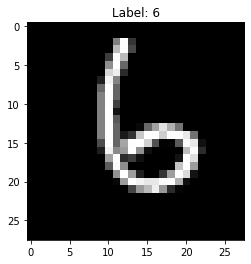

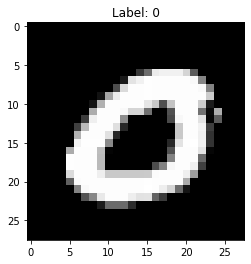

Feature 244 top 3 activations:


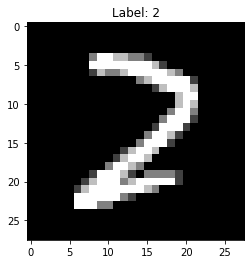

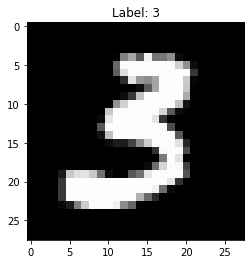

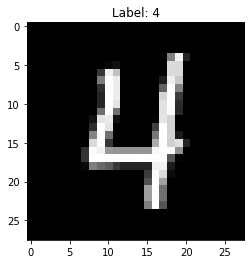

Feature 245 top 3 activations:


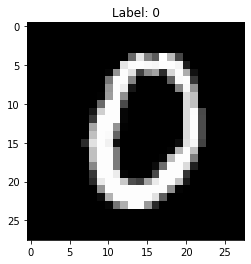

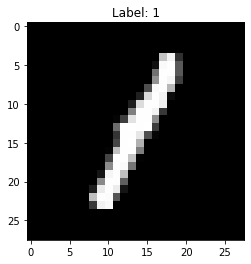

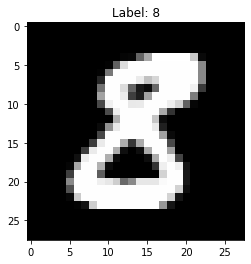

Feature 246 top 3 activations:


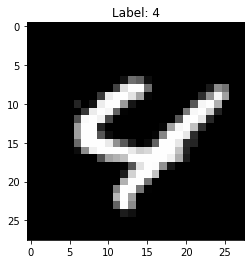

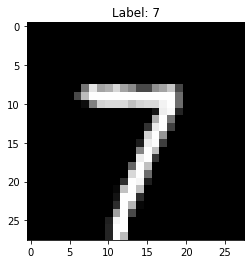

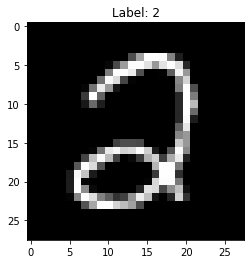

Feature 247 top 3 activations:


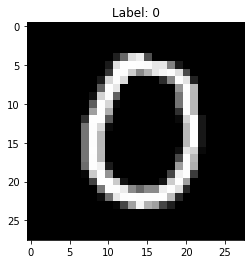

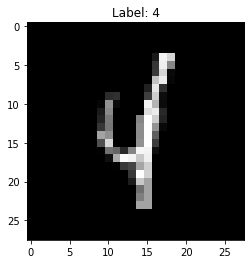

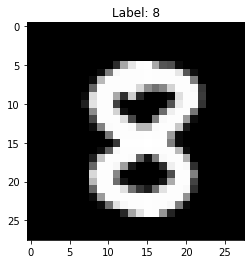

Feature 248 top 3 activations:


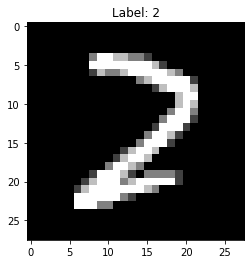

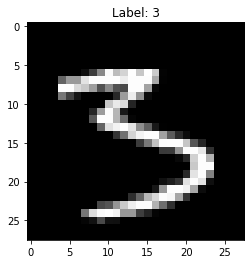

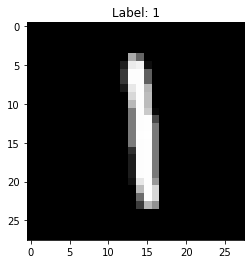

Feature 249 top 3 activations:


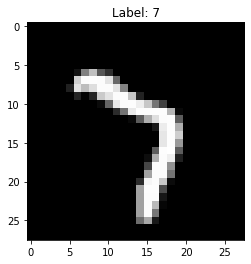

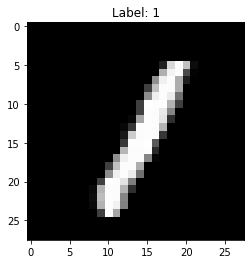

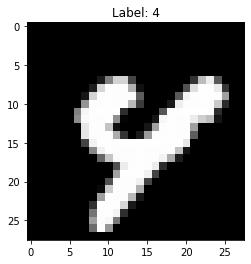

Feature 250 top 3 activations:


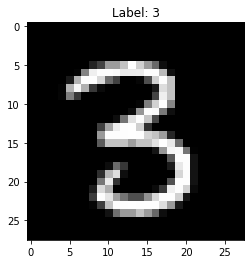

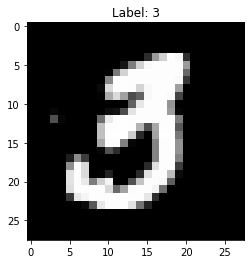

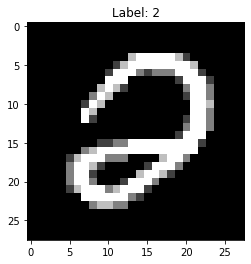

Feature 251 top 3 activations:


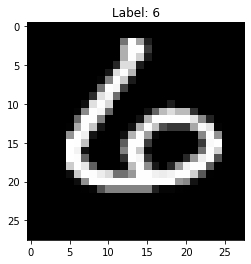

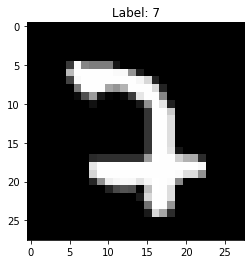

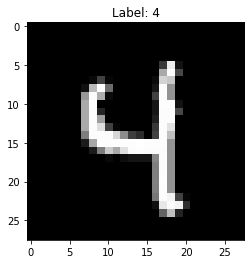

Feature 252 top 3 activations:


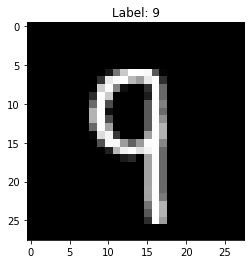

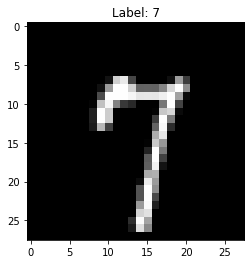

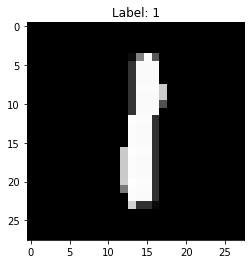

Feature 253 top 3 activations:


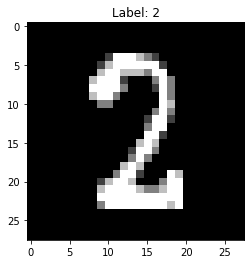

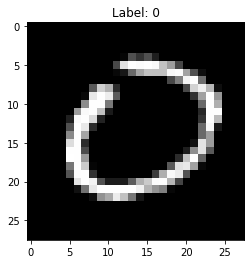

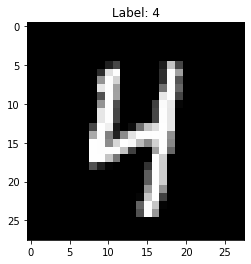

Feature 254 top 3 activations:


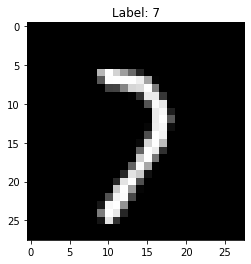

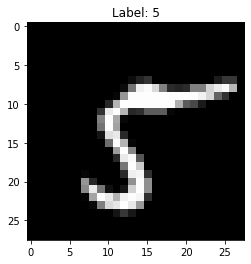

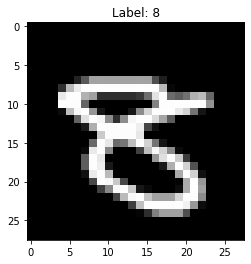

Feature 255 top 3 activations:


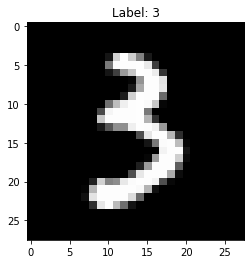

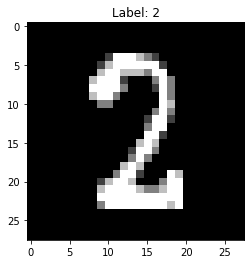

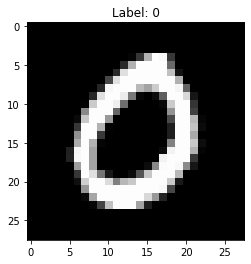

In [35]:
show_top_act_images_by_feature(feature_activations_hidden_two,
                               train_images,
                               train_labels)

# Activation Exploration

## Helper to visualize Activations

In [ ]:
def plot_activations(hidden_one_act, hidden_two_act, classification_out, label, save_plt=False, meta=None):
    if meta:
        label = f"{label}_{meta}"
        
    # Convert tensors to numpy arrays
    hidden_one_act_np = hidden_one_act.cpu().detach().numpy()
    hidden_two_act_np = hidden_two_act.cpu().detach().numpy()
    classification_act_np = classification_out.cpu().detach().numpy()
    
    # Squeeze any singleton dimensions (e.g., (1, 16) -> (16,))
    hidden_one_act_np = np.squeeze(hidden_one_act_np)
    hidden_two_act_np = np.squeeze(hidden_two_act_np)
    classification_act_np = np.squeeze(classification_act_np)
    
    def normalize(acts):
        # Handle scalar or single-value arrays
        if acts.size == 1:
            return np.array([0.5])  # Map to middle of colormap
            
        # Add epsilon to avoid division by zero
        return (acts - acts.min()) / (acts.max() - acts.min() + 1e-8)
        
    hidden_one_act_norm = normalize(hidden_one_act_np)
    hidden_two_act_norm = normalize(hidden_two_act_np)
    classification_act_norm = normalize(classification_act_np)
    
    fig, ax = plt.subplots(figsize=(6, 12))

    ax.set_facecolor('#ADD8E6')
    fig.patch.set_facecolor('#ADD8E6')
    
    for i in range(16):  # Hidden Layer 1
        ax.add_patch(plt.Circle((1, i), radius=0.5, color=plt.cm.gray(hidden_one_act_norm[i])))
        
    for i in range(16):  # Hidden Layer 2
        ax.add_patch(plt.Circle((2, i), radius=0.5, color=plt.cm.gray(hidden_two_act_norm[i])))
        
    for i in range(10):  # Output Layer
        ax.add_patch(plt.Circle((3, i), radius=0.5, color=plt.cm.gray(classification_act_norm[i])))
             
    ax.set_ylim(-1, 16)
    ax.set_xlim(0, 4)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Hidden 1', 'Hidden 2', 'Output'])
    ax.set_yticks(range(16))  # Explicit ticks for 0–15
    ax.set_yticklabels(range(16))
    ax.set_title(f"Neural Network Activation Visualization - {label}")

    if save_plt:
        path = f"./avg_activations/{EXPERIMENT_TYPE}/{RUN_ID}/{label}.png"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
        plt.close()
    else:
        plt.show()

### Averaging Across All Activations

In [ ]:
layers = ["hidden_one", "hidden_two", "classification_out"]
def get_avg_layer(label, layer, act, stor_dict):
    if label in stor_dict:
        cur = avg_act_num_dict[label][layer]
        cur.append(act)
        avg_act_num_dict[label][layer] = cur

    else:
        avg_act_num_dict[label] = {}
        avg_act_num_dict[label][layer] = [act]

        for l in layers:
            if l != layer:
                avg_act_num_dict[label][l] = []
        
    return stor_dict

In [ ]:
avg_act_num_dict = {}
with torch.no_grad():
    for i in range(len(test_labels)):
        image = image = torch.from_numpy(test_images[i]).float().unsqueeze(0)
        label = test_labels[i]

        # Move to device
        image = image.to(device)

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        layer = "hidden_one"
        avg_act_num_dict = get_avg_layer(label, layer, hidden_one_act, avg_act_num_dict)

        layer = "hidden_two"
        avg_act_num_dict = get_avg_layer(label, layer, hidden_two_act, avg_act_num_dict)

        layer = "classification_out"
        avg_act_num_dict = get_avg_layer(label, layer, classification_out, avg_act_num_dict)

In [ ]:
for label in avg_act_num_dict.keys():
    for layer in avg_act_num_dict[label].keys():
        acts = torch.cat(avg_act_num_dict[label][layer], dim=0)
        avg_act = torch.mean(acts, dim=0)

        avg_act_num_dict[label][layer] = avg_act

In [ ]:
avg_act_num_dict[0]

In [ ]:
for num in avg_act_num_dict.keys():
    hidden_one_act = avg_act_num_dict[num]["hidden_one"]
    hidden_two_act = avg_act_num_dict[num]["hidden_two"]
    classification_out = avg_act_num_dict[num]["classification_out"]

    plot_activations(hidden_one_act, hidden_two_act, classification_out, num, True)

## Seeing Specific Activations

In [ ]:
with torch.no_grad():
    for i in range(10):
        # Get single image and label
        image = torch.from_numpy(test_images[i]).float().unsqueeze(0)
        label = test_labels[i]

        # Move to device
        image = image.to(device)

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        # Print results
        print(f"Image {i+1}: True Label = {label}, Predicted Label = {predicted}")

        plot_activations(hidden_one_act, hidden_two_act, classification_out, label)

In [ ]:
idx = 0

image_np = test_images[idx]
image_np_filt = np.where(image_np >= 180, image_np, 0)

image = torch.from_numpy(image_np).float().unsqueeze(0)
image_filt = torch.from_numpy(image_np_filt).float().unsqueeze(0)
label = test_labels[idx]

visualize_image(image_np, label)
visualize_image(image_np_filt, label)

In [ ]:
images = [image, image_filt]
with torch.no_grad():
    for i, img in enumerate(images):
        # Move to device
        img = img.to(device)
        
        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(img)
        
        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()
        
        # Print results
        print(f"Image: True Label = {label}, Predicted Label = {predicted}")

        meta = "normal"
        if i != 0:
            meta = "filt"
        plot_activations(hidden_one_act, hidden_two_act, classification_out, label, True, meta)